In [1]:
import os, sys, time, datetime, random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from torch.utils.data import DataLoader

from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import model as m
import utils
import numpy as np

In [2]:
size_IMG = 24
depth_1 = 16
depth_2 = 16
num_classes = 1950

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, depth_1, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(depth_1, depth_2, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(int(size_IMG ** 2 / 16) * depth_2, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        # conv_x = self.layer2[0](out)

        out = self.layer2(out)
        # max_pool_x = out

        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)

        out = self.fc1(out)
        out = self.fc2(out)

        return out#, conv_x, max_pool_x

In [3]:
model = torch.load("conv_network_model")#, map_location=device)
model.eval()

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=576, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1950, bias=True)
)

In [5]:
def make_square(im, min_size=10, fill_color=(255)):
    x, y = im.size
    size = 24#max(min_size, x, y)
    new_im = Image.new('P', (size, size), fill_color)
    new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
    return new_im

def cropped_image(img, dl=25, ds=10, dn=2):
    w, h = img.size

    imgs = []
    boxes = []
    for i in range(0,img.size[0]-ds, dn):
        for j in range(0,img.size[1]-ds, dn):
            if j+dl<w:
                box = (i,j,i+ds,j+dl)
                im1 = img.crop(box)
                im1 = make_square(im1)
                
                imgs.append(im1)
                boxes.append(box)
                
            if i+dl<h:
                box = (i,j,i+dl,j+ds)
                im1 = img.crop(box)
                
                im1 = make_square(im1)
                imgs.append(im1)
                boxes.append(box)
                
            box = (i,j,i+ds,j+ds)
            im1 = img.crop(box)
            im1 = make_square(im1)
            imgs.append(im1)
            boxes.append(box)

    return imgs, boxes

def detect_image(img, size_IMG, label):

    if label in pianpanglist:
        return None
    
    img_transforms= transforms.Compose(
        [transforms.Resize(size_IMG),     
         transforms.ToTensor(),
         ])
    

    tensorimage = img_transforms(img).float()
    
   
    outputs = model(tensorimage.view(1,1,size_IMG,size_IMG).cuda())
    if torch.max(F.softmax(outputs))>0.8:

        _, predicted = torch.max(outputs.data, 1)
        print(labels[predicted])
        if labels[predicted] in pianpanglist:
            return labels[predicted]
    

In [54]:
strs = np.loadtxt('pianpang.txt',delimiter='\n',dtype=str)
pianpanglist = []
for stri in list(strs):
    pianpanglist+=stri.split()
print(pianpanglist)

['丨', '亅', '丿', '乛', '一', '乙', '乚', '丶', '八', '勹', '匕', '冫', '卜', '厂', '刀', '刂', '儿', '二', '匚', '阝', '丷', '几', '卩', '冂', '力', '冖', '凵', '人', '亻', '入', '十', '厶', '亠', '匸', '讠', '廴', '又', '艹', '屮', '彳', '巛', '川', '辶', '寸', '大', '飞', '干', '工', '弓', '廾', '广', '己', '彐', '彑', '巾', '口', '马', '门', '宀', '女', '犭', '山', '彡', '尸', '饣', '士', '扌', '氵', '纟', '巳', '土', '囗', '兀', '夕', '小', '忄', '幺', '弋', '尢', '夂', '子', '贝', '比', '灬', '长', '车', '歹', '斗', '厄', '方', '风', '父', '戈', '卝', '户', '火', '旡', '见', '斤', '耂', '毛', '木', '肀', '牛', '牜', '爿', '片', '攴', '攵', '气', '欠', '犬', '日', '氏', '礻', '手', '殳', '水', '瓦', '尣', '王', '韦', '文', '毋', '心', '牙', '爻', '曰', '月', '爫', '支', '止', '爪', '白', '癶', '歺', '甘', '瓜', '禾', '钅', '立', '龙', '矛', '皿', '母', '目', '疒', '鸟', '皮', '生', '石', '矢', '示', '罒', '田', '玄', '穴', '疋', '业', '衤', '用', '玉', '耒', '艸', '臣', '虫', '而', '耳', '缶', '艮', '虍', '臼', '米', '齐', '肉', '色', '舌', '覀', '页', '先', '行', '血', '羊', '聿', '至', '舟', '衣', '竹', '自', '羽', '糸', '糹', '貝', '采', '镸', '車', '辰', '赤', '辵', '豆',

In [55]:

# print(len(imgs))
labels = np.load("labels.npy")
pianpanglist +=['分']

['一' '丁' '七' ... '姷' '姹' '姺']


In [64]:
def dect_single(img, label):
    imgs, boxes = cropped_image(img)
    detection = dict()
    for inds,im in enumerate(imgs):

        lab = detect_image(im, img_size, label) 
        if lab:
            if lab not in detelab:       
                
                print(lab, boxes[inds])
                
                plt.imshow(im)
                plt.show()
                if lab not in detection.keys():
                    detection[lab] = boxes[inds]
                    
    return detection

一 {}
丁
丁 {}
十
十 (8, 2, 18, 27)


/home/wonton/anaconda3/envs/momotorch/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


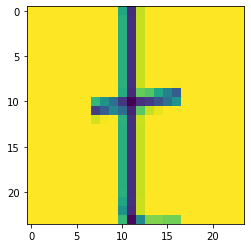

七 {'十': (8, 2, 18, 27)}
万 {}
丈
丈
丈
丈
丈 {}
三 {}
十
十 (8, 0, 18, 25)


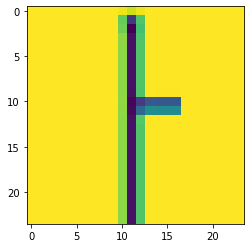

上 {'十': (8, 0, 18, 25)}
十
十 (8, 2, 18, 27)


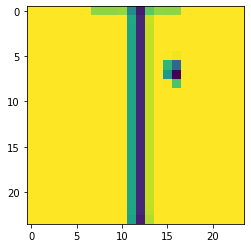

下
卜
卜 (12, 2, 22, 27)


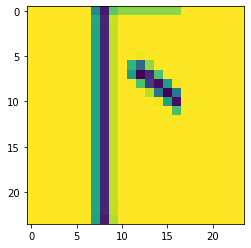

下 {'十': (8, 2, 18, 27), '卜': (12, 2, 22, 27)}
丁
丁
丌 {}
冫
冫 (2, 6, 12, 16)


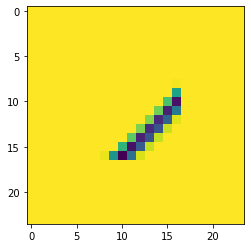

个
亻
亻 (6, 0, 16, 25)


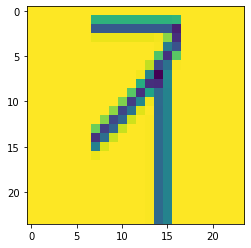

亻
亻 (6, 2, 16, 27)


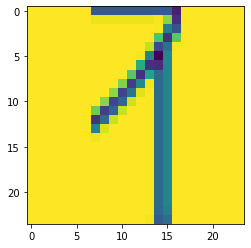

亻
亻 (8, 2, 18, 27)


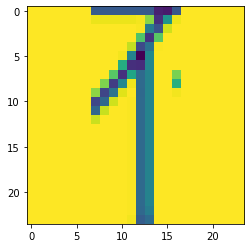

下
卜
卜 (14, 2, 24, 27)


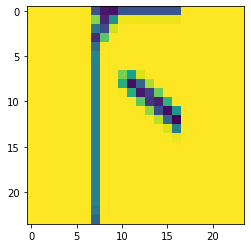

不 {'冫': (2, 6, 12, 16), '亻': (6, 0, 16, 25), '卜': (14, 2, 24, 27)}
与 {}
丏 {}
丐 {}
丑 {}
专
专 {}
且 {}
冫
冫 (2, 6, 12, 16)


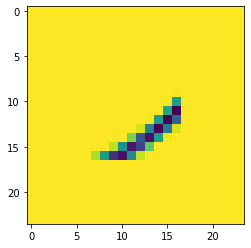

个
丕 {'冫': (2, 6, 12, 16)}
上
世 {}
丘 {}
囚
丙 {}
业 {}
夕
夕 (8, 2, 18, 27)


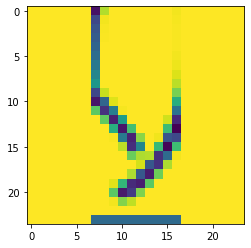

丛 {'夕': (8, 2, 18, 27)}
东 {}
么
么
么
丝 {}
丞
丞
丞
丞 {}
乓
丟 {}
両 {}
丢 {}
两 {}
严
严 {}
並 {}
夕
夕 (12, 12, 22, 22)


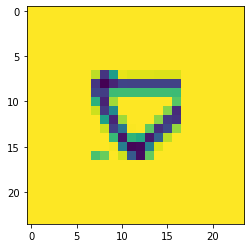

丧 {'夕': (12, 12, 22, 22)}
丨 {}
冫
冫 (0, 2, 10, 12)


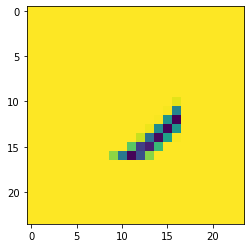

冫
冫 (2, 0, 12, 10)


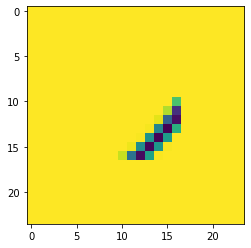

个
亻
亻 (6, 0, 16, 25)


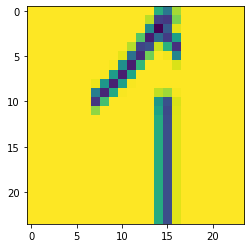

个
个
个 {'冫': (0, 2, 10, 12), '亻': (6, 0, 16, 25)}
丫
丫
冫
冫 (12, 0, 22, 10)


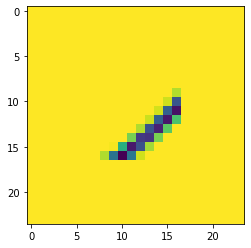

丫 {'冫': (12, 0, 22, 10)}
丬 {}
中 {}
丮 {}
丰 {}
卩
卩 (16, 0, 26, 25)


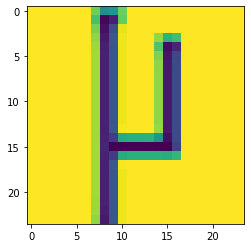

卩
卩 (16, 2, 26, 27)


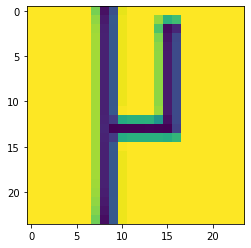

丱 {'卩': (16, 0, 26, 25)}
中
中
串 {}
临 {}
丈
丸 {}
丹
丹
丬
丬 (12, 2, 22, 27)


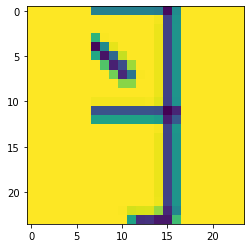

丹 {'丬': (12, 2, 22, 27)}
囚
囚
冫
冫 (2, 14, 12, 24)


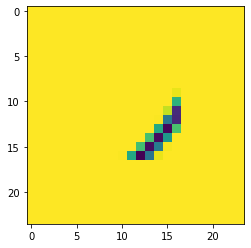

丬
丬 (6, 0, 16, 25)


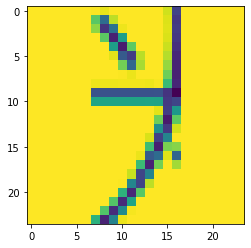

为 {'冫': (2, 14, 12, 24), '丬': (6, 0, 16, 25)}
亠
亠 (0, 0, 25, 10)


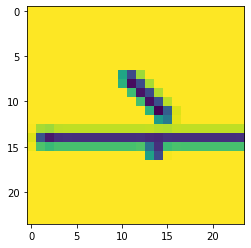

亠
亠 (2, 0, 27, 10)


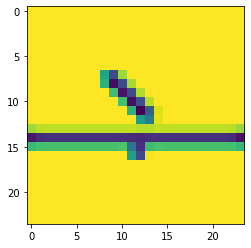

卞
卞
卞
主 {'亠': (0, 0, 25, 10)}
丬
丬 (0, 0, 10, 25)


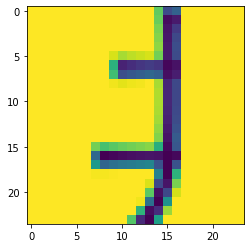

丬
丬 (0, 2, 10, 27)


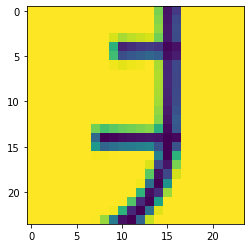

丹
丹
丹
卜
卜 (8, 0, 18, 25)


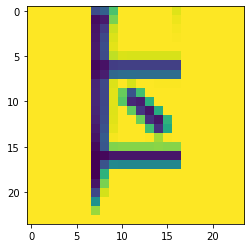

冲
丼 {'丬': (0, 0, 10, 25), '卜': (8, 0, 18, 25)}
下
下
下
丽 {}
举 {}
冫
冫 (0, 0, 10, 25)


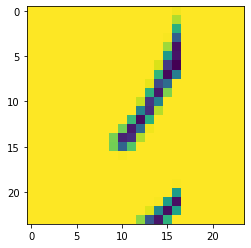

冫
冫 (0, 2, 10, 27)


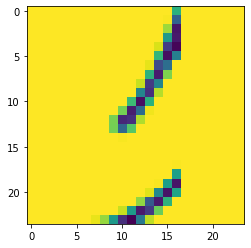

冫
冫 (0, 4, 10, 14)


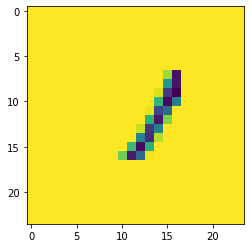

冫
冫 (0, 16, 10, 26)


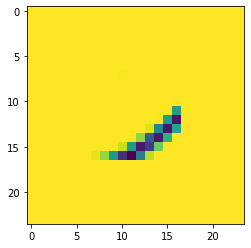

夕
夕 (6, 0, 16, 25)


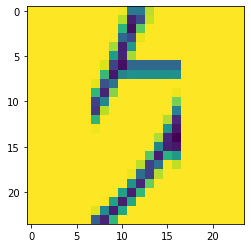

夕
夕 (6, 2, 16, 27)


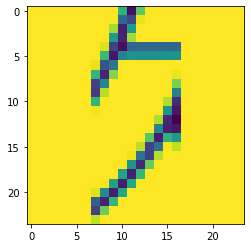

久
久
久
久
久
久 {'冫': (0, 0, 10, 25), '夕': (6, 0, 16, 25)}
冫
冫 (0, 0, 10, 25)


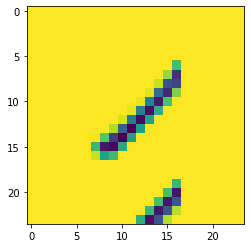

冫
冫 (0, 4, 10, 14)


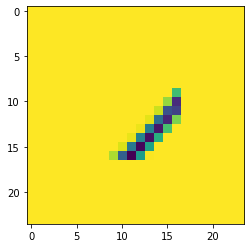

冫
冫 (2, 2, 12, 12)


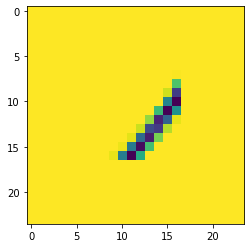

冫
冫 (4, 0, 14, 10)


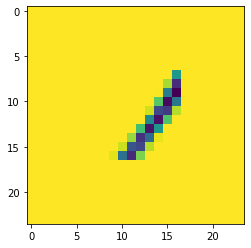

么 {'冫': (0, 0, 10, 25)}
义 {}
冫
冫 (0, 10, 25, 20)


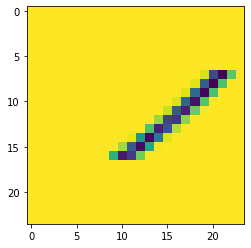

之
之
之
之
之 {'冫': (0, 10, 25, 20)}
乌 {}
乍 {}
乎
乎
乎
乎
乎 {}
乏
乏
乏
乏 {}
乐 {}
乒 {}
乒
卞
乓 {}
乔 {}
乖
乖 {}
乘
乘 {}
乙 {}
乜 {}
丬
丬 (2, 0, 12, 25)


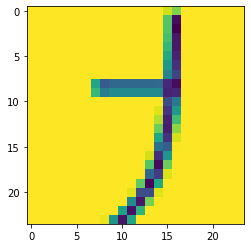

丬
丬 (2, 2, 12, 27)


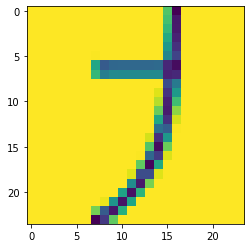

九 {'丬': (2, 0, 12, 25)}
乞 {}
也 {}
丈
习 {}
冫
冫 (0, 16, 25, 26)


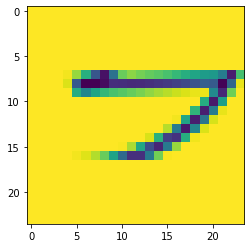

乡
乡
乡
乡
乡 {'冫': (0, 16, 25, 26)}
丬
丬 (4, 0, 14, 25)


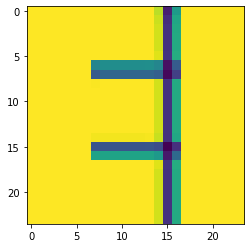

书 {'丬': (4, 0, 14, 25)}
占
乩 {}
今
头
买
买 {}
乱 {}
乳 {}
乾 {}
剥
乿 {}
亂 {}
亅 {}
冫
冫 (0, 2, 25, 12)


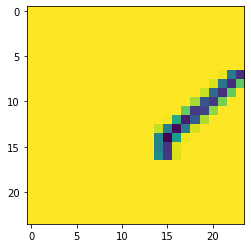

冫
冫 (2, 2, 27, 12)


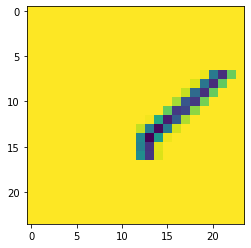

了 {'冫': (0, 2, 25, 12)}
予 {}
争 {}
事
事 {}
二 {}
亍 {}
于 {}
亏
亏
亏
亏 {}
二
二 (0, 2, 25, 12)


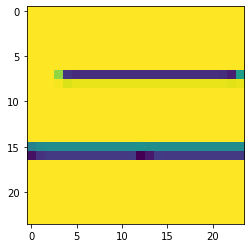

冫
冫 (0, 14, 10, 24)


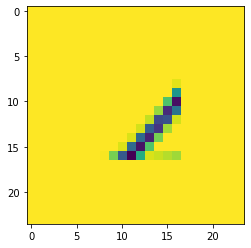

二
二 (2, 2, 27, 12)


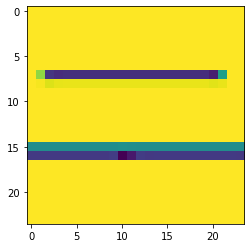

冫
冫 (2, 12, 12, 22)


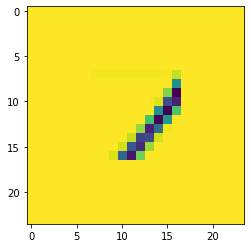

云 {'二': (0, 2, 25, 12), '冫': (0, 14, 10, 24)}
上
互 {}
亓
亓 {}
五 {}
丬
丬 (0, 0, 10, 25)


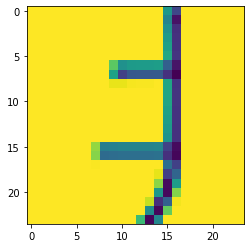

丬
丬 (0, 2, 10, 27)


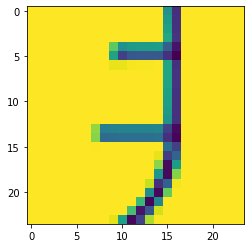

井 {'丬': (0, 0, 10, 25)}
中
亘 {}
丕
亙 {}
亚 {}
些 {}
亞 {}
亟 {}
亠 {}
亠
亠 (2, 0, 27, 10)


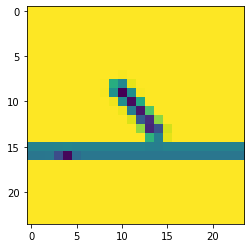

亡 {'亠': (2, 0, 27, 10)}
亢 {}
交
交
交
交 {}
亥
亥
亥
亥 {}
亠
亠 (0, 0, 25, 10)


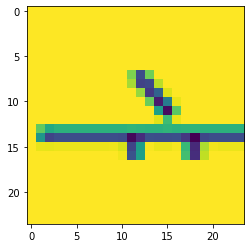

亠
亠 (2, 0, 27, 10)


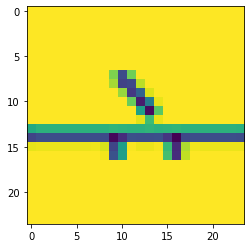

卞
亦 {'亠': (0, 0, 25, 10)}
下
产 {}
卑
亨 {}
中
亩 {}
亨
享 {}
京 {}
亭 {}
亭
亭
亮 {}
亲 {}
亳 {}
亵 {}
亭
亭
卓
亭
亶 {}
喻
亹 {}
人 {}
亻 {}
亻
亻 (0, 0, 10, 25)


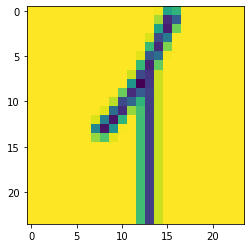

亻
亻 (0, 2, 10, 27)


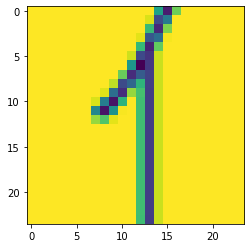

亻
亻 (2, 0, 12, 25)


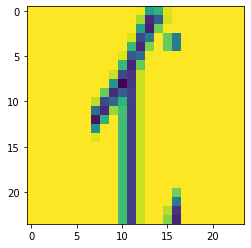

亻
亻 (2, 2, 12, 27)


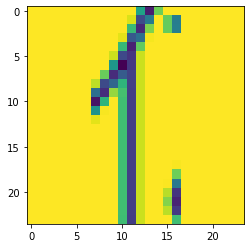

冫
冫 (8, 0, 18, 25)


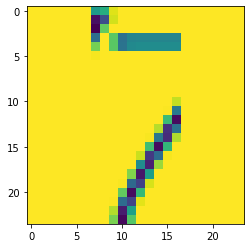

冫
冫 (8, 2, 18, 27)


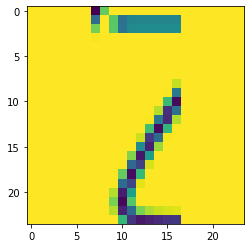

冫
冫 (8, 8, 18, 18)


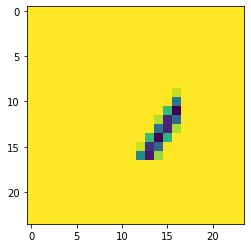

冫
冫 (8, 10, 18, 20)


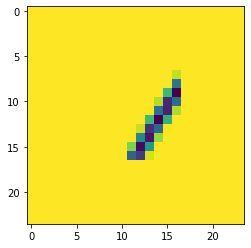

冫
冫 (10, 6, 20, 16)


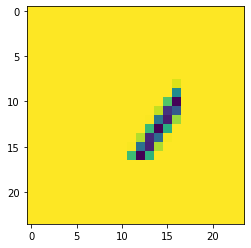

乙
乙 (12, 2, 22, 27)


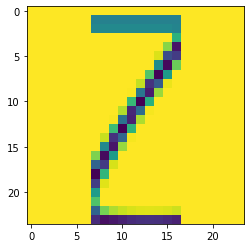

乙
乙 (14, 2, 24, 27)


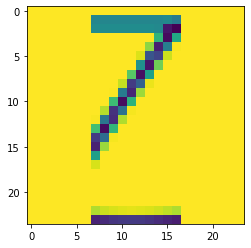

亿 {'亻': (0, 0, 10, 25), '冫': (8, 0, 18, 25), '乙': (12, 2, 22, 27)}
亻
亻 (0, 2, 10, 27)


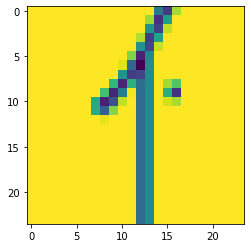

十
十 (14, 2, 24, 27)


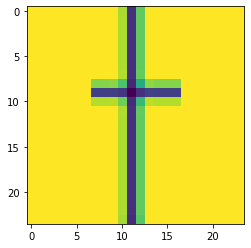

什 {'亻': (0, 2, 10, 27), '十': (14, 2, 24, 27)}
亻
亻 (0, 0, 10, 25)


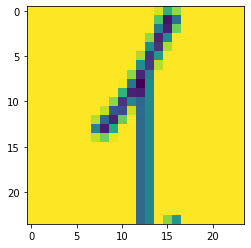

亻
亻 (0, 2, 10, 27)


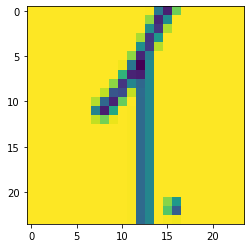

亻
亻 (2, 2, 12, 27)


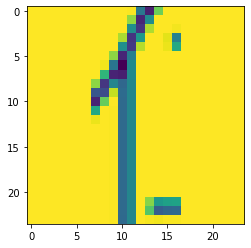

仁 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


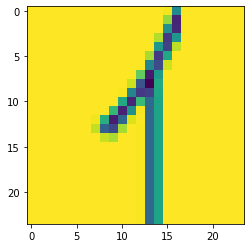

亻
亻 (0, 2, 10, 27)


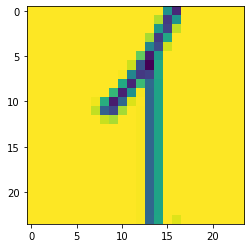

亻
亻 (2, 0, 12, 25)


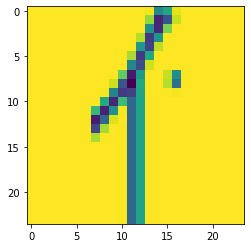

亻
亻 (2, 2, 12, 27)


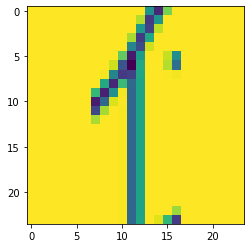

丬
丬 (8, 2, 18, 27)


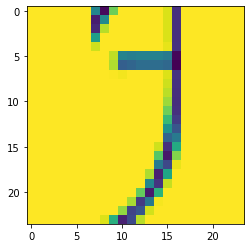

仂 {'亻': (0, 0, 10, 25), '丬': (8, 2, 18, 27)}
亻
亻 (0, 0, 10, 25)


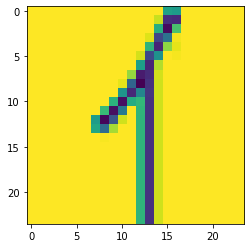

亻
亻 (0, 2, 10, 27)


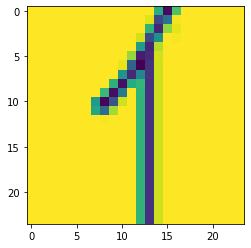

仃 {'亻': (0, 0, 10, 25)}
仄 {}
亻
亻 (0, 0, 10, 25)


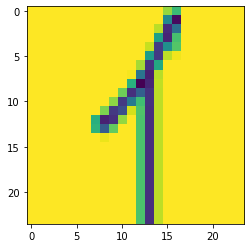

亻
亻 (0, 2, 10, 27)


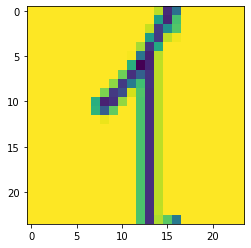

仅 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


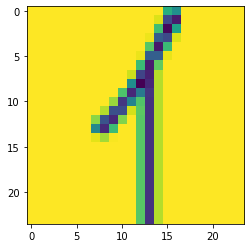

亻
亻 (0, 2, 10, 27)


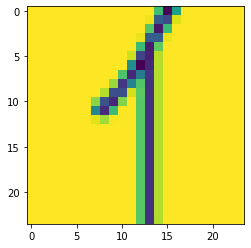

亻
亻 (2, 0, 12, 25)


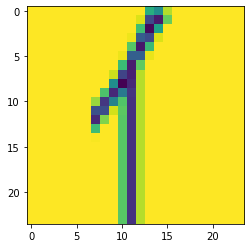

八
八 (2, 0, 27, 10)


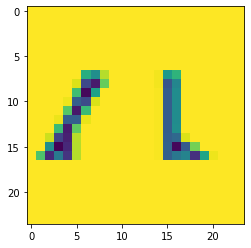

卜
卜 (16, 0, 26, 25)


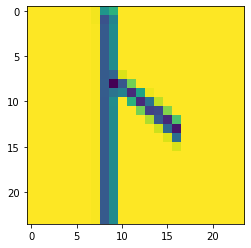

卜
卜 (16, 2, 26, 27)


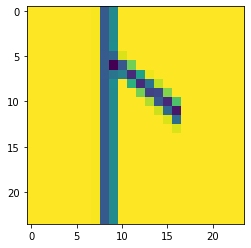

卜
卜 (16, 6, 26, 16)


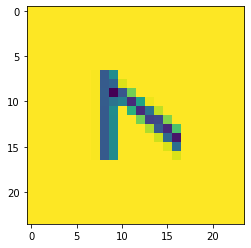

仆 {'亻': (0, 0, 10, 25), '八': (2, 0, 27, 10), '卜': (16, 0, 26, 25)}
仇 {}
亻
亻 (0, 0, 10, 25)


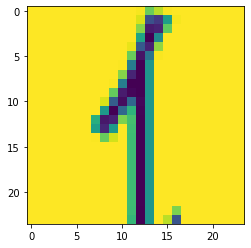

亻
亻 (0, 2, 10, 27)


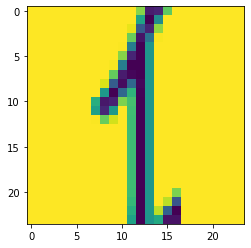

仈 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


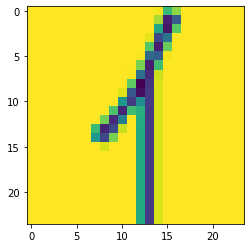

亻
亻 (0, 2, 10, 27)


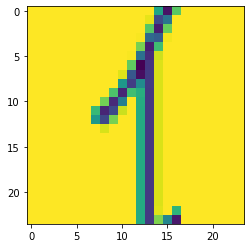

亻
亻 (2, 0, 12, 25)


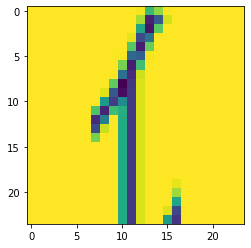

亻
亻 (2, 2, 12, 27)


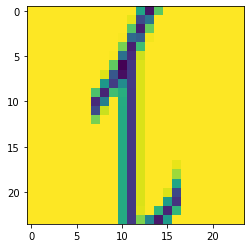

仉 {'亻': (0, 0, 10, 25)}
冫
冫 (0, 2, 10, 12)


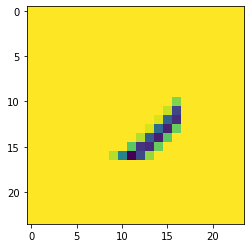

今
今
今
今
今 {'冫': (0, 2, 10, 12)}
冫
冫 (2, 0, 12, 10)


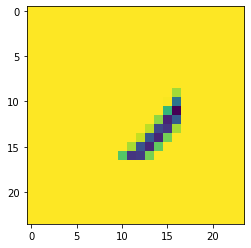

介
介
介 {'冫': (2, 0, 12, 10)}
亻
亻 (0, 0, 10, 25)


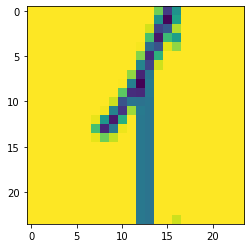

亻
亻 (0, 2, 10, 27)


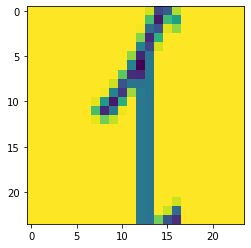

仞
仍 {'亻': (0, 0, 10, 25)}
从 {}
亻
亻 (4, 0, 14, 25)


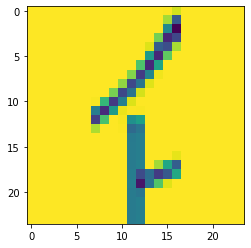

冫
冫 (4, 0, 14, 10)


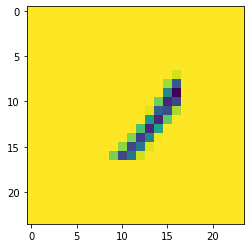

亻
亻 (4, 2, 14, 27)


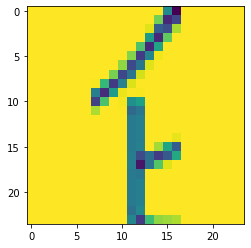

仑 {'亻': (4, 0, 14, 25), '冫': (4, 0, 14, 10)}
冫
冫 (2, 0, 12, 10)


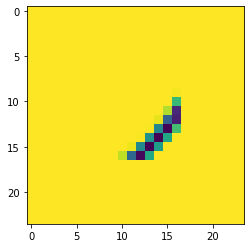

仓 {'冫': (2, 0, 12, 10)}
亻
亻 (0, 0, 10, 25)


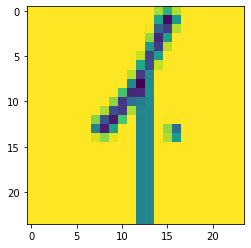

亻
亻 (0, 2, 10, 27)


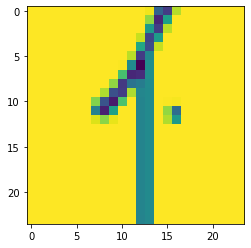

仔 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


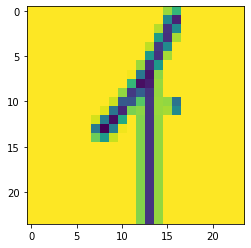

亻
亻 (0, 2, 10, 27)


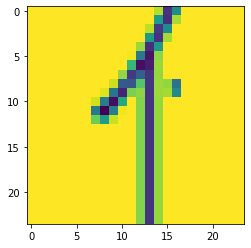

十
十 (14, 0, 24, 25)


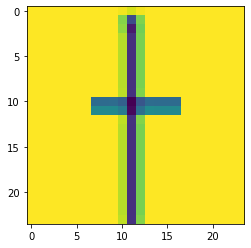

上
仕 {'亻': (0, 0, 10, 25), '十': (14, 0, 24, 25)}
他 {}
亻
亻 (0, 0, 10, 25)


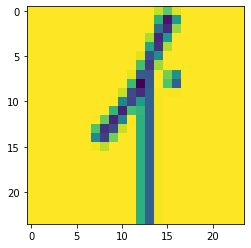

亻
亻 (0, 2, 10, 27)


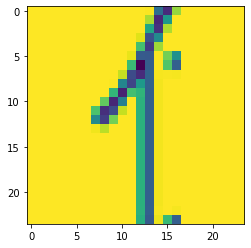

丈
丈
丈
仗 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


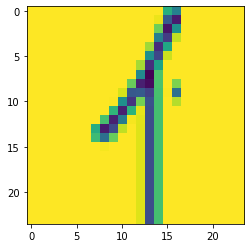

亻
亻 (0, 2, 10, 27)


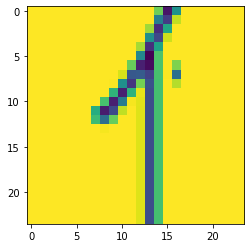

吋
卜
卜 (6, 2, 16, 27)


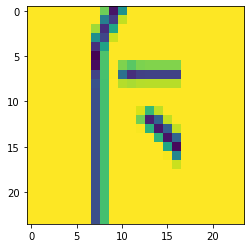

付 {'亻': (0, 0, 10, 25), '卜': (6, 2, 16, 27)}
亻
亻 (0, 0, 10, 25)


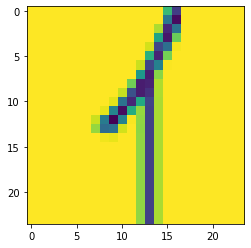

亻
亻 (0, 2, 10, 27)


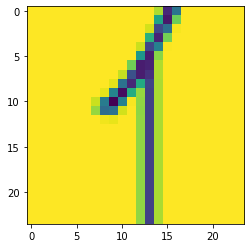

亻
亻 (2, 0, 12, 25)


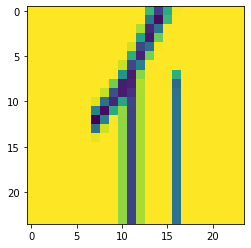

亻
亻 (2, 2, 12, 27)


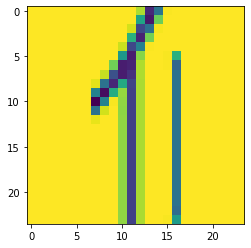

仙 {'亻': (0, 0, 10, 25)}
冫
冫 (0, 2, 10, 12)


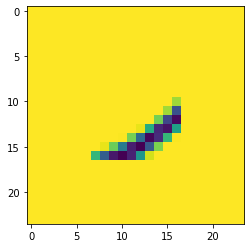

冫
冫 (2, 0, 12, 10)


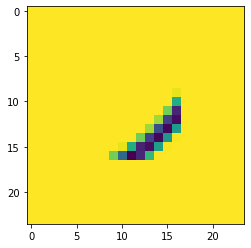

丘
亻
亻 (6, 0, 16, 25)


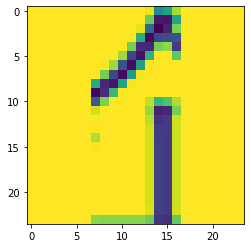

个
仚 {'冫': (0, 2, 10, 12), '亻': (6, 0, 16, 25)}
冫
冫 (0, 2, 10, 12)


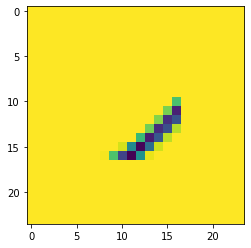

冫
冫 (2, 0, 12, 10)


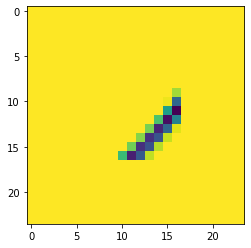

仝 {'冫': (0, 2, 10, 12)}
亻
亻 (0, 0, 10, 25)


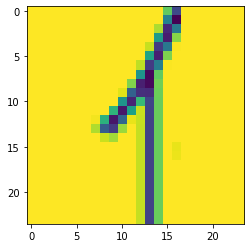

亻
亻 (0, 2, 10, 27)


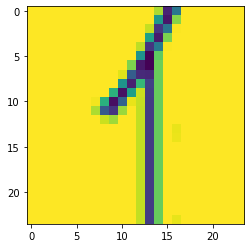

仞 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


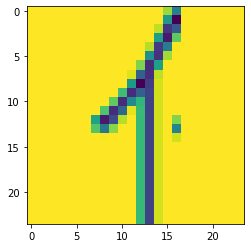

亻
亻 (0, 2, 10, 27)


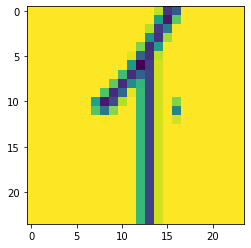

仟 {'亻': (0, 0, 10, 25)}
吃
仡 {}
亻
亻 (0, 0, 10, 25)


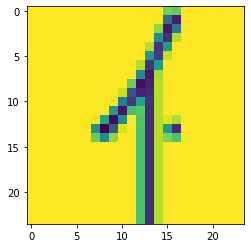

卩
卩 (6, 0, 16, 25)


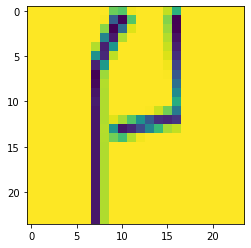

代 {'亻': (0, 0, 10, 25), '卩': (6, 0, 16, 25)}
冫
冫 (0, 2, 10, 12)


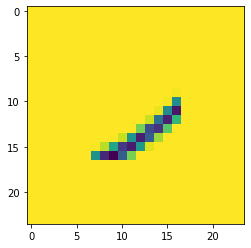

冫
冫 (2, 0, 12, 10)


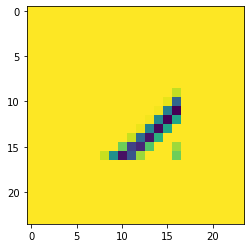

令
令
今
令 {'冫': (0, 2, 10, 12)}
以 {}
亻
亻 (0, 0, 10, 25)


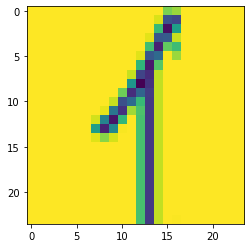

亻
亻 (0, 2, 10, 27)


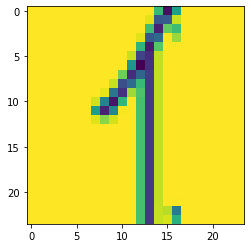

仨 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


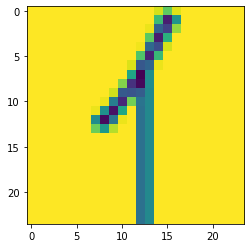

亻
亻 (0, 2, 10, 27)


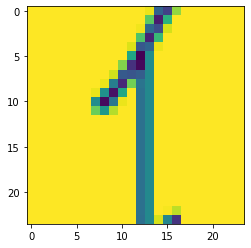

亻
亻 (2, 0, 12, 25)


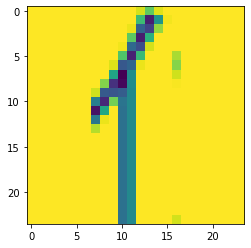

亻
亻 (2, 2, 12, 27)


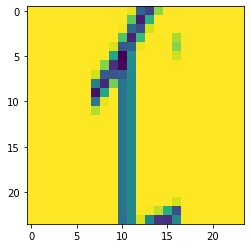

仪 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


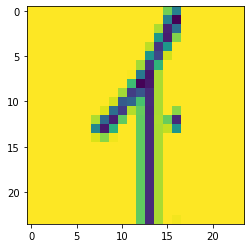

仫
么
么
么
么
仫 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


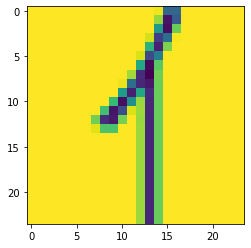

亻
亻 (0, 2, 10, 27)


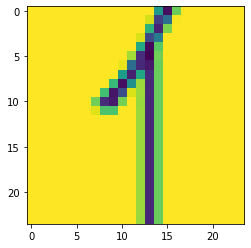

亻
亻 (2, 0, 12, 25)


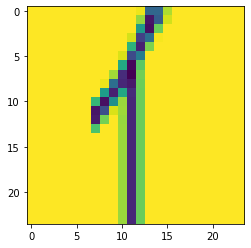

们 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


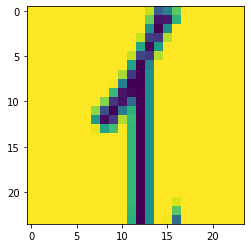

亻
亻 (0, 2, 10, 27)


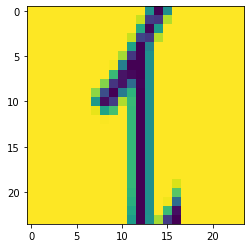

亻
亻 (2, 0, 12, 25)


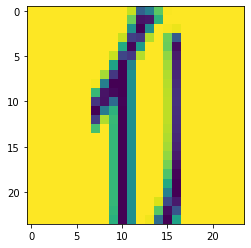

仮 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


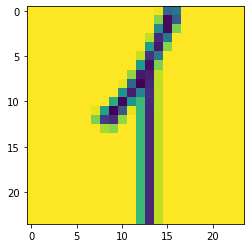

亻
亻 (0, 2, 10, 27)


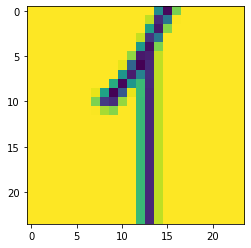

亻
亻 (2, 0, 12, 25)


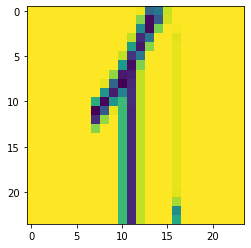

仰 {'亻': (0, 0, 10, 25)}
仫
囚
今
今
今
今
今
仱 {}
亻
亻 (0, 0, 10, 25)


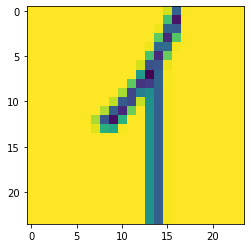

亻
亻 (0, 2, 10, 27)


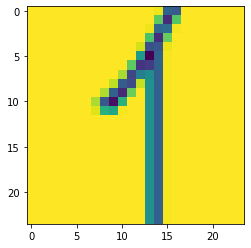

亻
亻 (2, 0, 12, 25)


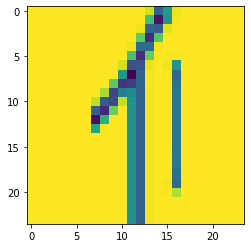

仲 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


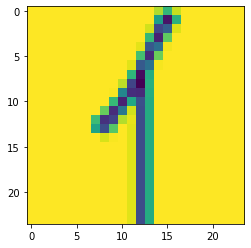

亻
亻 (0, 2, 10, 27)


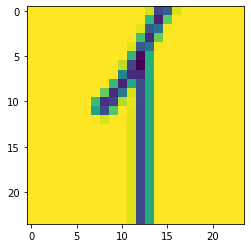

亻
亻 (2, 0, 12, 25)


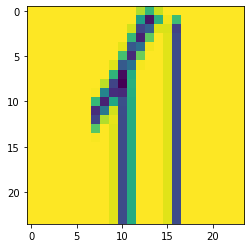

上
仳 {'亻': (0, 0, 10, 25)}
卩
卩 (4, 0, 14, 25)


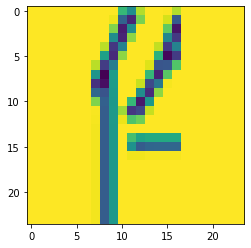

午
午
仵 {'卩': (4, 0, 14, 25)}
亻
亻 (0, 0, 10, 25)


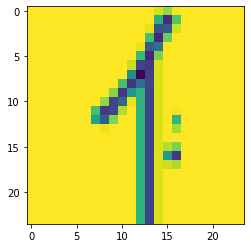

件 {'亻': (0, 0, 10, 25)}
亻
亻 (8, 0, 18, 25)


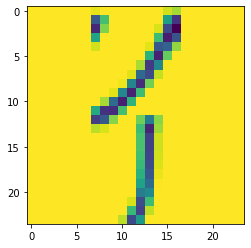

介
介
价 {'亻': (8, 0, 18, 25)}
亻
亻 (0, 0, 10, 25)


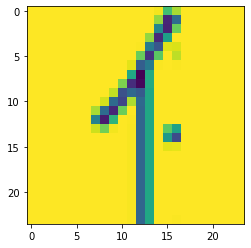

亻
亻 (0, 2, 10, 27)


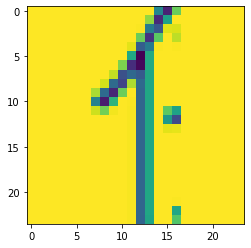

任 {'亻': (0, 0, 10, 25)}
份 {}
亻
亻 (0, 0, 10, 25)


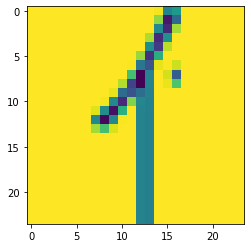

亻
亻 (0, 2, 10, 27)


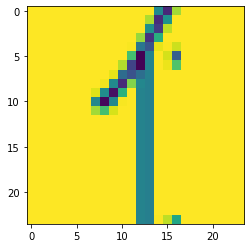

产
仿 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


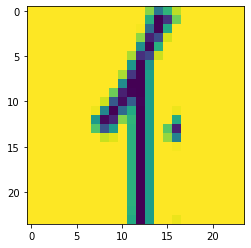

么
伀 {'亻': (0, 0, 10, 25)}
亻
亻 (4, 0, 14, 25)


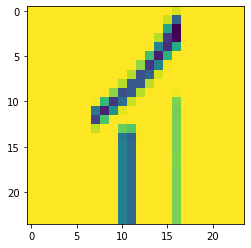

冫
冫 (4, 0, 14, 10)


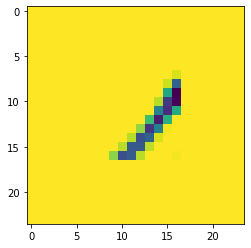

亻
亻 (4, 2, 14, 27)


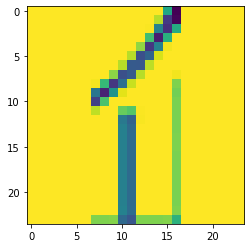

个
个
企 {'亻': (4, 0, 14, 25), '冫': (4, 0, 14, 10)}
亻
亻 (0, 0, 10, 25)


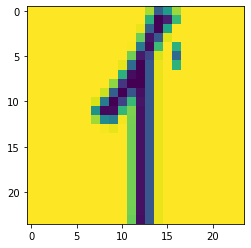

亻
亻 (0, 2, 10, 27)


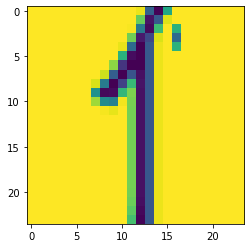

伂 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


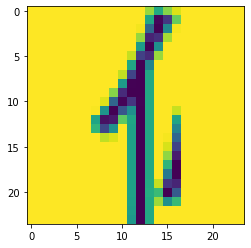

伈 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 2, 10, 27)


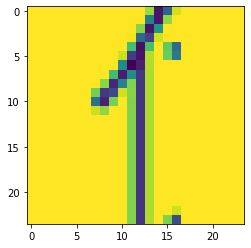

伉 {'亻': (0, 2, 10, 27)}
伊
伊 {}
亻
亻 (0, 0, 10, 25)


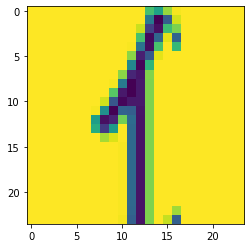

亻
亻 (0, 2, 10, 27)


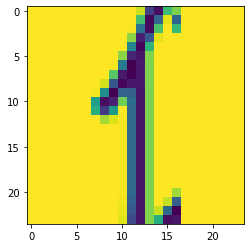

及
伋 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


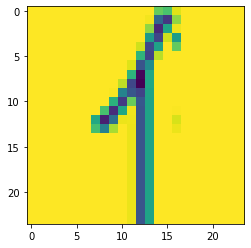

亻
亻 (0, 2, 10, 27)


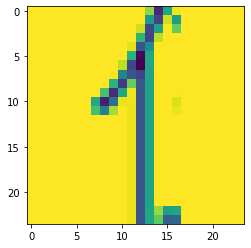

伍 {'亻': (0, 0, 10, 25)}
伎 {}
丬
丬 (8, 0, 18, 25)


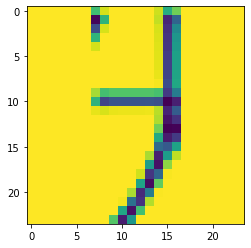

丬
丬 (8, 2, 18, 27)


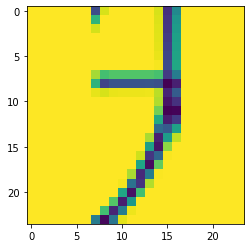

伏 {'丬': (8, 0, 18, 25)}
亻
亻 (0, 2, 10, 27)


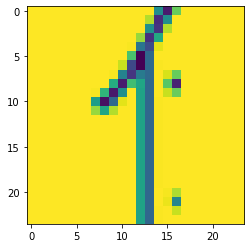

伐 {'亻': (0, 2, 10, 27)}
亻
亻 (0, 0, 10, 25)


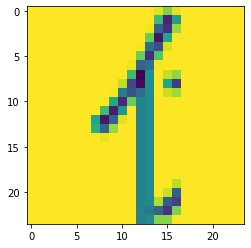

亻
亻 (0, 2, 10, 27)


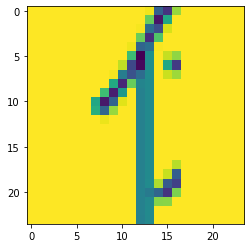

丬
丬 (8, 0, 18, 25)


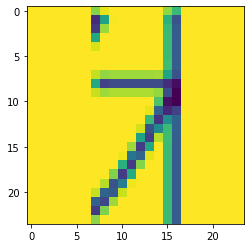

丬
丬 (8, 2, 18, 27)


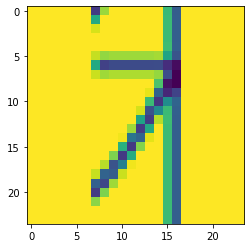

休 {'亻': (0, 0, 10, 25), '丬': (8, 0, 18, 25)}
亻
亻 (0, 0, 10, 25)


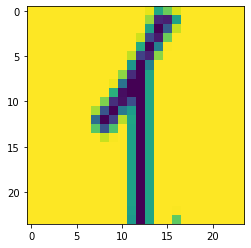

亻
亻 (0, 2, 10, 27)


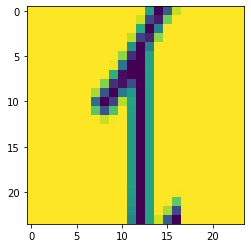

亻
亻 (2, 0, 12, 25)


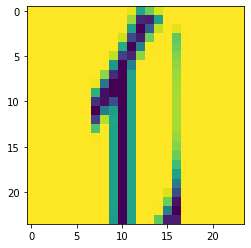

伒 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


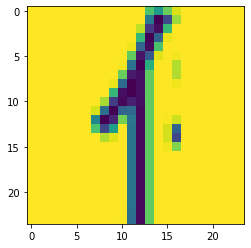

亻
亻 (0, 2, 10, 27)


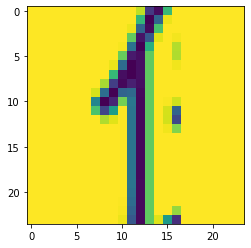

丬
丬 (8, 0, 18, 25)


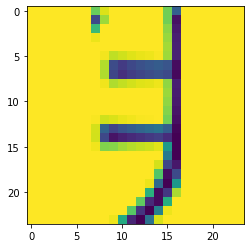

夫
伕 {'亻': (0, 0, 10, 25), '丬': (8, 0, 18, 25)}
众 {}
优 {}
亻
亻 (0, 2, 10, 27)


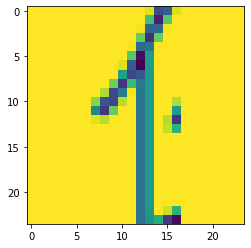

伙 {'亻': (0, 2, 10, 27)}
今
乡
会 {}
亻
亻 (0, 0, 10, 25)


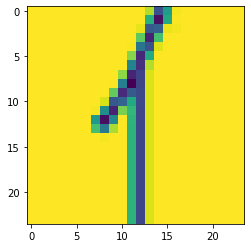

亻
亻 (0, 2, 10, 27)


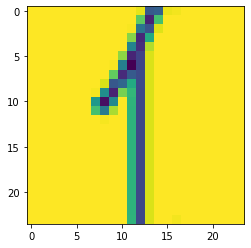

亻
亻 (2, 0, 12, 25)


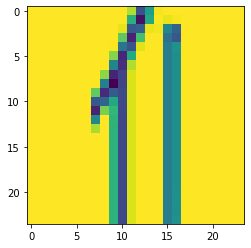

伛 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


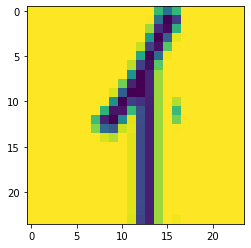

亻
亻 (0, 2, 10, 27)


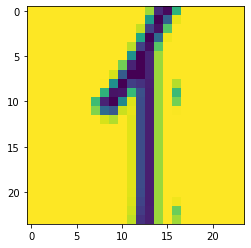

仁
仁
冫
冫 (8, 2, 18, 27)


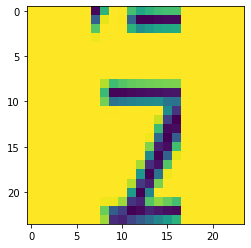

云
云
伝 {'亻': (0, 0, 10, 25), '冫': (8, 2, 18, 27)}
乎
乎
乎
个
伞 {}
亻
亻 (0, 0, 10, 25)


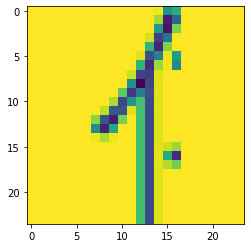

亻
亻 (0, 2, 10, 27)


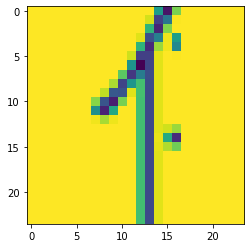

伟 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


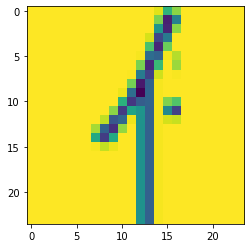

亻
亻 (0, 2, 10, 27)


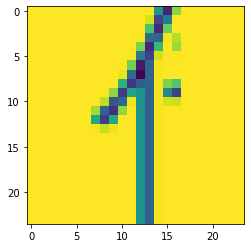

专
专
传 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


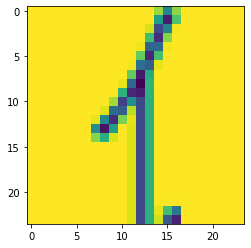

亻
亻 (0, 2, 10, 27)


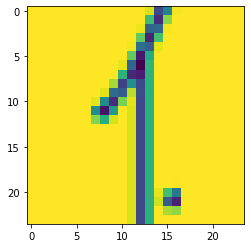

伢 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 2, 10, 27)


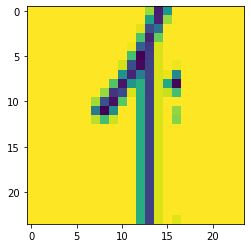

冫
冫 (8, 16, 18, 26)


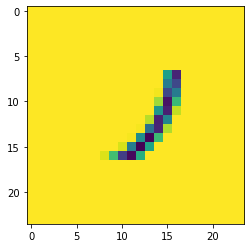

伤 {'亻': (0, 2, 10, 27), '冫': (8, 16, 18, 26)}
伥 {}
亻
亻 (8, 0, 18, 25)


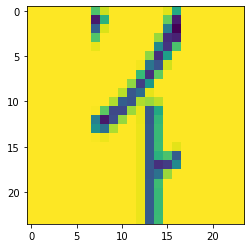

亻
亻 (8, 2, 18, 27)


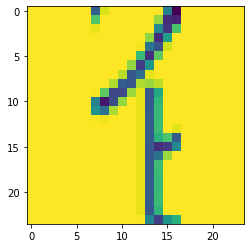

囚
仑
伦 {'亻': (8, 0, 18, 25)}
亻
亻 (8, 0, 18, 25)


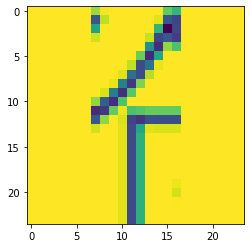

仓
伧 {'亻': (8, 0, 18, 25)}
亻
亻 (0, 0, 10, 25)


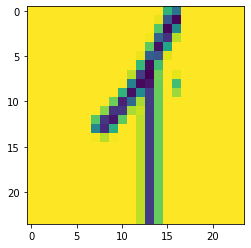

亻
亻 (0, 2, 10, 27)


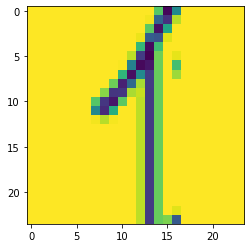

仿
冫
冫 (8, 14, 18, 24)


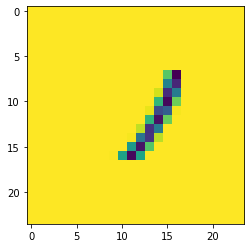

丬
丬 (10, 0, 20, 25)


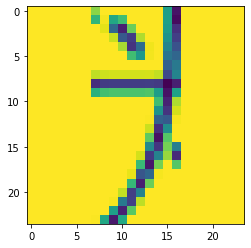

伪 {'亻': (0, 0, 10, 25), '冫': (8, 14, 18, 24), '丬': (10, 0, 20, 25)}
亻
亻 (0, 0, 10, 25)


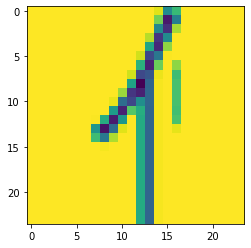

亻
亻 (0, 2, 10, 27)


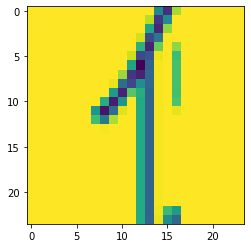

伫 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


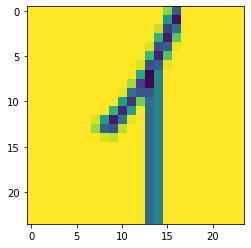

亻
亻 (0, 2, 10, 27)


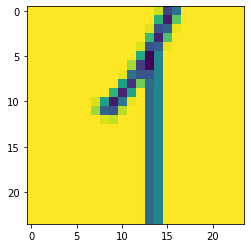

亻
亻 (2, 0, 12, 25)


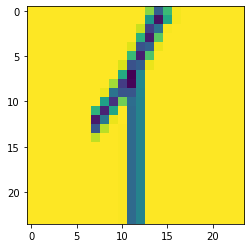

亻
亻 (2, 2, 12, 27)


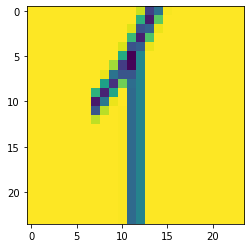

伯 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


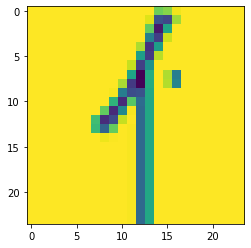

亻
亻 (0, 2, 10, 27)


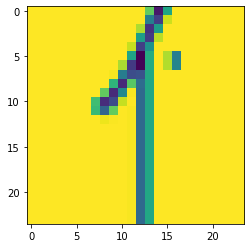

估 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


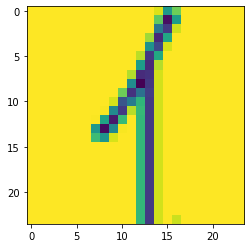

亻
亻 (0, 2, 10, 27)


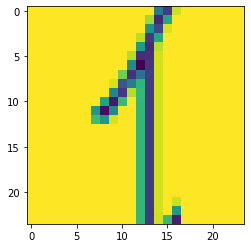

亻
亻 (2, 0, 12, 25)


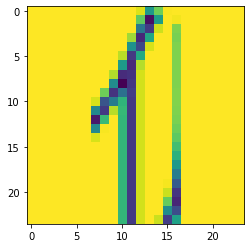

亻
亻 (2, 2, 12, 27)


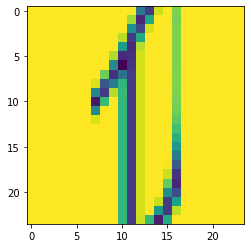

伲 {'亻': (0, 0, 10, 25)}
咻
世
伳 {}
亻
亻 (0, 0, 10, 25)


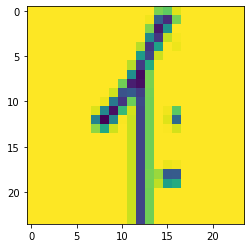

呼
半
半
伴 {'亻': (0, 0, 10, 25)}
令
今
伶 {}
亻
亻 (0, 0, 10, 25)


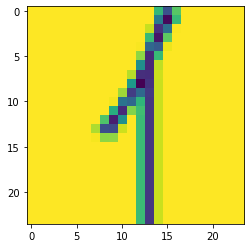

亻
亻 (0, 2, 10, 27)


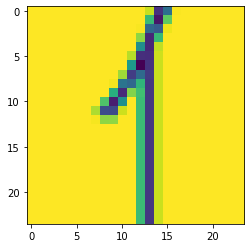

伸 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


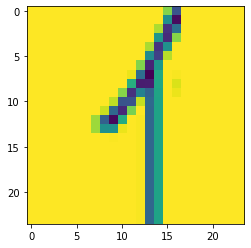

亻
亻 (0, 2, 10, 27)


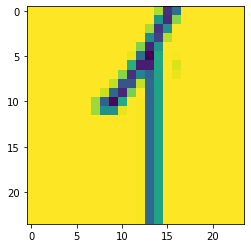

伺 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


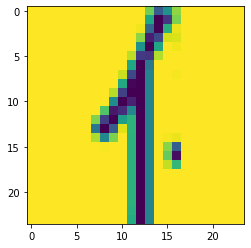

亻
亻 (0, 2, 10, 27)


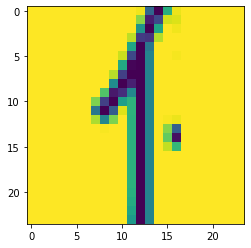

个
哑
呼
丹
伻 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


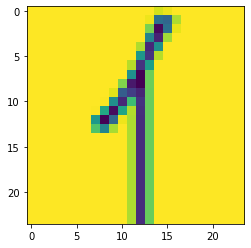

亻
亻 (0, 2, 10, 27)


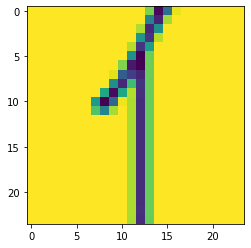

上
上
似 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


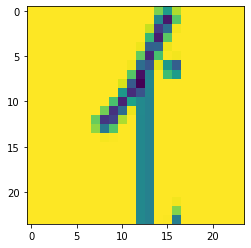

亻
亻 (0, 2, 10, 27)


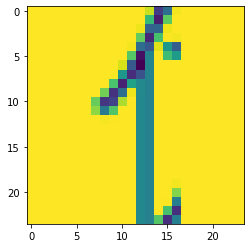

亻
亻 (2, 0, 12, 25)


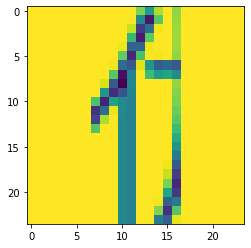

伽 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


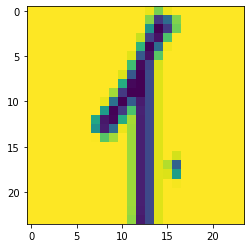

亻
亻 (0, 2, 10, 27)


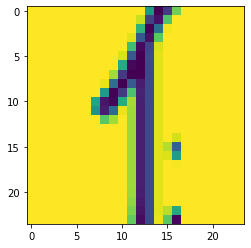

丕
不
丕
伾 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 2, 10, 27)


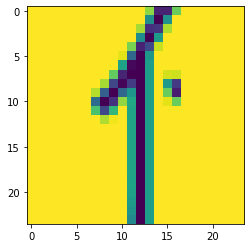

佁 {'亻': (0, 2, 10, 27)}
亻
亻 (0, 0, 10, 25)


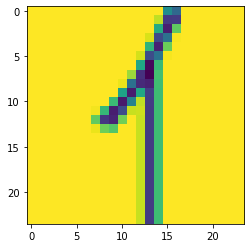

亻
亻 (0, 2, 10, 27)


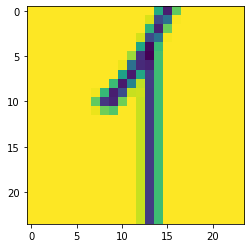

亻
亻 (2, 0, 12, 25)


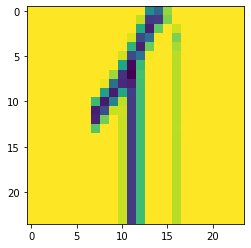

亻
亻 (2, 2, 12, 27)


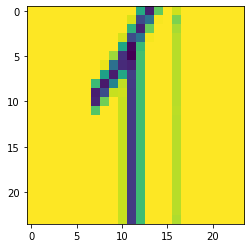

佃 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


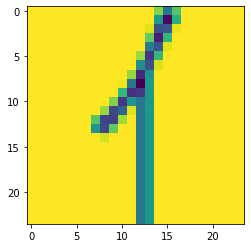

亻
亻 (0, 2, 10, 27)


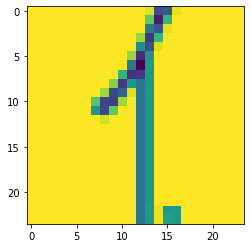

亻
亻 (2, 2, 12, 27)


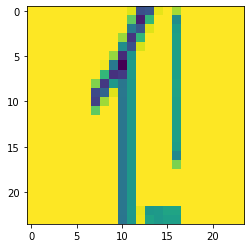

但 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


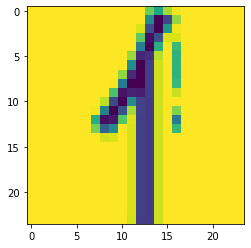

亍
卞
佇 {'亻': (0, 0, 10, 25)}
个
佈 {}
亻
亻 (0, 0, 10, 25)


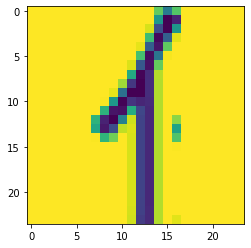

亻
亻 (0, 2, 10, 27)


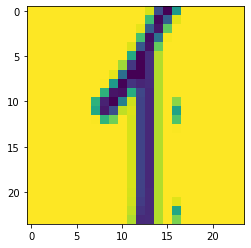

去
佉 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


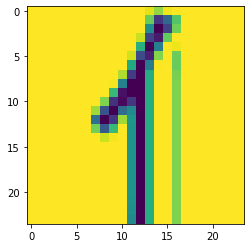

亻
亻 (0, 2, 10, 27)


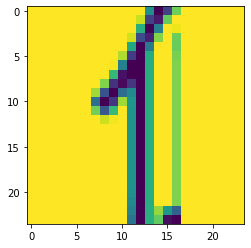

亻
亻 (2, 0, 12, 25)


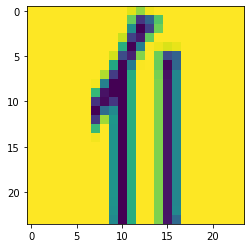

亻
亻 (2, 2, 12, 27)


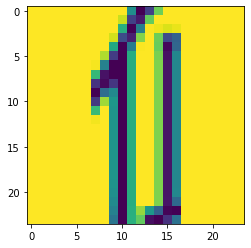

业
业 (8, 2, 18, 27)


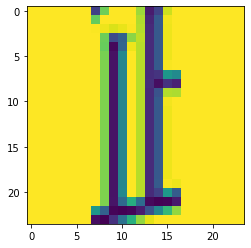

佌 {'亻': (0, 0, 10, 25), '业': (8, 2, 18, 27)}
亻
亻 (0, 0, 10, 25)


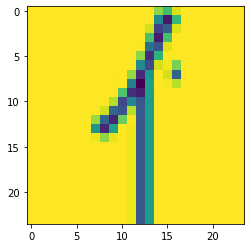

亻
亻 (0, 2, 10, 27)


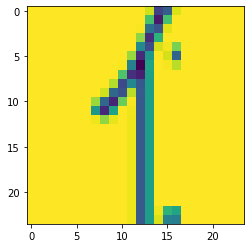

冫
冫 (16, 0, 26, 25)


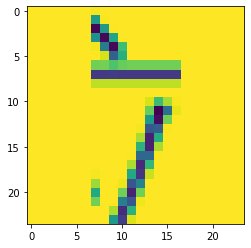

位 {'亻': (0, 0, 10, 25), '冫': (16, 0, 26, 25)}
亻
亻 (0, 0, 10, 25)


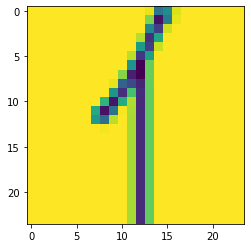

亻
亻 (0, 2, 10, 27)


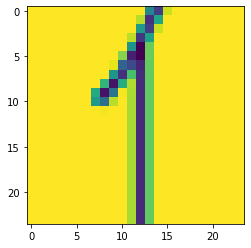

低 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


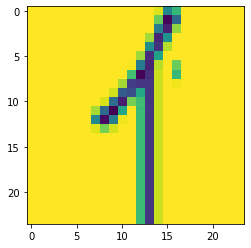

亻
亻 (0, 2, 10, 27)


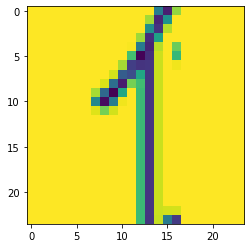

主
主
住 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


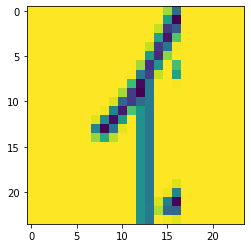

亻
亻 (0, 2, 10, 27)


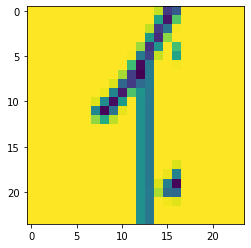

咿
佐 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


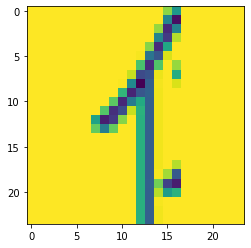

亻
亻 (0, 2, 10, 27)


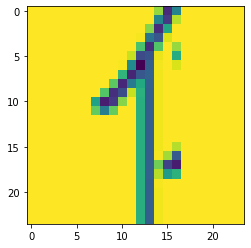

个
佑 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 2, 10, 27)


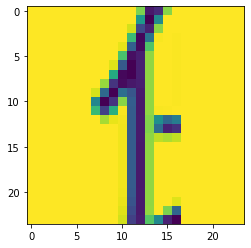

呸
夬
佒 {'亻': (0, 2, 10, 27)}
体 {}
亻
亻 (0, 0, 10, 25)


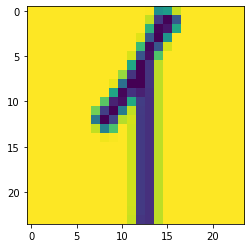

亻
亻 (0, 2, 10, 27)


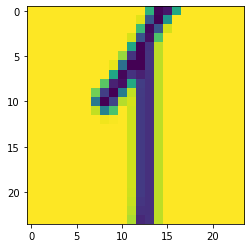

亻
亻 (2, 0, 12, 25)


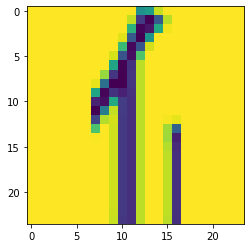

占
占
佔 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


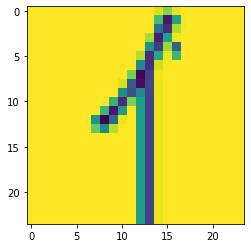

亻
亻 (0, 2, 10, 27)


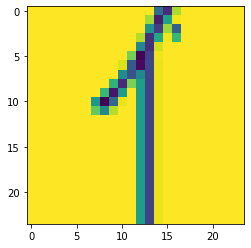

何 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


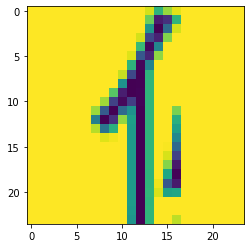

亻
亻 (0, 2, 10, 27)


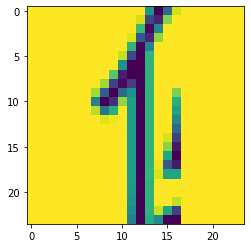

佖 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


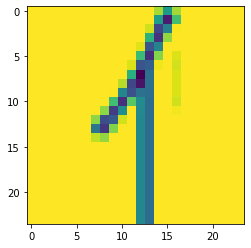

亻
亻 (0, 2, 10, 27)


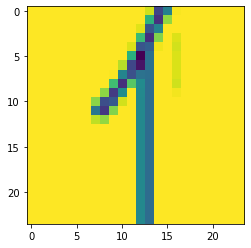

卞
佗 {'亻': (0, 0, 10, 25)}
冫
冫 (2, 0, 12, 10)


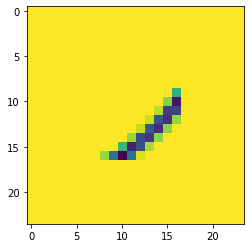

佘 {'冫': (2, 0, 12, 10)}
冫
冫 (2, 0, 12, 10)


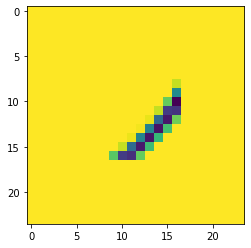

全
乡
余 {'冫': (2, 0, 12, 10)}
佚 {}
亻
亻 (0, 0, 10, 25)


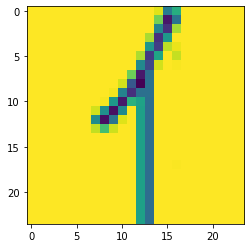

亻
亻 (0, 2, 10, 27)


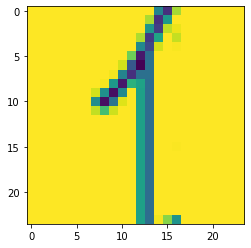

佛 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


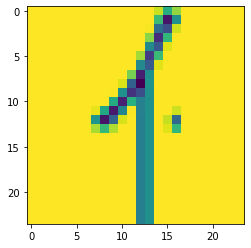

亻
亻 (0, 2, 10, 27)


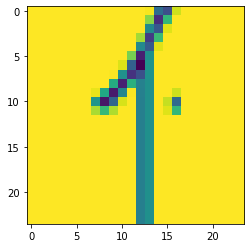

亻
亻 (8, 0, 18, 25)


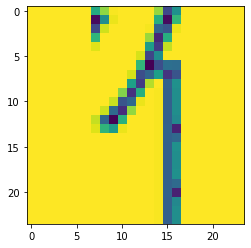

亻
亻 (8, 2, 18, 27)


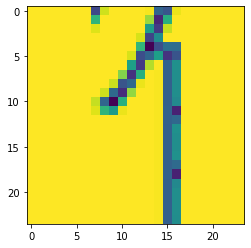

乍
作 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


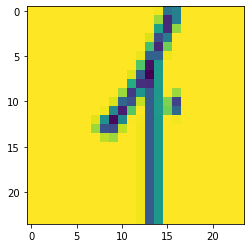

佝 {'亻': (0, 0, 10, 25)}
佞 {}
亻
亻 (0, 0, 10, 25)


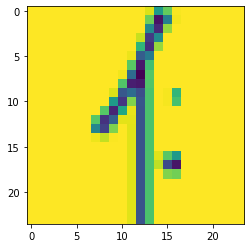

冬
冬
佟 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


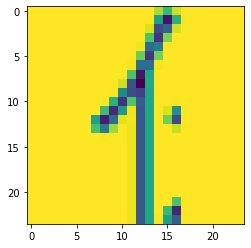

你 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


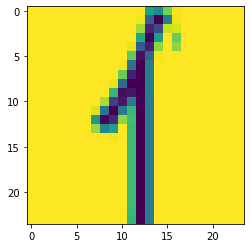

亻
亻 (0, 2, 10, 27)


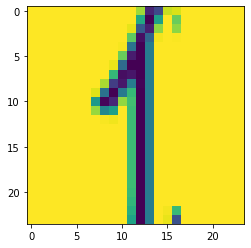

佢 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


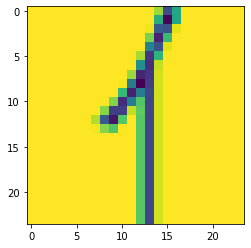

亻
亻 (0, 2, 10, 27)


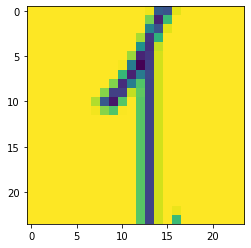

亻
亻 (2, 0, 12, 25)


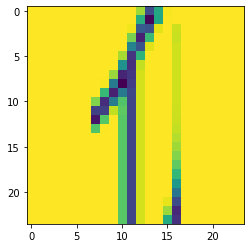

亻
亻 (2, 2, 12, 27)


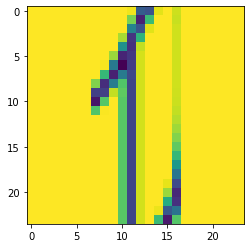

佣 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


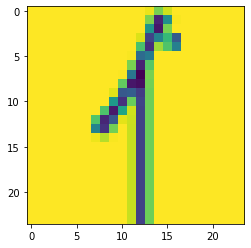

亻
亻 (0, 2, 10, 27)


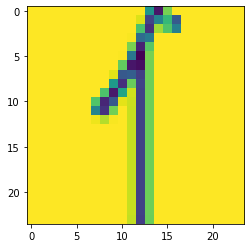

佤 {'亻': (0, 0, 10, 25)}
冫
冫 (2, 0, 12, 10)


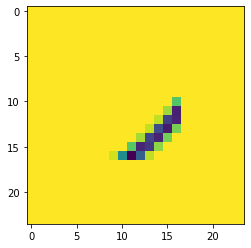

今
佥 {'冫': (2, 0, 12, 10)}
亻
亻 (0, 0, 10, 25)


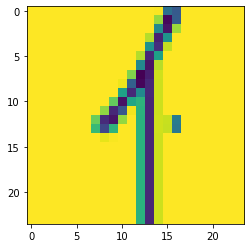

亻
亻 (0, 2, 10, 27)


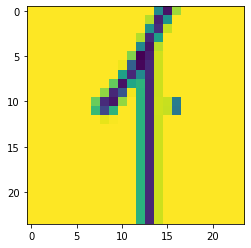

丬
丬 (8, 0, 18, 25)


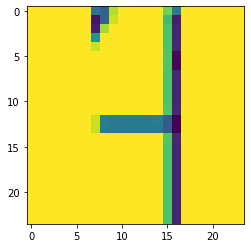

卡
卡
卡
卡
佧 {'亻': (0, 0, 10, 25), '丬': (8, 0, 18, 25)}
亻
亻 (0, 0, 10, 25)


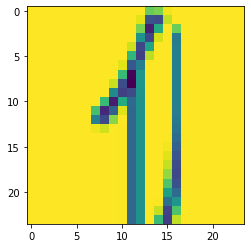

亻
亻 (0, 2, 10, 27)


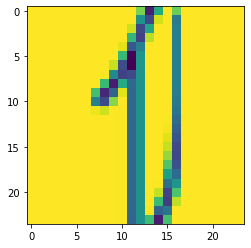

佩 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


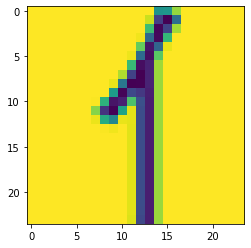

亻
亻 (0, 2, 10, 27)


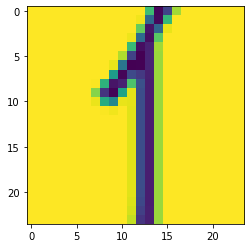

佪 {'亻': (0, 0, 10, 25)}
佬 {}
佮 {}
亻
亻 (0, 0, 10, 25)


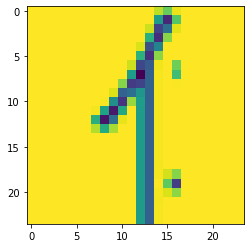

亻
亻 (0, 2, 10, 27)


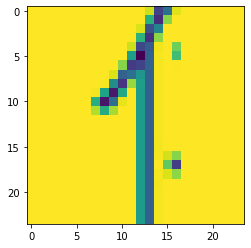

佯 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


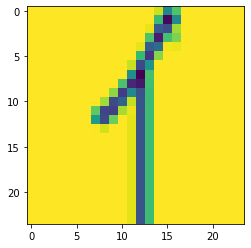

亻
亻 (0, 2, 10, 27)


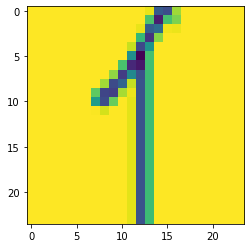

介
佰 {'亻': (0, 0, 10, 25)}
佳 {}
亻
亻 (0, 0, 10, 25)


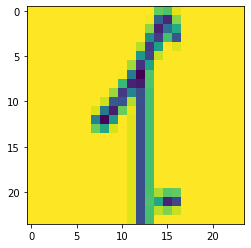

亻
亻 (0, 2, 10, 27)


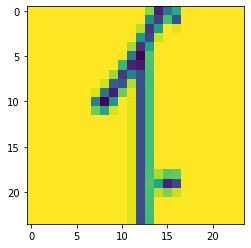

佴 {'亻': (0, 0, 10, 25)}
併 {}
亻
亻 (0, 0, 10, 25)


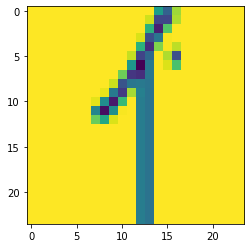

亻
亻 (0, 2, 10, 27)


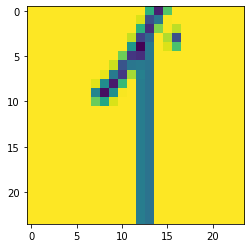

佶 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


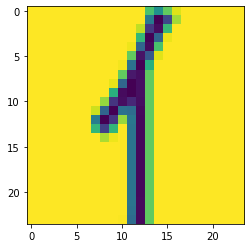

亻
亻 (0, 2, 10, 27)


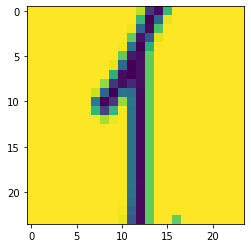

上
卡
佷 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


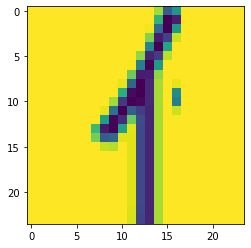

亻
亻 (0, 2, 10, 27)


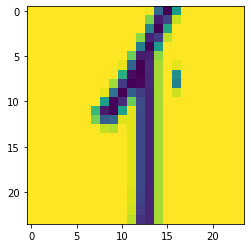

佸 {'亻': (0, 0, 10, 25)}
匹
危
佹 {}
刍
全
全
佺 {}
个
丬
丬 (6, 0, 16, 25)


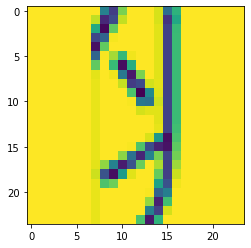

丬
丬 (6, 2, 16, 27)


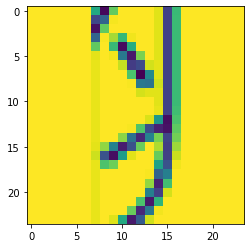

丬
丬 (8, 2, 18, 27)


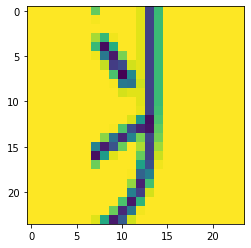

佻 {'丬': (6, 0, 16, 25)}
交
佼 {}
亻
亻 (0, 0, 10, 25)


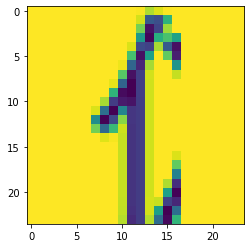

亻
亻 (0, 2, 10, 27)


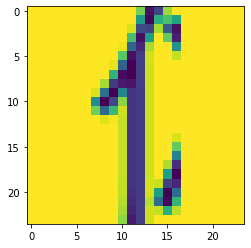

吵
个
呸
冫
冫 (6, 2, 16, 27)


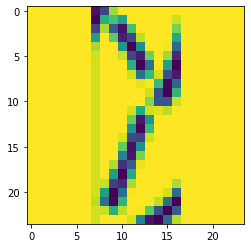

久
佽 {'亻': (0, 0, 10, 25), '冫': (6, 2, 16, 27)}
佾 {}
亻
亻 (0, 0, 10, 25)


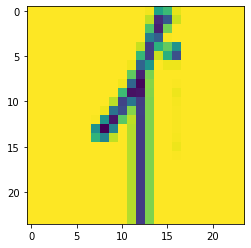

亻
亻 (0, 2, 10, 27)


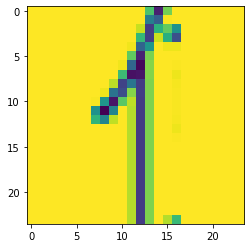

使 {'亻': (0, 0, 10, 25)}
吐
侁 {}
亻
亻 (0, 0, 10, 25)


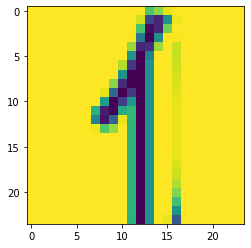

亻
亻 (0, 2, 10, 27)


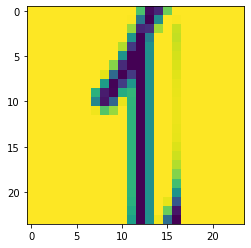

侂 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


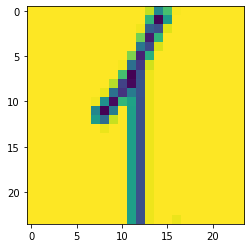

亻
亻 (0, 2, 10, 27)


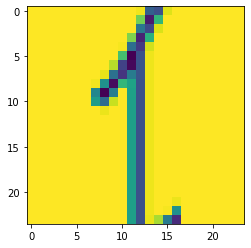

侃 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


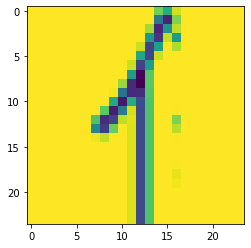

亻
亻 (0, 2, 10, 27)


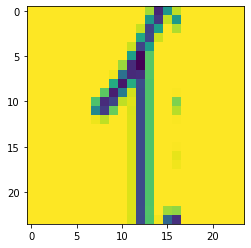

侄 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


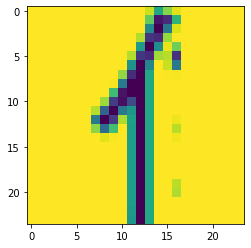

亻
亻 (0, 2, 10, 27)


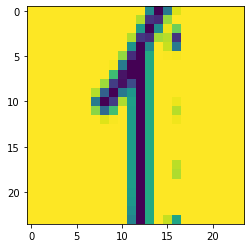

亥
亥
侅 {'亻': (0, 0, 10, 25)}
丞
个
來 {}
亻
亻 (0, 0, 10, 25)


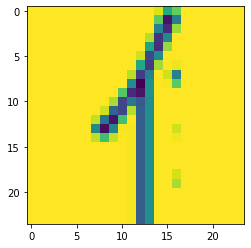

亻
亻 (0, 2, 10, 27)


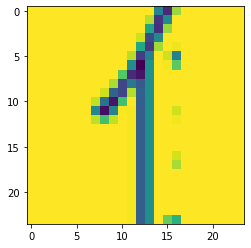

多
多
多
侈 {'亻': (0, 0, 10, 25)}
侉 {}
亻
亻 (0, 0, 10, 25)


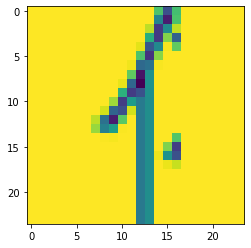

例 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


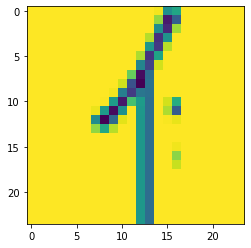

亻
亻 (0, 2, 10, 27)


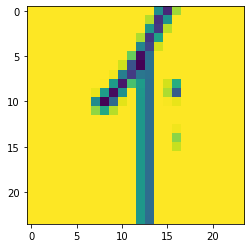

侍 {'亻': (0, 0, 10, 25)}
卡
卡
侏 {}
亻
亻 (0, 0, 10, 25)


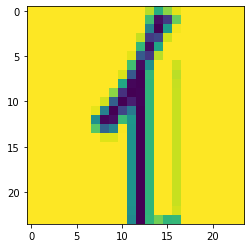

亻
亻 (0, 2, 10, 27)


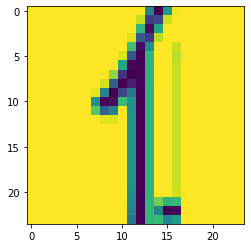

亻
亻 (2, 0, 12, 25)


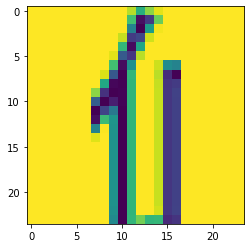

亻
亻 (2, 2, 12, 27)


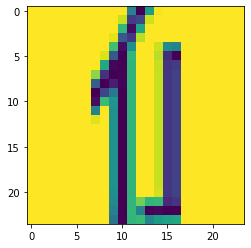

侐
侐 {'亻': (0, 0, 10, 25)}
侑 {}
侒 {}
亻
亻 (0, 0, 10, 25)


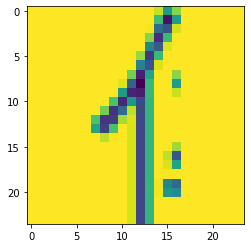

亻
亻 (0, 2, 10, 27)


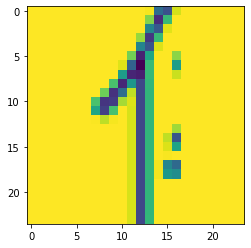

侔 {'亻': (0, 0, 10, 25)}
今
声
呈
侖 {}
亻
亻 (0, 0, 10, 25)


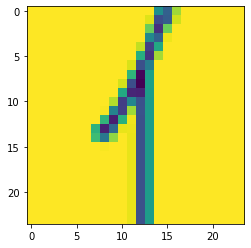

亻
亻 (0, 2, 10, 27)


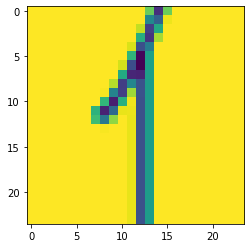

亻
亻 (2, 0, 12, 25)


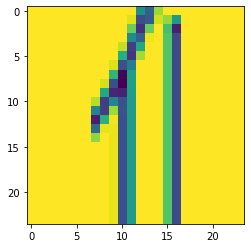

侗 {'亻': (0, 0, 10, 25)}
回
侘 {}
亻
亻 (0, 0, 10, 25)


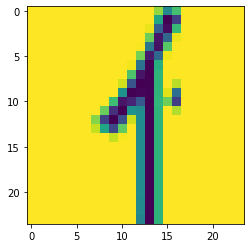

亻
亻 (0, 2, 10, 27)


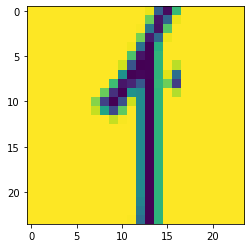

侚 {'亻': (0, 0, 10, 25)}
供 {}
亻
亻 (0, 0, 10, 25)


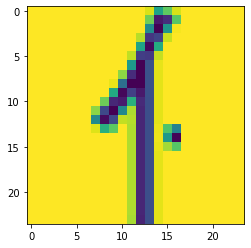

亻
亻 (0, 2, 10, 27)


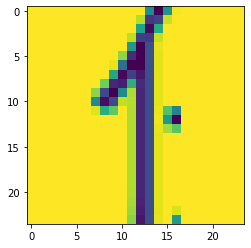

侜 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


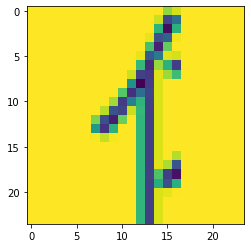

亻
亻 (0, 2, 10, 27)


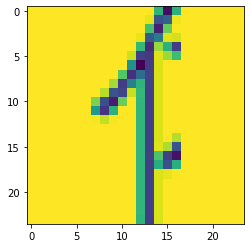

个
依 {'亻': (0, 0, 10, 25)}
妆
侞 {}
呼
侠 {}
亻
亻 (0, 0, 10, 25)


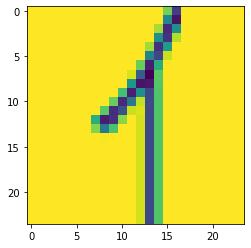

亻
亻 (0, 2, 10, 27)


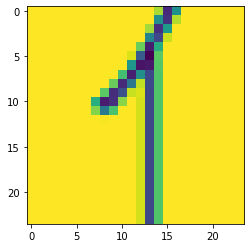

亻
亻 (2, 0, 12, 25)


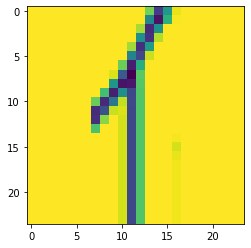

亻
亻 (2, 2, 12, 27)


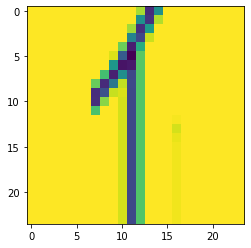

侣 {'亻': (0, 0, 10, 25)}
侥 {}
亻
亻 (0, 0, 10, 25)


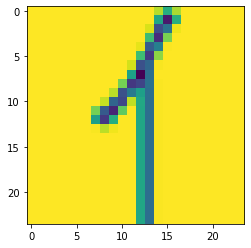

亻
亻 (0, 2, 10, 27)


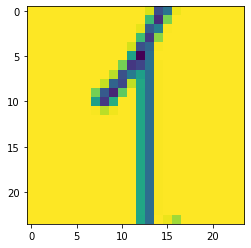

亻
亻 (2, 0, 12, 25)


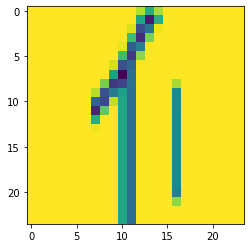

侦 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


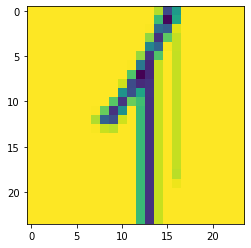

亻
亻 (0, 2, 10, 27)


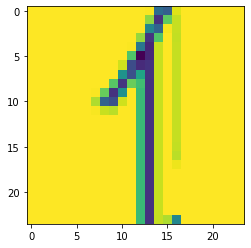

侧 {'亻': (0, 0, 10, 25)}
侨 {}
会
侩 {}
亻
亻 (0, 0, 10, 25)


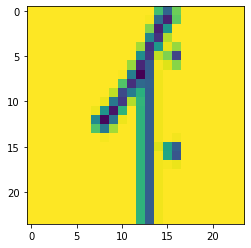

侪 {'亻': (0, 0, 10, 25)}
侫 {}
咻
农
侬 {}
侮 {}
侯 {}
亻
亻 (0, 0, 10, 25)


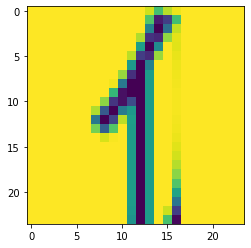

亻
亻 (0, 2, 10, 27)


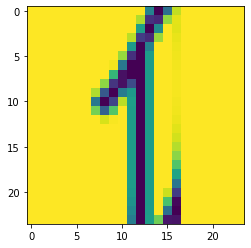

亻
亻 (2, 0, 12, 25)


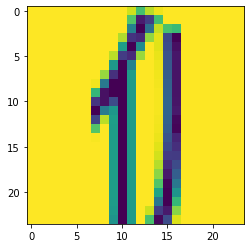

侲 {'亻': (0, 0, 10, 25)}
受
受
侵 {}
亻
亻 (0, 0, 10, 25)


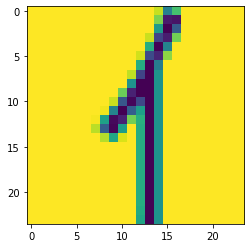

亻
亻 (0, 2, 10, 27)


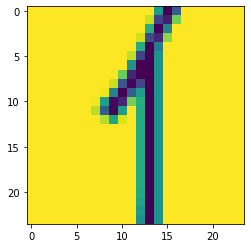

亻
亻 (2, 0, 12, 25)


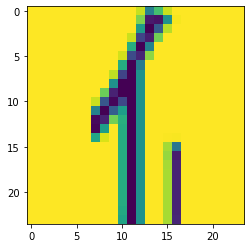

亻
亻 (2, 2, 12, 27)


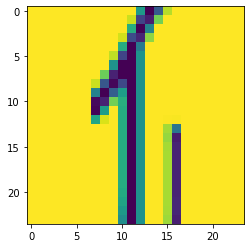

侶 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


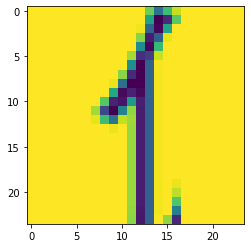

亻
亻 (0, 2, 10, 27)


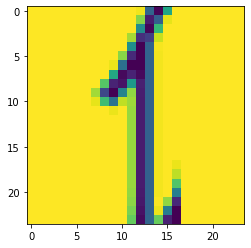

亻
亻 (2, 0, 12, 25)


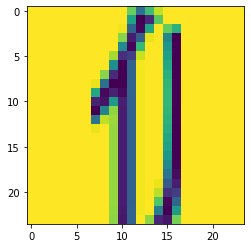

冒
侷 {'亻': (0, 0, 10, 25)}
侹 {}
亻
亻 (0, 0, 10, 25)


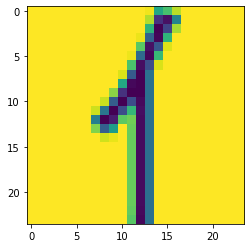

亻
亻 (0, 2, 10, 27)


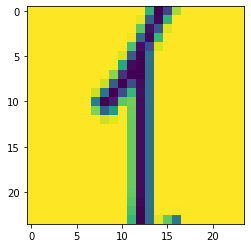

停
侻 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


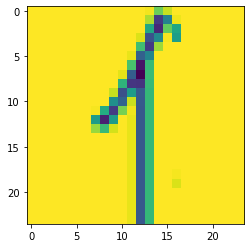

亻
亻 (0, 2, 10, 27)


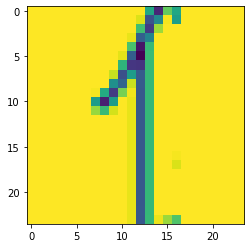

便 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 2, 10, 27)


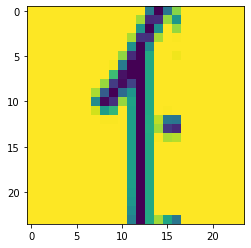

俀 {'亻': (0, 2, 10, 27)}
俁 {}
亻
亻 (0, 0, 10, 25)


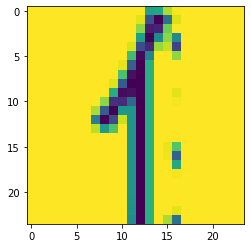

亻
亻 (0, 2, 10, 27)


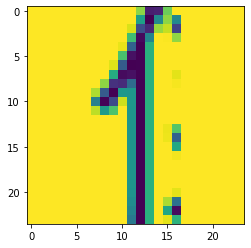

係 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


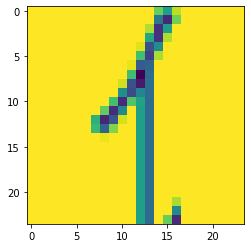

亻
亻 (0, 2, 10, 27)


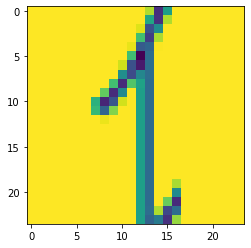

亻
亻 (2, 0, 12, 25)


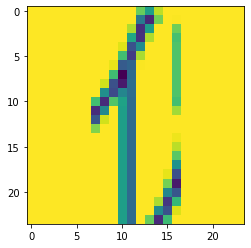

促 {'亻': (0, 0, 10, 25)}
俄 {}
亻
亻 (0, 0, 10, 25)


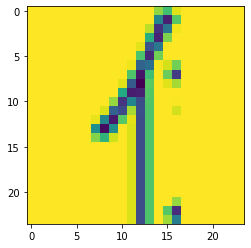

亻
亻 (0, 2, 10, 27)


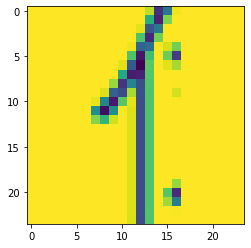

卡
俅 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


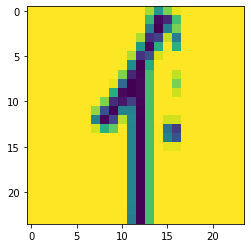

唔
俉 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


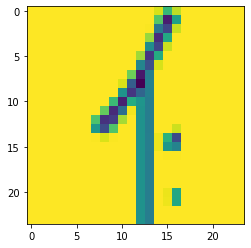

亻
亻 (0, 2, 10, 27)


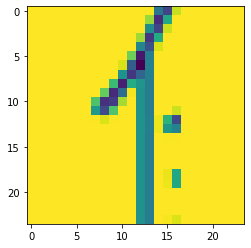

俊 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


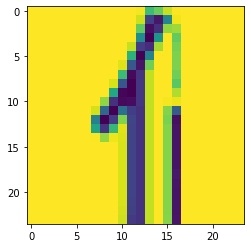

亻
亻 (0, 2, 10, 27)


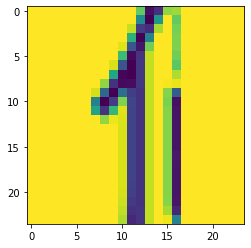

俋
俋 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


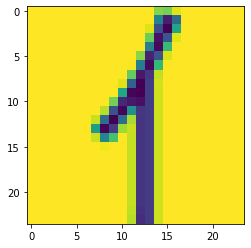

亻
亻 (0, 2, 10, 27)


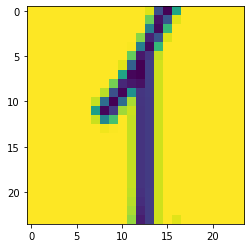

卡
俍 {'亻': (0, 0, 10, 25)}
俎 {}
亻
亻 (0, 0, 10, 25)


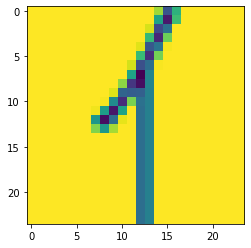

亻
亻 (0, 2, 10, 27)


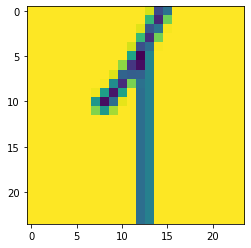

卞
俏 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


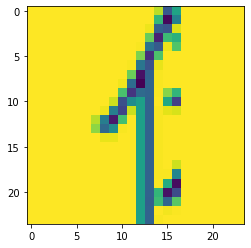

咿
俐 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


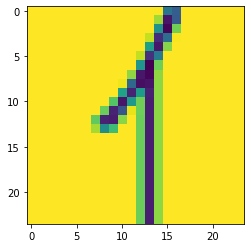

亻
亻 (0, 2, 10, 27)


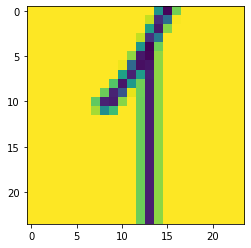

亻
亻 (2, 0, 12, 25)


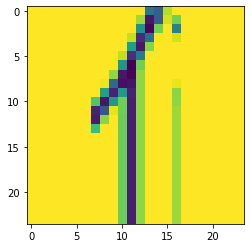

俑 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


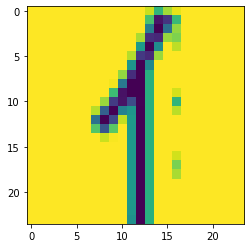

亻
亻 (0, 2, 10, 27)


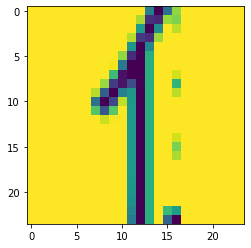

俓
俓 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


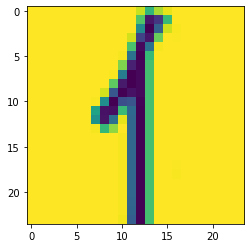

亻
亻 (0, 2, 10, 27)


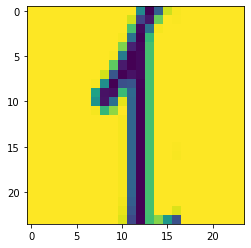

写
俔 {'亻': (0, 0, 10, 25)}
俗 {}
亻
亻 (0, 0, 10, 25)


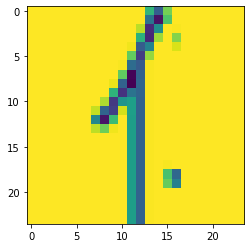

亻
亻 (0, 2, 10, 27)


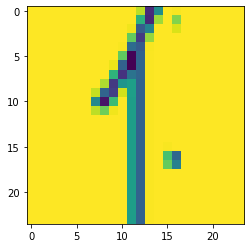

俘 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


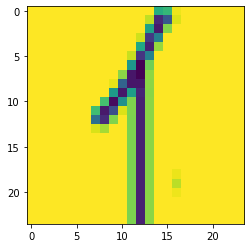

亻
亻 (0, 2, 10, 27)


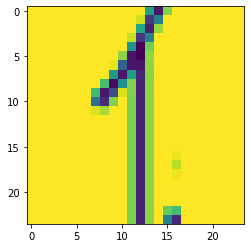

俚 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


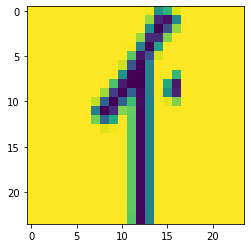

亻
亻 (0, 2, 10, 27)


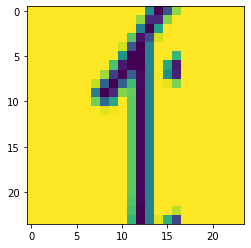

乡
俛 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


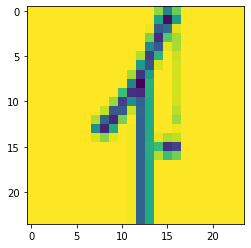

俜 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


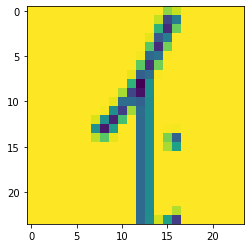

亻
亻 (0, 2, 10, 27)


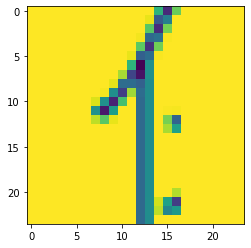

呆
保 {'亻': (0, 0, 10, 25)}
今
冒
俞
俞
俞 {}
亻
亻 (0, 0, 10, 25)


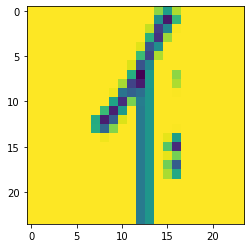

俟 {'亻': (0, 0, 10, 25)}
个
俠 {}
亻
亻 (0, 0, 10, 25)


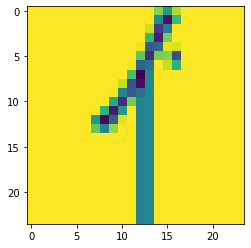

亻
亻 (0, 2, 10, 27)


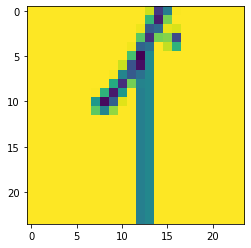

信 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


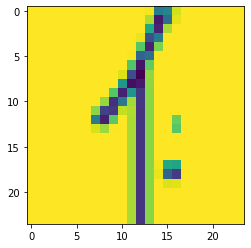

亻
亻 (0, 2, 10, 27)


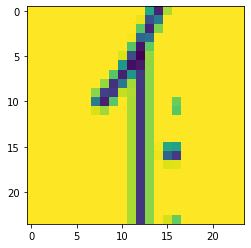

俣 {'亻': (0, 0, 10, 25)}
俦 {}
亻
亻 (0, 0, 10, 25)


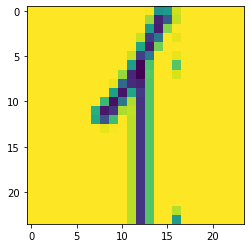

亻
亻 (0, 2, 10, 27)


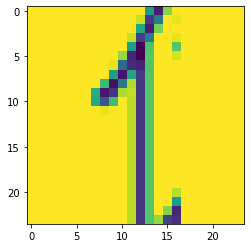

严
俨 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


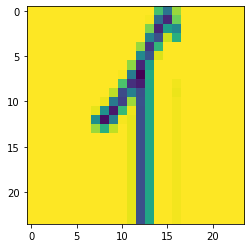

亻
亻 (0, 2, 10, 27)


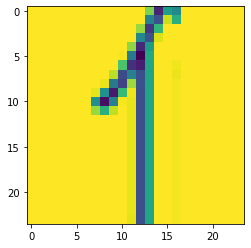

俩 {'亻': (0, 0, 10, 25)}
俪 {}
咿
咿
叵
俬 {}
佥
俭 {}
亻
亻 (0, 0, 10, 25)


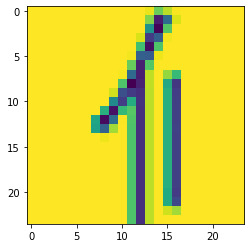

修 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


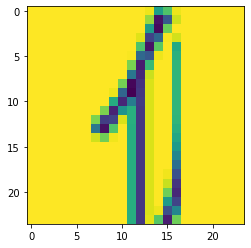

亻
亻 (0, 2, 10, 27)


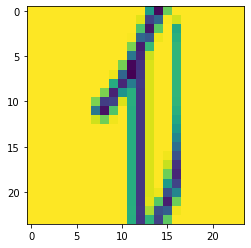

俯 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


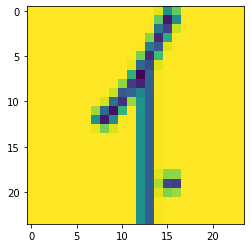

亻
亻 (0, 2, 10, 27)


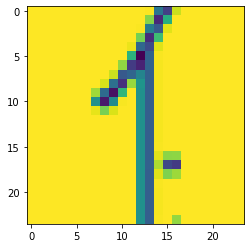

俱 {'亻': (0, 0, 10, 25)}
俳 {}
亻
亻 (0, 0, 10, 25)


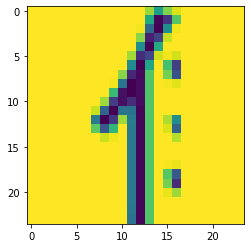

俴 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


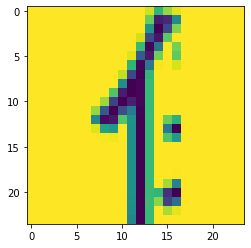

俵
俵 {'亻': (0, 0, 10, 25)}
叔
叔
俶 {}
俸 {}
俺 {}
亻
亻 (0, 0, 10, 25)


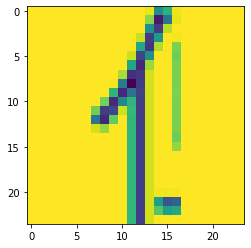

亻
亻 (0, 2, 10, 27)


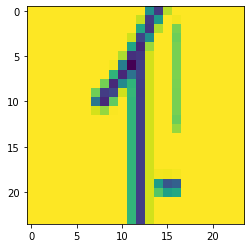

俾 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


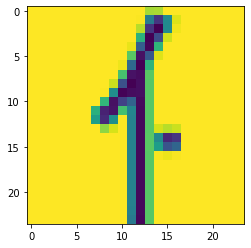

卡
倀 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


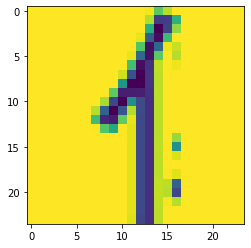

亻
亻 (0, 2, 10, 27)


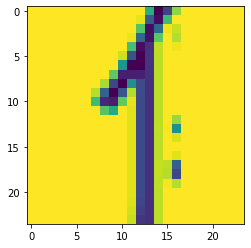

唑
倅 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


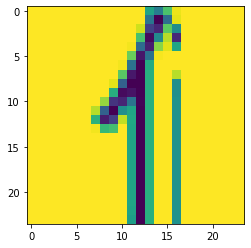

亻
亻 (0, 2, 10, 27)


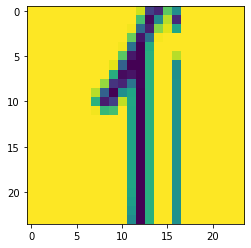

侐
倆 {'亻': (0, 0, 10, 25)}
个
倇 {}
今
今
乍
含
今
享
倉 {}
亻
亻 (0, 0, 10, 25)


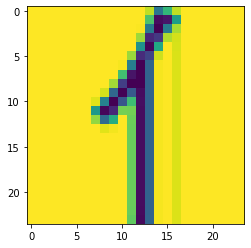

亻
亻 (0, 2, 10, 27)


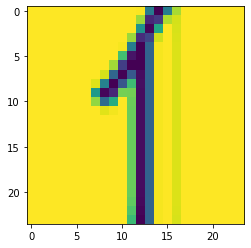

亻
亻 (2, 0, 12, 25)


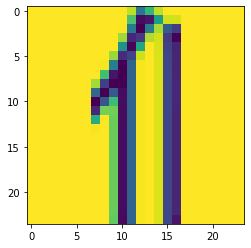

亻
亻 (2, 2, 12, 27)


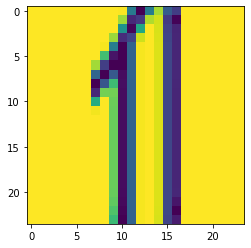

固
個 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 2, 10, 27)


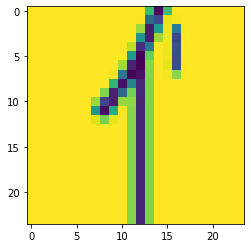

倌 {'亻': (0, 2, 10, 27)}
位
倍 {}
亻
亻 (0, 0, 10, 25)


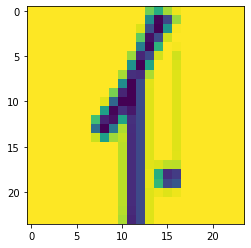

亻
亻 (0, 2, 10, 27)


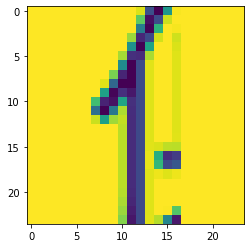

倎 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


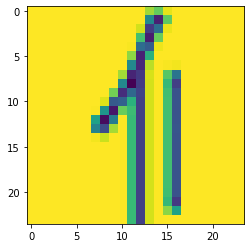

倏 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


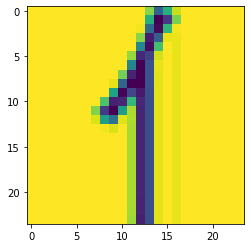

亻
亻 (0, 2, 10, 27)


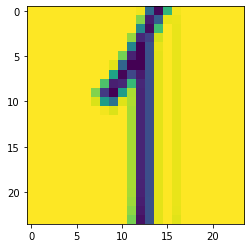

亻
亻 (2, 0, 12, 25)


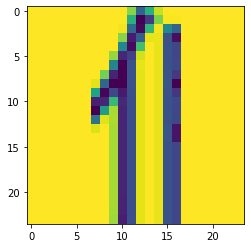

卩
卩 (10, 2, 20, 27)


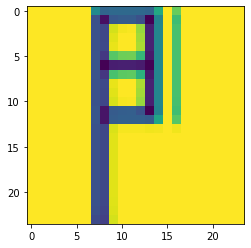

們 {'亻': (0, 0, 10, 25), '卩': (10, 2, 20, 27)}
侄
倒 {}
亻
亻 (0, 0, 10, 25)


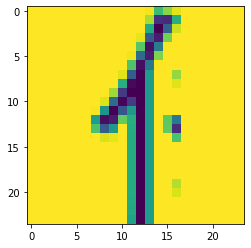

亻
亻 (0, 2, 10, 27)


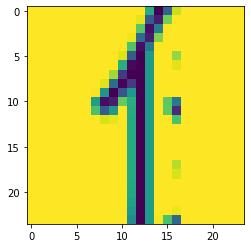

倓 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


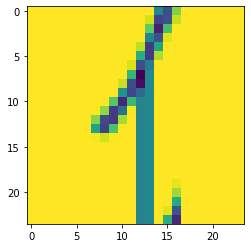

亻
亻 (0, 2, 10, 27)


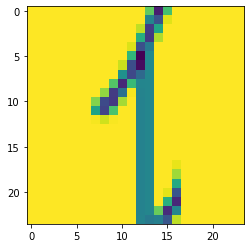

咻
倔 {'亻': (0, 0, 10, 25)}
匣
匣
倕 {}
亻
亻 (0, 0, 10, 25)


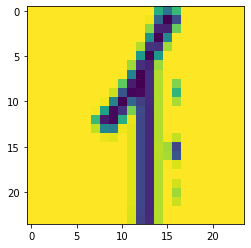

亻
亻 (0, 2, 10, 27)


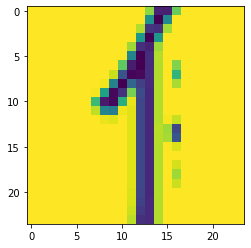

倖 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


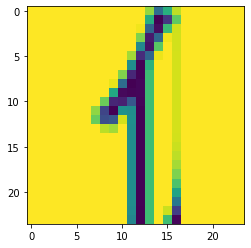

亻
亻 (0, 2, 10, 27)


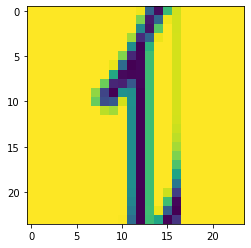

亻
亻 (2, 0, 12, 25)


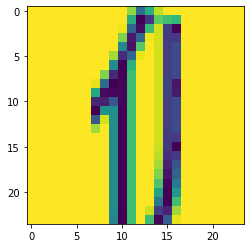

丹
回
倗 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


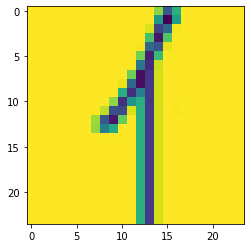

亻
亻 (0, 2, 10, 27)


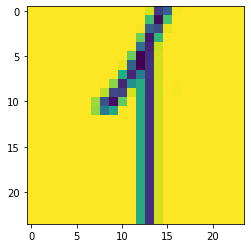

卞
倘 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


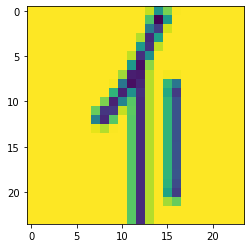

候 {'亻': (0, 0, 10, 25)}
俸
奇
奇
倚 {}
亻
亻 (0, 0, 10, 25)


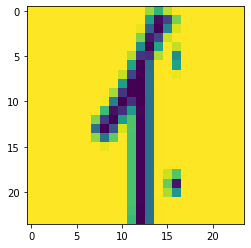

亻
亻 (0, 2, 10, 27)


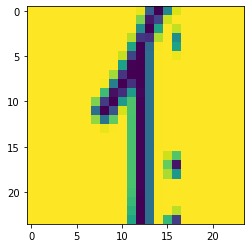

其
其
倛 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


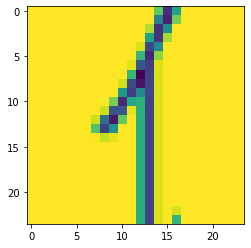

亻
亻 (0, 2, 10, 27)


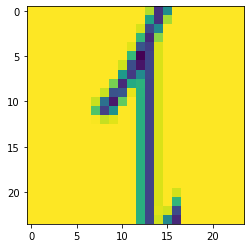

亻
亻 (2, 0, 12, 25)


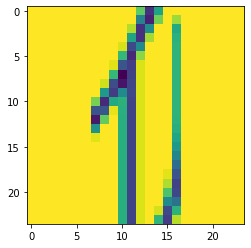

倜 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


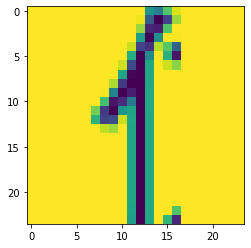

亻
亻 (0, 2, 10, 27)


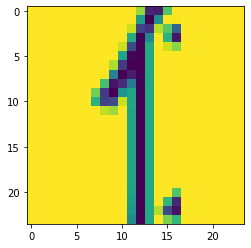

倞 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 2, 10, 27)


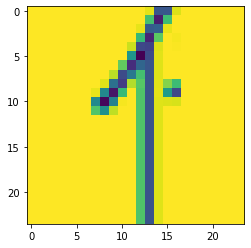

借 {'亻': (0, 2, 10, 27)}
亻
亻 (0, 0, 10, 25)


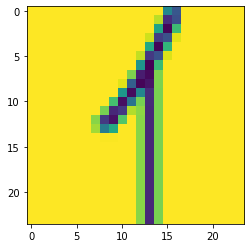

亻
亻 (0, 2, 10, 27)


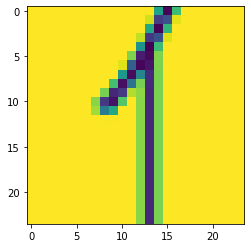

亻
亻 (2, 0, 12, 25)


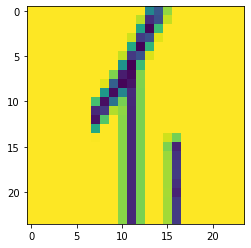

亻
亻 (2, 2, 12, 27)


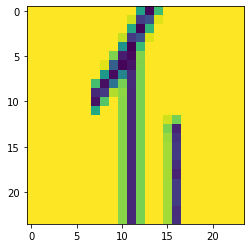

倡 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


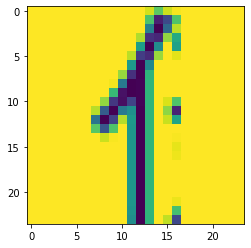

亻
亻 (0, 2, 10, 27)


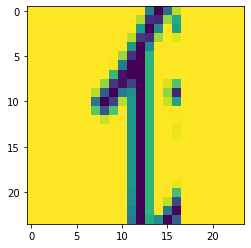

咿
倢 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


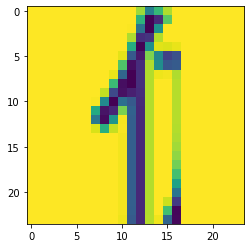

亻
亻 (0, 2, 10, 27)


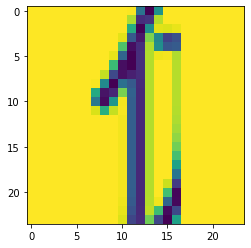

倣 {'亻': (0, 0, 10, 25)}
倥 {}
卷
倦 {}
亻
亻 (0, 0, 10, 25)


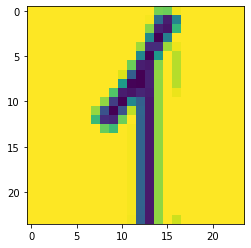

亻
亻 (0, 2, 10, 27)


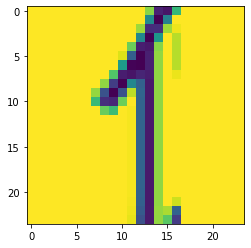

倧 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


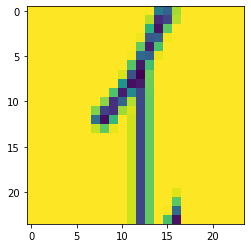

亻
亻 (0, 2, 10, 27)


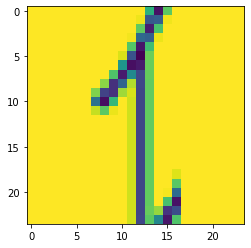

倨 {'亻': (0, 0, 10, 25)}
冒
倩 {}
亻
亻 (0, 0, 10, 25)


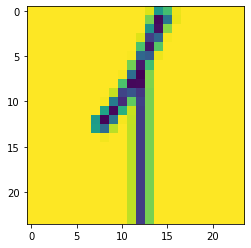

亻
亻 (0, 2, 10, 27)


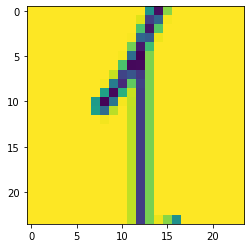

倪 {'亻': (0, 0, 10, 25)}
倫 {}
亻
亻 (0, 0, 10, 25)


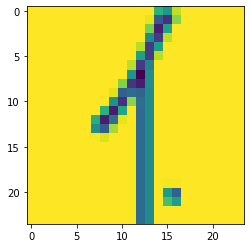

亻
亻 (0, 2, 10, 27)


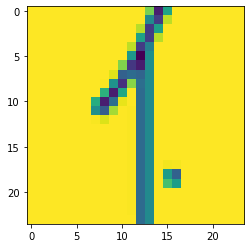

倬 {'亻': (0, 0, 10, 25)}
委
委
委
委
倭 {}
亻
亻 (0, 0, 10, 25)


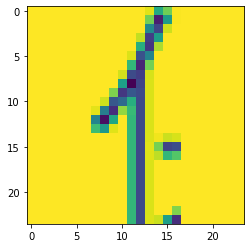

丬
丬 (8, 2, 18, 27)


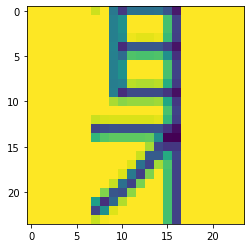

倮 {'亻': (0, 0, 10, 25), '丬': (8, 2, 18, 27)}
变
倰 {}
事
事
倳 {}
亻
亻 (0, 2, 10, 27)


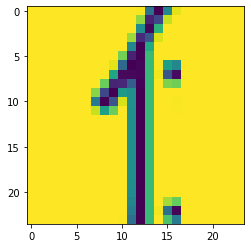

倵 {'亻': (0, 2, 10, 27)}
亻
亻 (0, 0, 10, 25)


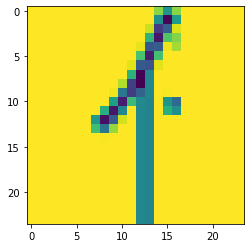

亻
亻 (0, 2, 10, 27)


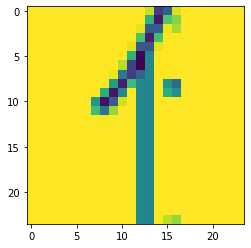

债 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


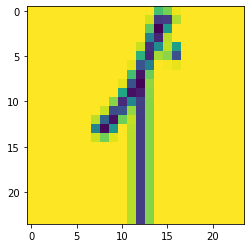

亻
亻 (0, 2, 10, 27)


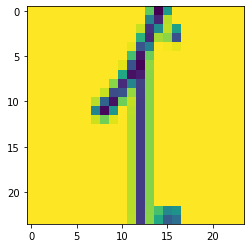

值 {'亻': (0, 0, 10, 25)}
倾 {}
亻
亻 (0, 0, 10, 25)


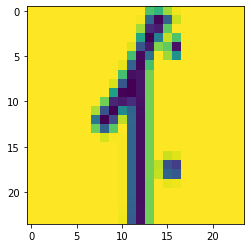

亻
亻 (0, 2, 10, 27)


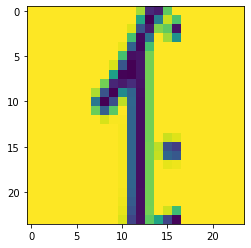

个
偀 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


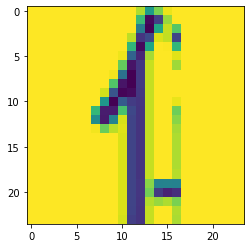

亻
亻 (0, 2, 10, 27)


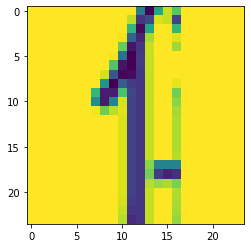

偁 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


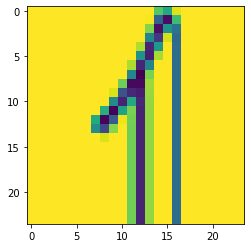

亻
亻 (0, 2, 10, 27)


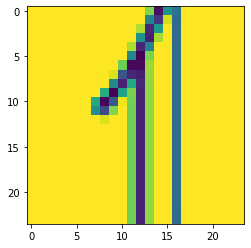

偃 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


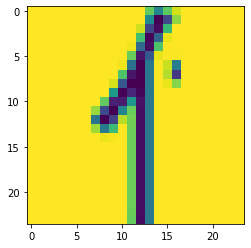

亻
亻 (0, 2, 10, 27)


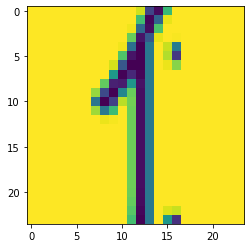

偅 {'亻': (0, 0, 10, 25)}
乍
偆 {}
亻
亻 (0, 0, 10, 25)


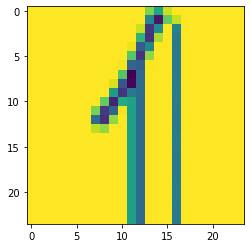

亻
亻 (0, 2, 10, 27)


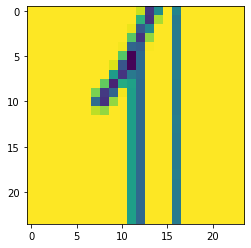

假 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


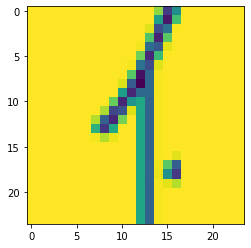

亻
亻 (0, 2, 10, 27)


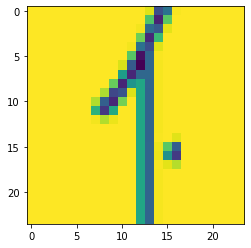

亻
亻 (2, 0, 12, 25)


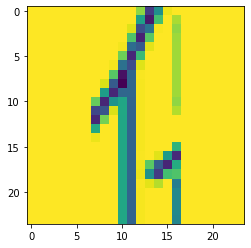

偈 {'亻': (0, 0, 10, 25)}
偉 {}
亻
亻 (0, 0, 10, 25)


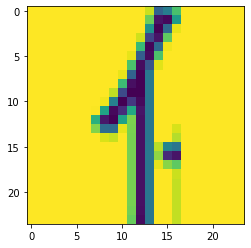

亻
亻 (0, 2, 10, 27)


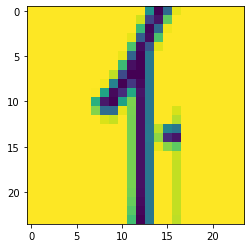

亻
亻 (2, 0, 12, 25)


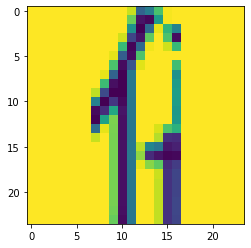

且
且
垂
偊 {'亻': (0, 0, 10, 25)}
咾
偌 {}
亻
亻 (0, 0, 10, 25)


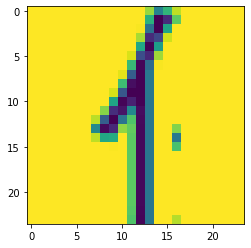

亻
亻 (0, 2, 10, 27)


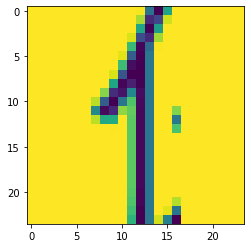

偍 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


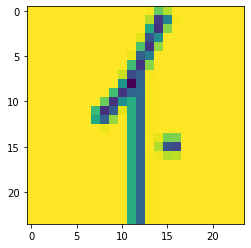

喘
偎 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


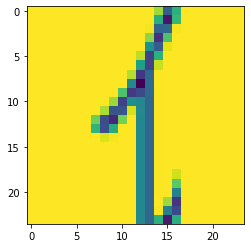

亻
亻 (0, 2, 10, 27)


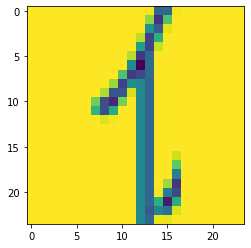

偏 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


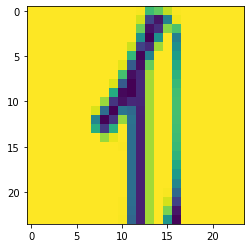

亻
亻 (0, 2, 10, 27)


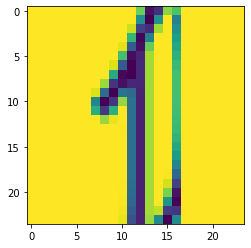

偑 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


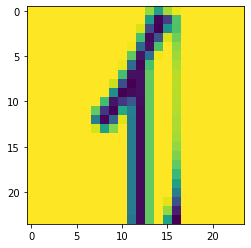

亻
亻 (0, 2, 10, 27)


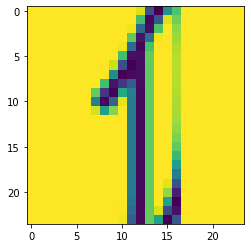

亻
亻 (2, 0, 12, 25)


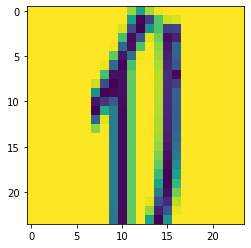

冒
偓 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


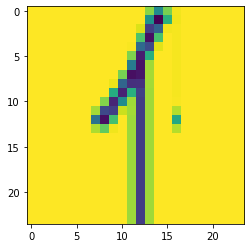

亻
亻 (0, 2, 10, 27)


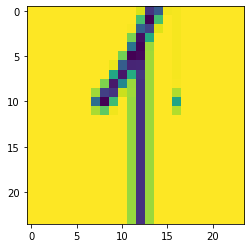

偕 {'亻': (0, 0, 10, 25)}
偗 {}
做 {}
亻
亻 (0, 0, 10, 25)


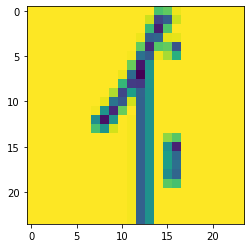

停 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


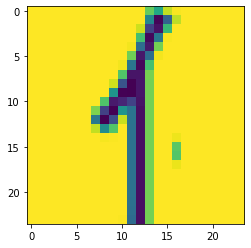

亻
亻 (0, 2, 10, 27)


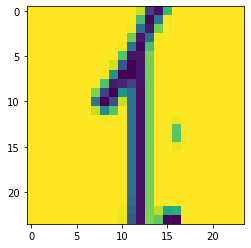

哼
偟 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


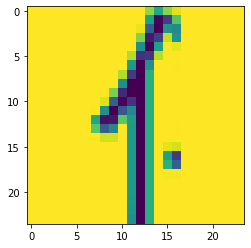

亻
亻 (0, 2, 10, 27)


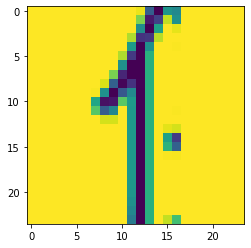

偠 {'亻': (0, 0, 10, 25)}
个
咿
偢 {}
亻
亻 (0, 0, 10, 25)


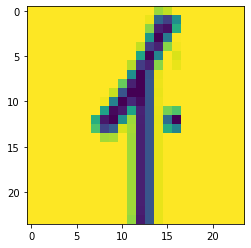

亻
亻 (0, 2, 10, 27)


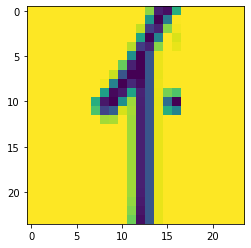

偣 {'亻': (0, 0, 10, 25)}
健 {}
亻
亻 (0, 0, 10, 25)


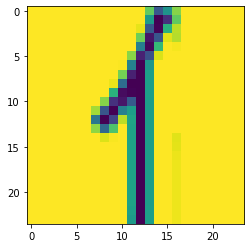

亻
亻 (0, 2, 10, 27)


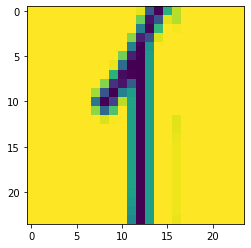

亻
亻 (2, 0, 12, 25)


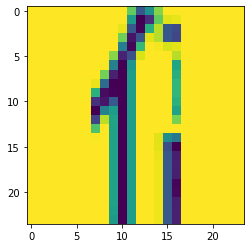

冒
偪 {'亻': (0, 0, 10, 25)}
偬 {}
亻
亻 (0, 0, 10, 25)


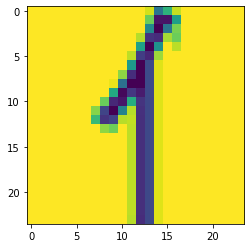

亻
亻 (0, 2, 10, 27)


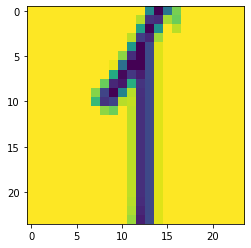

偭 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


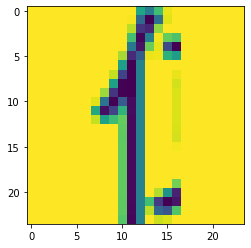

亻
亻 (0, 2, 10, 27)


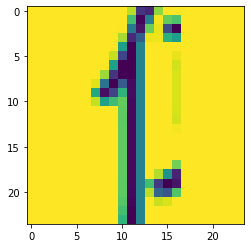

哀
偯 {'亻': (0, 0, 10, 25)}
售
专
偰 {}
亻
亻 (0, 0, 10, 25)


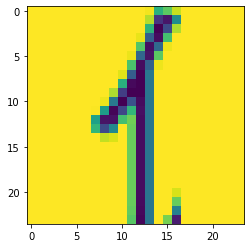

亻
亻 (0, 2, 10, 27)


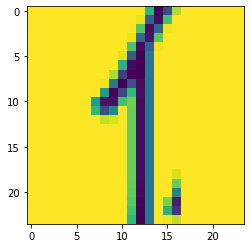

吣
凭
凭
偲 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


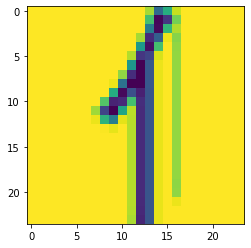

亻
亻 (0, 2, 10, 27)


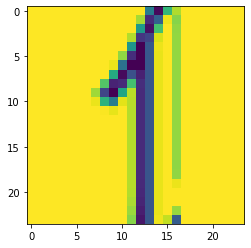

亻
亻 (2, 2, 12, 27)


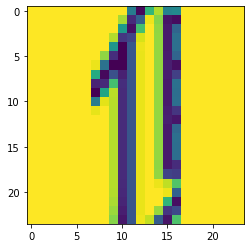

具
且
側 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


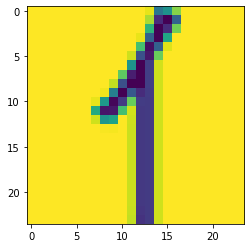

亻
亻 (0, 2, 10, 27)


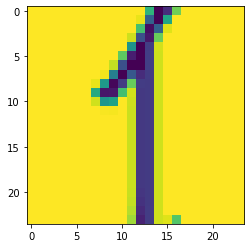

上
偵 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


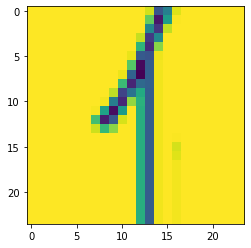

亻
亻 (0, 2, 10, 27)


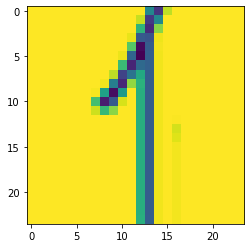

偶 {'亻': (0, 0, 10, 25)}
俞
偷 {}
偺 {}
之
喾
偻 {}
亻
亻 (0, 0, 10, 25)


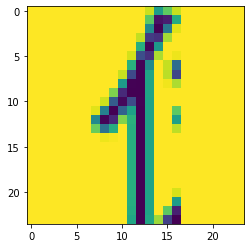

亻
亻 (0, 2, 10, 27)


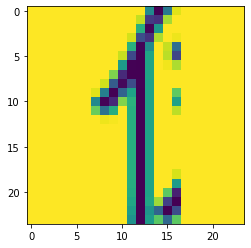

咿
偽 {'亻': (0, 0, 10, 25)}
偾 {}
偿 {}
亻
亻 (0, 0, 10, 25)


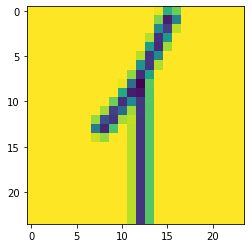

亻
亻 (0, 2, 10, 27)


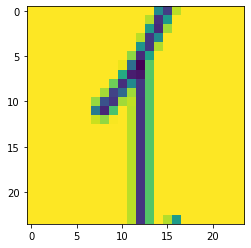

傀 {'亻': (0, 0, 10, 25)}
傃 {}
亻
亻 (0, 0, 10, 25)


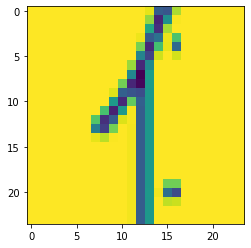

亻
亻 (0, 2, 10, 27)


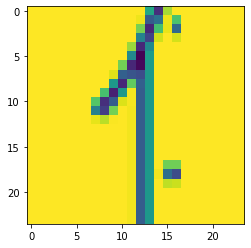

傅 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


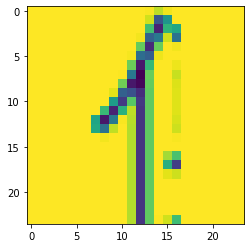

亻
亻 (0, 2, 10, 27)


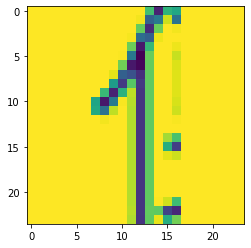

傈 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


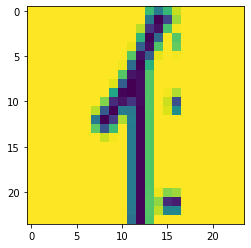

亻
亻 (0, 2, 10, 27)


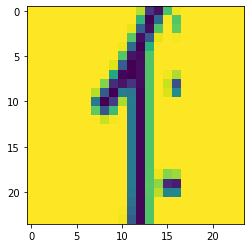

傋 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


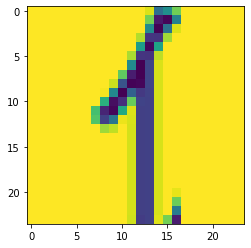

亻
亻 (0, 2, 10, 27)


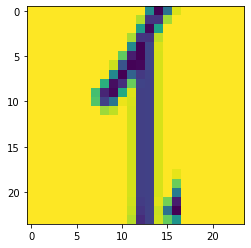

卡
具
傌 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


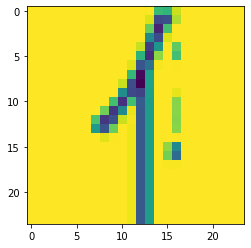

亻
亻 (0, 2, 10, 27)


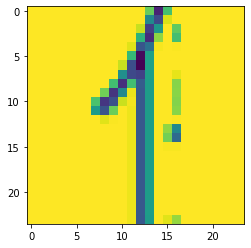

傍 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


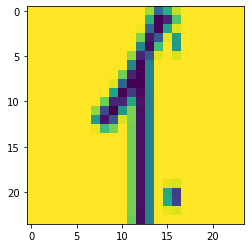

亻
亻 (0, 2, 10, 27)


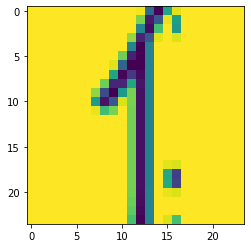

傎 {'亻': (0, 0, 10, 25)}
乡
傑 {}
亻
亻 (0, 0, 10, 25)


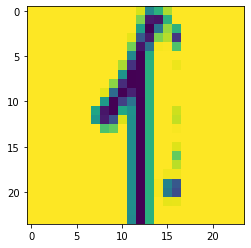

亻
亻 (0, 2, 10, 27)


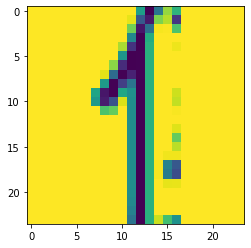

俘
奚
奚
傒 {'亻': (0, 0, 10, 25)}
丬
丬 (6, 2, 16, 27)


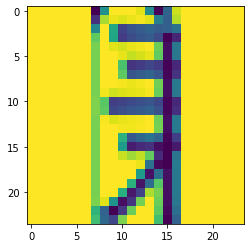

傔 {'丬': (6, 2, 16, 27)}
个
咻
咻
傕 {}
咿
囚
含
今
今
傖 {}
傘
傘
傘
乎
乎
傘 {}
亻
亻 (0, 0, 10, 25)


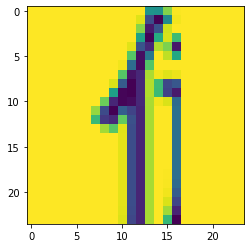

亻
亻 (0, 2, 10, 27)


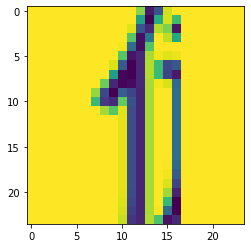

俑
備 {'亻': (0, 0, 10, 25)}
傚 {}
傛 {}
亻
亻 (0, 0, 10, 25)


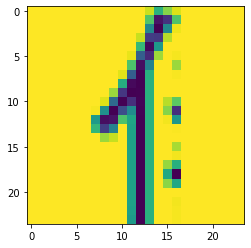

亻
亻 (0, 2, 10, 27)


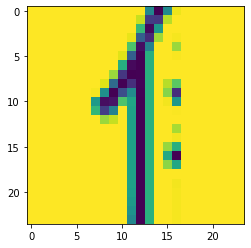

傜 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


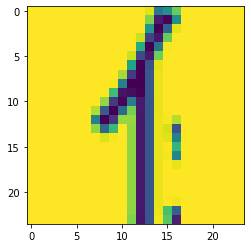

亻
亻 (0, 2, 10, 27)


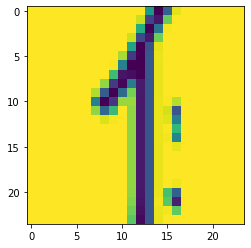

卣
傝 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 2, 10, 27)


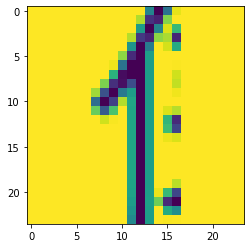

傞 {'亻': (0, 2, 10, 27)}
傢 {}
傣 {}
党
党
党
傥 {}
亻
亻 (0, 0, 10, 25)


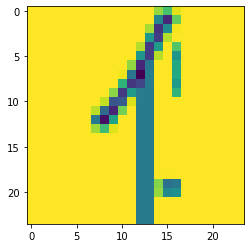

傧 {'亻': (0, 0, 10, 25)}
储 {}
咿
咿
傩 {}
咻
咻
催 {}
亻
亻 (0, 0, 10, 25)


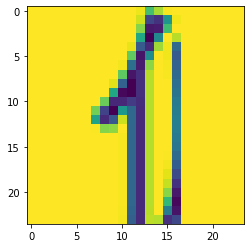

亻
亻 (0, 2, 10, 27)


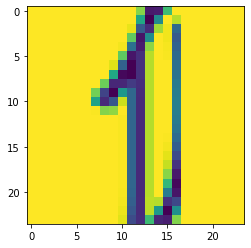

傭 {'亻': (0, 0, 10, 25)}
售
售
售
售
妻
傮 {}
亻
亻 (0, 0, 10, 25)


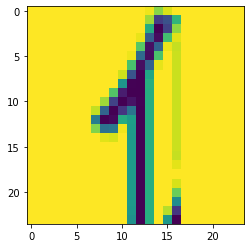

亻
亻 (0, 2, 10, 27)


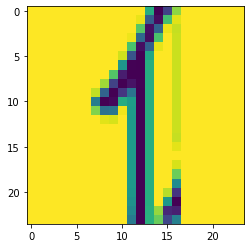

亻
亻 (2, 2, 12, 27)


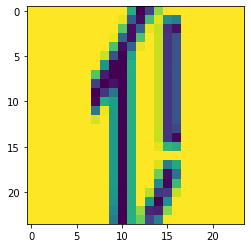

傯 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


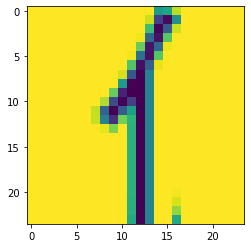

亻
亻 (0, 2, 10, 27)


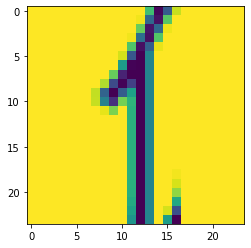

亻
亻 (2, 0, 12, 25)


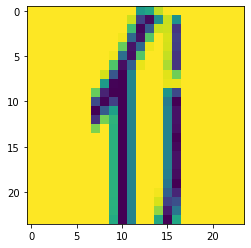

前
傰 {'亻': (0, 0, 10, 25)}
亻
亻 (2, 2, 12, 27)


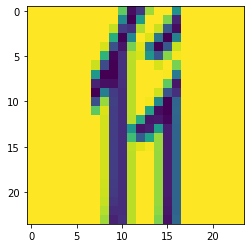

亻
亻 (8, 0, 18, 25)


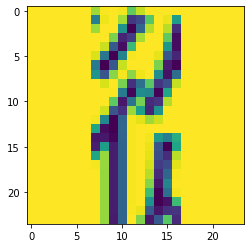

傱 {'亻': (2, 2, 12, 27)}
咿
咿
傲 {}
具
专
专
亘
傳 {}
亻
亻 (0, 0, 10, 25)


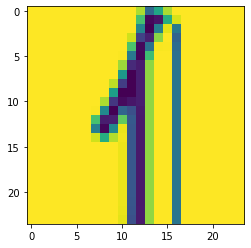

亻
亻 (0, 2, 10, 27)


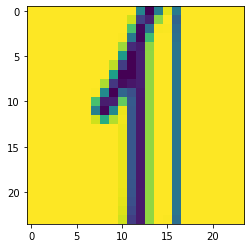

侐
吧
傴 {'亻': (0, 0, 10, 25)}
冒
售
債 {}
塲
傷 {}
傺 {}
亻
亻 (0, 0, 10, 25)


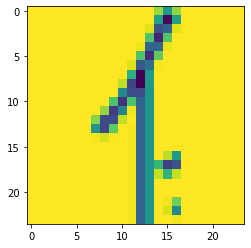

亻
亻 (0, 2, 10, 27)


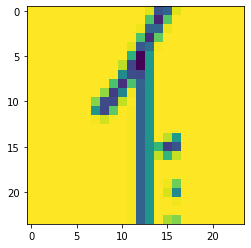

傻 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


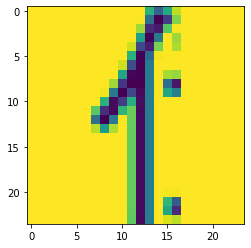

亻
亻 (0, 2, 10, 27)


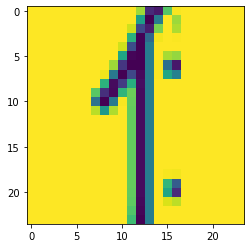

傽 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


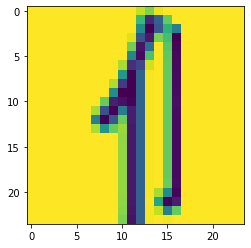

傾 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


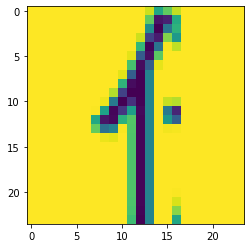

亻
亻 (0, 2, 10, 27)


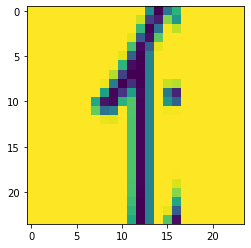

写
写
傿 {'亻': (0, 0, 10, 25)}
售
唐
僂 {}
亻
亻 (0, 0, 10, 25)


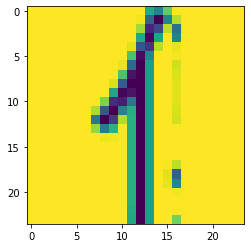

亻
亻 (0, 2, 10, 27)


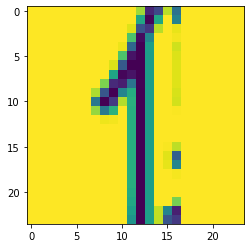

嘌
僄 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


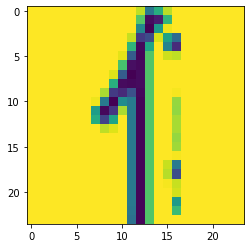

亻
亻 (0, 2, 10, 27)


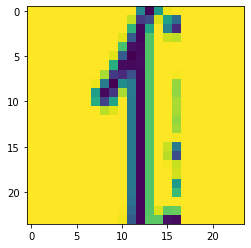

喜
堇
堇
堇
堇
僅 {'亻': (0, 0, 10, 25)}
匣
僆 {}
僇 {}
今
僉 {}
僊 {}
亻
亻 (0, 2, 10, 27)


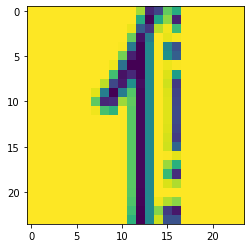

働 {'亻': (0, 2, 10, 27)}
亻
亻 (0, 0, 10, 25)


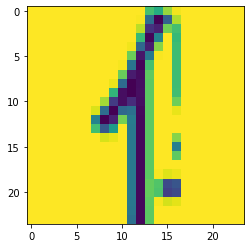

亻
亻 (0, 2, 10, 27)


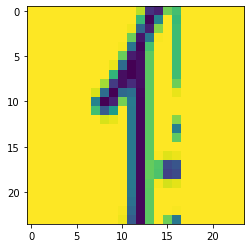

埕
凰
僎 {'亻': (0, 0, 10, 25)}
像 {}
僑 {}
冒
冒
僓 {}
亻
亻 (0, 0, 10, 25)


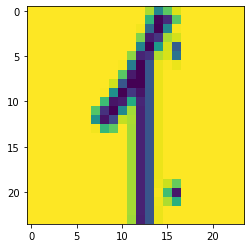

亻
亻 (0, 2, 10, 27)


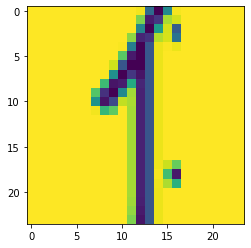

哂
喾
僔 {'亻': (0, 0, 10, 25)}
僕 {}
亻
亻 (0, 0, 10, 25)


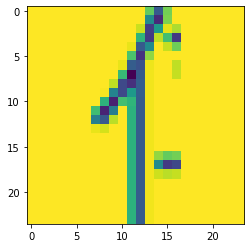

僖 {'亻': (0, 0, 10, 25)}
僚 {}
其
其
僛 {}
亻
亻 (0, 0, 10, 25)


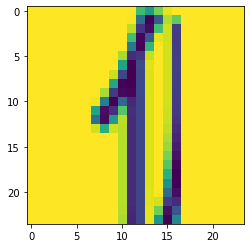

哼
僝 {'亻': (0, 0, 10, 25)}
僣 {}
亻
亻 (0, 0, 10, 25)


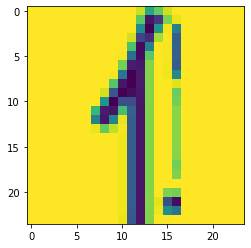

亻
亻 (0, 2, 10, 27)


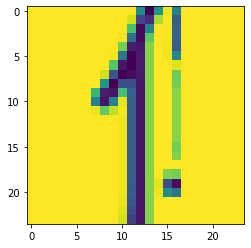

冒
僤 {'亻': (0, 0, 10, 25)}
僥 {}
勍
僦 {}
亻
亻 (0, 0, 10, 25)


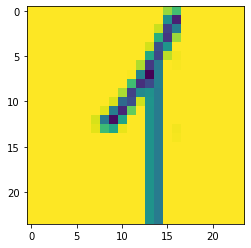

亻
亻 (0, 2, 10, 27)


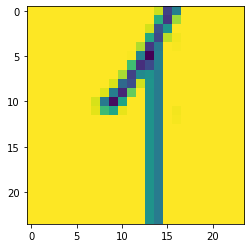

亻
亻 (2, 0, 12, 25)


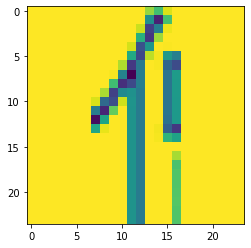

僧 {'亻': (0, 0, 10, 25)}
冒
亘
僨 {}
亻
亻 (0, 0, 10, 25)


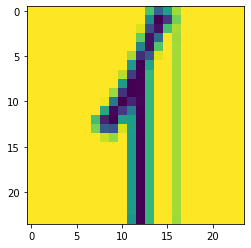

亻
亻 (0, 2, 10, 27)


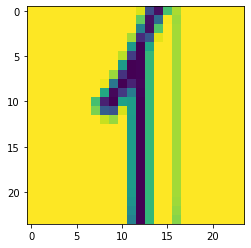

亻
亻 (2, 0, 12, 25)


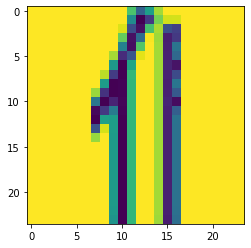

冑
僩 {'亻': (0, 0, 10, 25)}
僬 {}
僭 {}
冒
冒
僮 {}
僯 {}
僰
僰 {}
亻
亻 (0, 0, 10, 25)


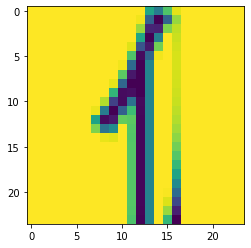

亻
亻 (0, 2, 10, 27)


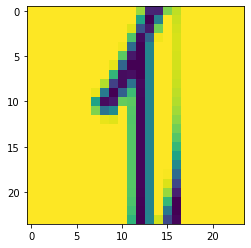

亻
亻 (2, 0, 12, 25)


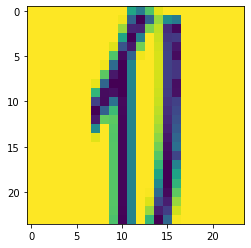

冒
冒
冒
僱 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


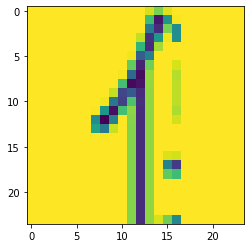

亻
亻 (0, 2, 10, 27)


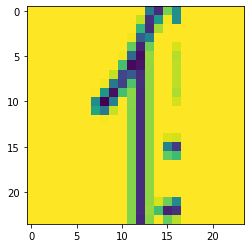

僳 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


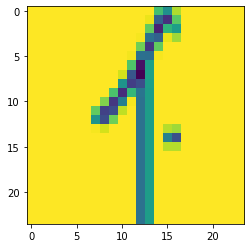

亻
亻 (0, 2, 10, 27)


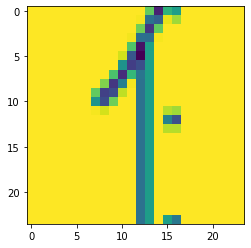

僵 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


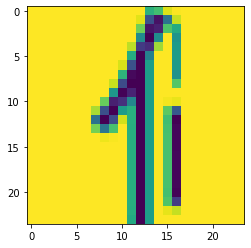

唯
僶 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


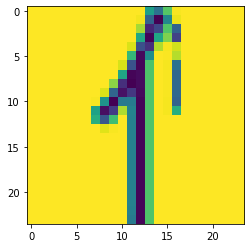

亻
亻 (0, 2, 10, 27)


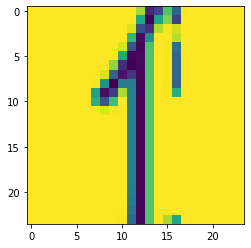

價 {'亻': (0, 0, 10, 25)}
咻
僻 {}
僽 {}
唇
僾 {}
亻
亻 (0, 2, 10, 27)


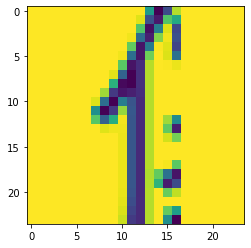

唪
僿 {'亻': (0, 2, 10, 27)}
儀 {}
亻
亻 (0, 0, 10, 25)


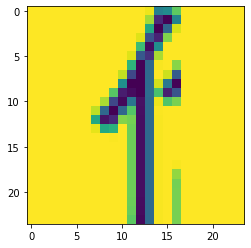

亻
亻 (0, 2, 10, 27)


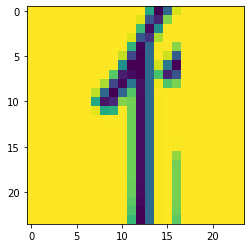

售
儁 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


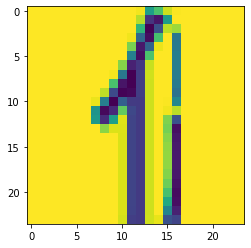

亻
亻 (0, 2, 10, 27)


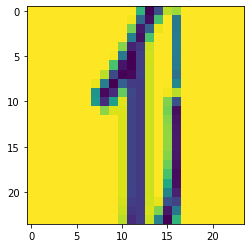

候
儂 {'亻': (0, 0, 10, 25)}
儃 {}
億 {}
嘗
堂
嘗
嘗
儅 {}
勩
儆 {}
儇 {}
噌
儈 {}
倚
儉 {}
亻
亻 (0, 0, 10, 25)


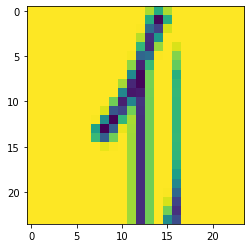

亻
亻 (0, 2, 10, 27)


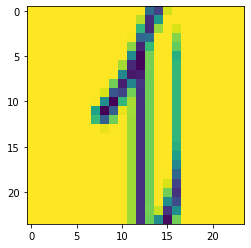

參
儋 {'亻': (0, 0, 10, 25)}
包
儌 {}
亻
亻 (0, 0, 10, 25)


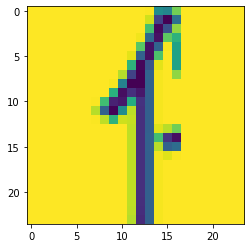

冒
喾
儐 {'亻': (0, 0, 10, 25)}
儒 {}
修
儓 {}
冒
冒
儔 {}
坌
儕 {}
凝
儗 {}
唪
儘 {}
夢
儚 {}
亻
亻 (0, 0, 10, 25)


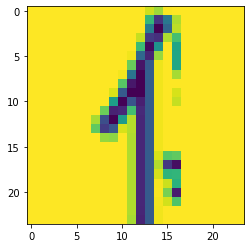

亻
亻 (0, 2, 10, 27)


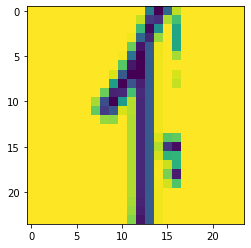

儜 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 2, 10, 27)


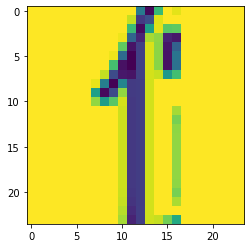

嘗
嘗
嘗
嘗
償 {'亻': (0, 2, 10, 27)}
亻
亻 (0, 0, 10, 25)


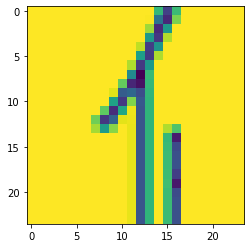

亻
亻 (0, 2, 10, 27)


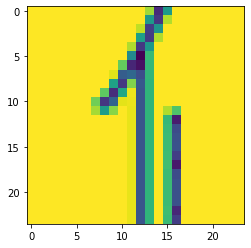

儡 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


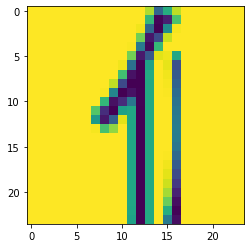

亻
亻 (0, 2, 10, 27)


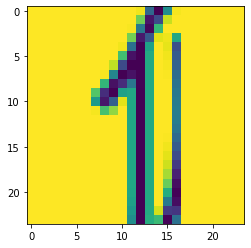

儢 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


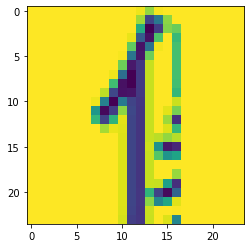

儤 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


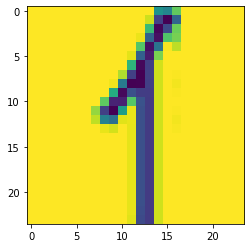

亻
亻 (0, 2, 10, 27)


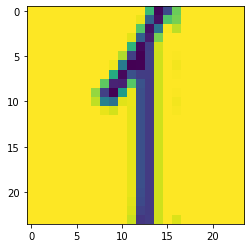

亶
儥 {'亻': (0, 0, 10, 25)}
優 {}
叵
儭 {}
儱 {}
亨
儲 {}
儳 {}
亻
亻 (0, 0, 10, 25)


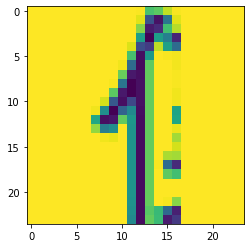

儴 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


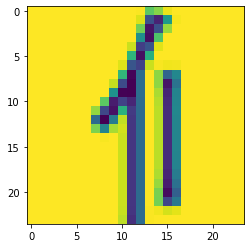

亻
亻 (0, 2, 10, 27)


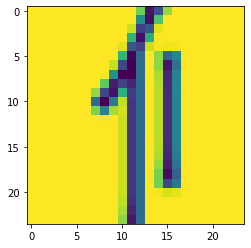

呼
呼
儵 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


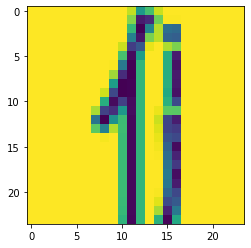

亻
亻 (0, 2, 10, 27)


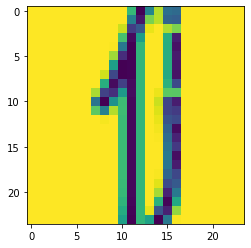

儷 {'亻': (0, 0, 10, 25)}
亻
亻 (0, 0, 10, 25)


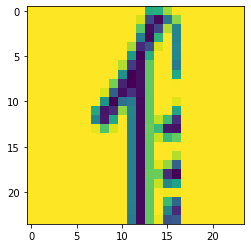

儸 {'亻': (0, 0, 10, 25)}
嘗
儹 {}
儺 {}
亻
亻 (0, 2, 10, 27)


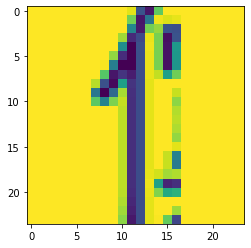

堇
堇
儻 {'亻': (0, 2, 10, 27)}
亻
亻 (0, 0, 10, 25)


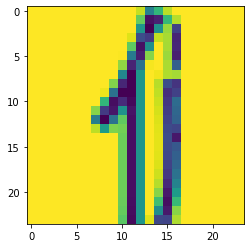

亻
亻 (0, 2, 10, 27)


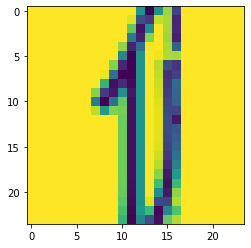

冒
冒
儼 {'亻': (0, 0, 10, 25)}
儿 {}
兀 {}
冫
冫 (0, 2, 10, 12)


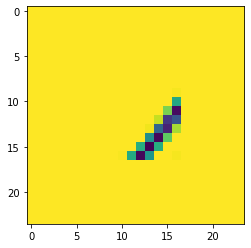

冫
冫 (2, 0, 12, 10)


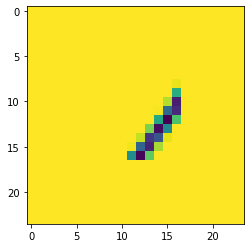

卜
卜 (16, 0, 26, 25)


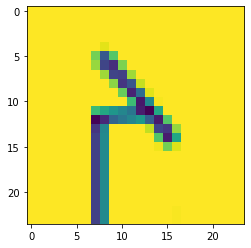

允 {'冫': (0, 2, 10, 12), '卜': (16, 0, 26, 25)}
亓
元 {}
亓
兄 {}
充 {}
丬
丬 (2, 0, 12, 25)


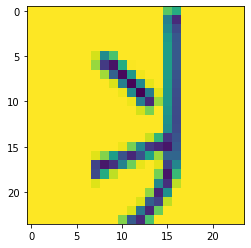

丬
丬 (2, 2, 12, 27)


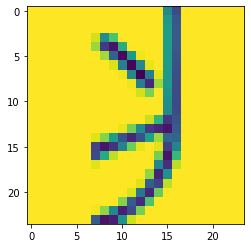

丬
丬 (4, 0, 14, 25)


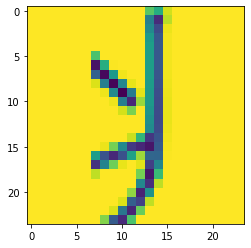

丬
丬 (4, 2, 14, 27)


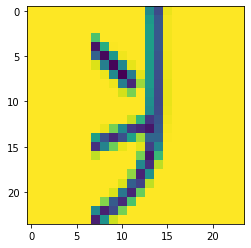

兆 {'丬': (2, 0, 12, 25)}
唪
兇 {}
先 {}
兮
乎
乎
光 {}
克 {}
乡
兌 {}
中
乡
免 {}
兑 {}
兒 {}
中
兔 {}
兕 {}
兖 {}
兗 {}
兙 {}
党 {}
兛 {}
卩
卩 (16, 0, 26, 25)


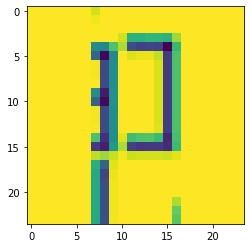

兜 {'卩': (16, 0, 26, 25)}
分
兝 {}
吒
垂
兞 {}
兟 {}
兡 {}
兢 {}
垧
厘
兣 {}
入 {}
囚
內 {}
冫
冫 (2, 0, 12, 10)


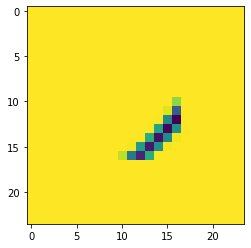

全
全
全 {'冫': (2, 0, 12, 10)}
兩 {}
八 {}
八
八 (2, 0, 27, 10)


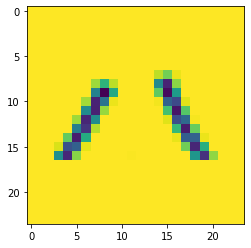

么
公 {'八': (2, 0, 27, 10)}
冫
冫 (0, 0, 10, 25)


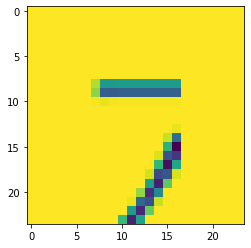

冫
冫 (0, 14, 10, 24)


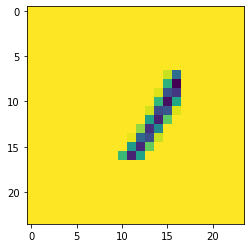

亠
亠 (2, 0, 27, 10)


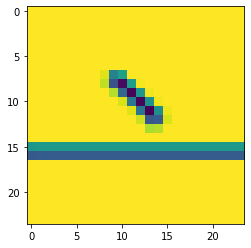

八
八 (2, 12, 27, 22)


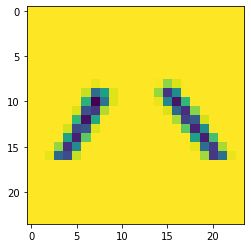

八
八 (2, 14, 27, 24)


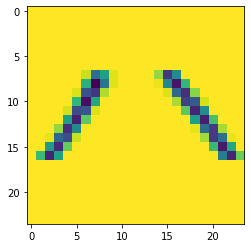

卞
六 {'冫': (0, 0, 10, 25), '亠': (2, 0, 27, 10), '八': (2, 12, 27, 22)}
分
兮 {}
兰
兰
兰 {}
共 {}
亨
关
关
关
关 {}
今
今
兴 {}
乒
乓
兵 {}
其
其
其 {}
具 {}
典 {}
亥
亥
兹
兹 {}
养 {}
兼 {}
卑
兽 {}
冀 {}
听
冁 {}
冂 {}
囚
内 {}
冇 {}
凶
冈 {}
冉
冉 {}
十
十 (0, 2, 10, 27)


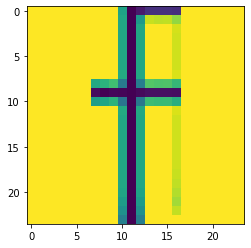

冊 {'十': (0, 2, 10, 27)}
册 {}
冉
再 {}
四
四
于
卣
冏 {}
卡
卡
冒
冒
哥
冑 {}
冒
哥
冒 {}
再
圊
堇
售
冓 {}
一
一 (2, 6, 27, 16)


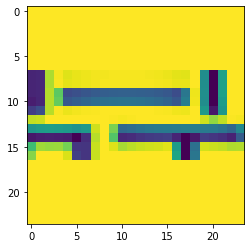

一
一 (2, 8, 27, 18)


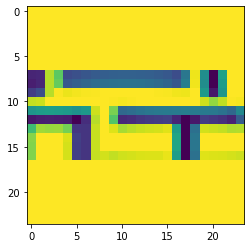

冔 {'一': (2, 6, 27, 16)}
冕 {}
冖 {}
卩
卩 (16, 0, 26, 25)


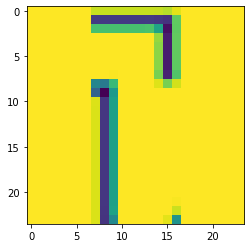

冗 {'卩': (16, 0, 26, 25)}
冫
冫 (0, 16, 10, 26)


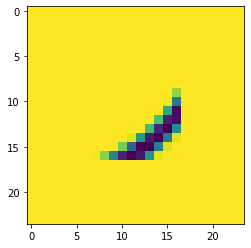

丬
丬 (4, 0, 14, 25)


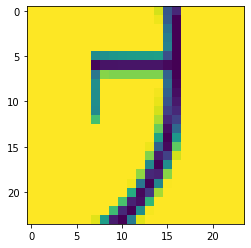

冘
冘 {'冫': (0, 16, 10, 26), '丬': (4, 0, 14, 25)}
写 {}
军 {}
农 {}
冠 {}
卜
卜 (16, 16, 26, 26)


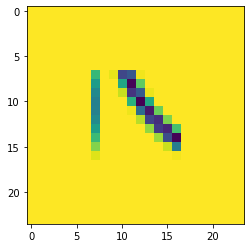

冢 {'卜': (16, 16, 26, 26)}
号
乡
冤 {}
冥 {}
亘
冪 {}
冫 {}
夕
夕 (0, 4, 25, 14)


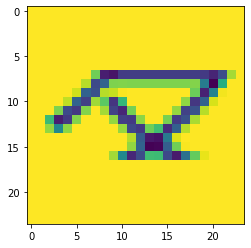

夕
夕 (2, 4, 27, 14)


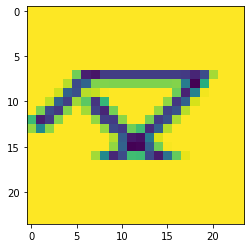

冬
冬
冬 {'夕': (0, 4, 25, 14)}
冯 {}
冰
冰 {}
上
冱 {}
冫
冫 (0, 0, 10, 25)


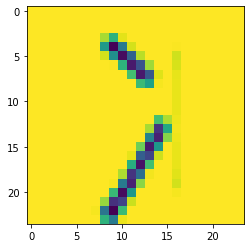

冲 {'冫': (0, 0, 10, 25)}
丬
丬 (8, 0, 18, 25)


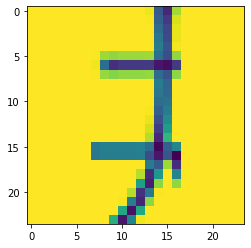

夫
决 {'丬': (8, 0, 18, 25)}
冫
冫 (0, 0, 10, 25)


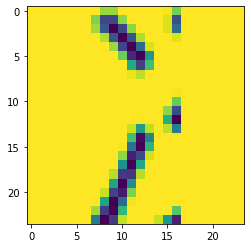

冫
冫 (2, 0, 12, 25)


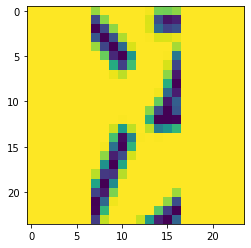

冫
冫 (2, 2, 12, 27)


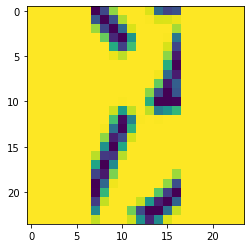

丬
丬 (12, 2, 22, 27)


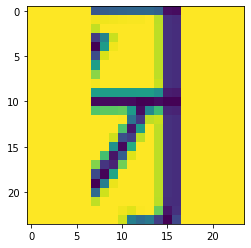

冴 {'冫': (0, 0, 10, 25), '丬': (12, 2, 22, 27)}
况 {}
冫
冫 (0, 0, 10, 25)


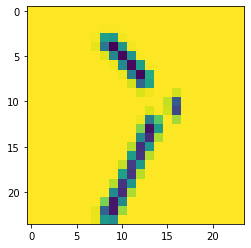

台
台
冶 {'冫': (0, 0, 10, 25)}
令
令
今
冷 {}
冻 {}
冼 {}
夕
夕 (8, 2, 18, 27)


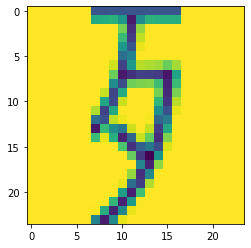

冽 {'夕': (8, 2, 18, 27)}
呸
冾 {}
净 {}
凄
凄
凄 {}
丬
丬 (0, 0, 10, 25)


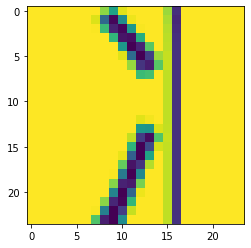

丬
丬 (0, 2, 10, 27)


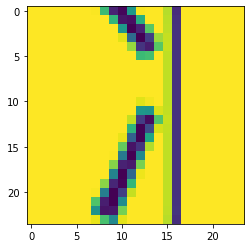

固
固
凅 {'丬': (0, 0, 10, 25)}
准 {}
公
凇 {}
凈
凈 {}
凉 {}
冫
冫 (0, 0, 10, 25)


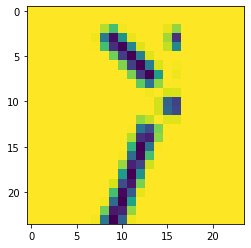

冫
冫 (0, 2, 10, 27)


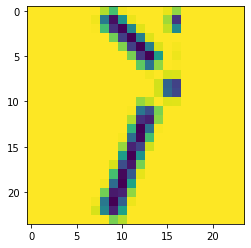

冒
凊 {'冫': (0, 0, 10, 25)}
丬
丬 (2, 0, 12, 25)


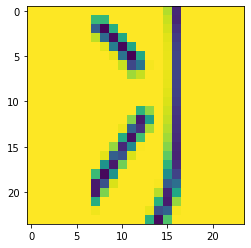

丬
丬 (2, 2, 12, 27)


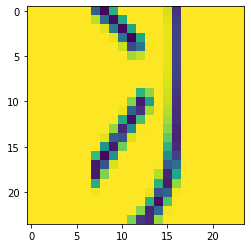

凋 {'丬': (2, 0, 12, 25)}
专
凌 {}
准
凍 {}
一
一 (0, 0, 25, 10)


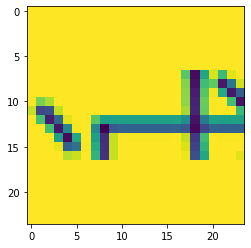

咸
减 {'一': (0, 0, 25, 10)}
县
凐 {}
奏
凑 {}
冫
冫 (0, 0, 10, 25)


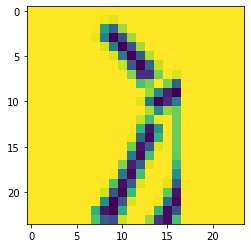

丬
丬 (2, 0, 12, 25)


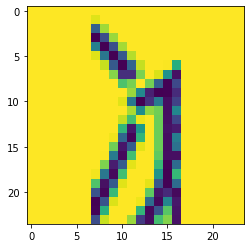

丬
丬 (2, 2, 12, 27)


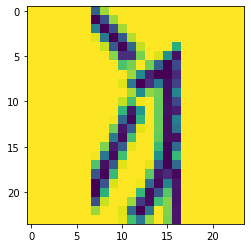

含
今
凔 {'冫': (0, 0, 10, 25), '丬': (2, 0, 12, 25)}
其
其
其
凘 {}
凛 {}
写
凜 {}
予
凝 {}
凞 {}
几 {}
丁
八
八 (0, 14, 25, 24)


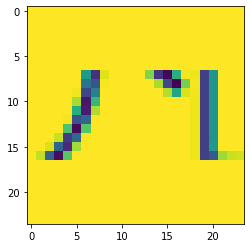

下
凡 {'八': (0, 14, 25, 24)}
凤 {}
亓
亓
凫 {}
凭 {}
勩
凯 {}
喱
即
凰 {}
夕
夕 (2, 16, 12, 26)


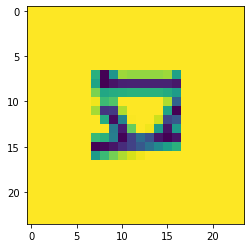

勩
凱 {'夕': (2, 16, 12, 26)}
凳 {}
凵 {}
之
之
凶
凶
凶
凶 {}
亡
凸 {}
卩
卩 (0, 0, 10, 25)


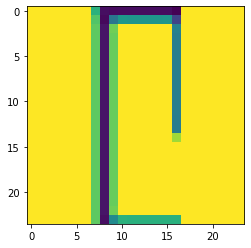

上
些
些
凹 {'卩': (0, 0, 10, 25)}
出 {}
击 {}
上
凼 {}
习
函 {}
卹
吵
凾 {}
卞
乎
卞
乎
乎
凿 {}
刀 {}
冫
冫 (0, 0, 10, 25)


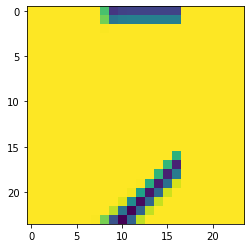

冫
冫 (0, 2, 10, 27)


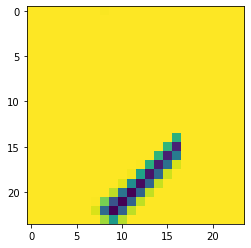

冫
冫 (0, 2, 25, 12)


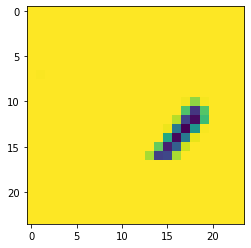

冫
冫 (0, 4, 25, 14)


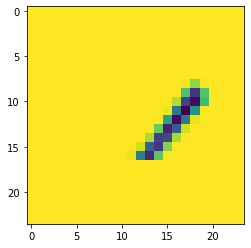

冫
冫 (0, 6, 25, 16)


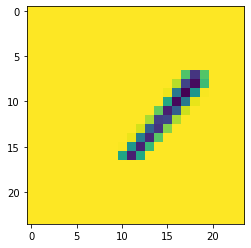

冫
冫 (0, 12, 10, 22)


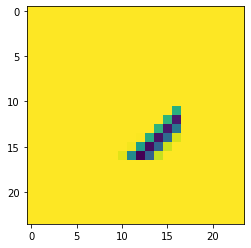

冫
冫 (2, 0, 12, 25)


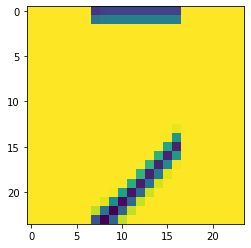

冫
冫 (2, 2, 12, 27)


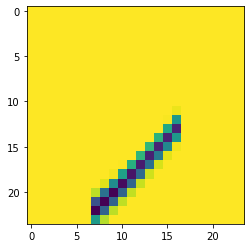

冫
冫 (2, 12, 12, 22)


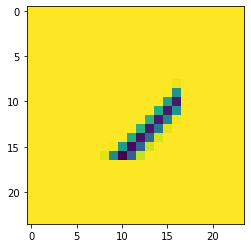

冫
冫 (4, 8, 14, 18)


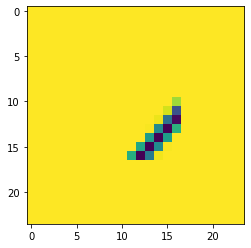

冫
冫 (4, 10, 14, 20)


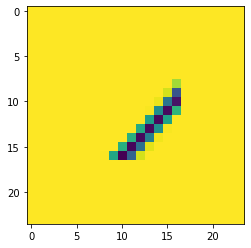

冫
冫 (6, 6, 16, 16)


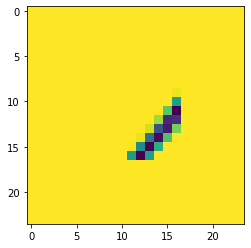

冫
冫 (6, 8, 16, 18)


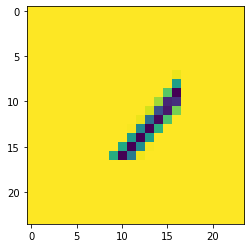

冫
冫 (8, 4, 18, 14)


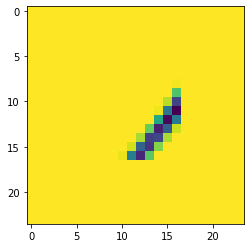

冫
冫 (10, 2, 20, 12)


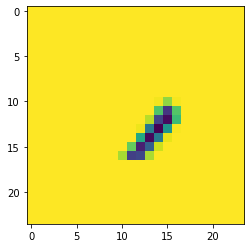

刁 {'冫': (0, 0, 10, 25)}
刂 {}
刃 {}
分 {}
切 {}
冫
冫 (0, 2, 10, 27)


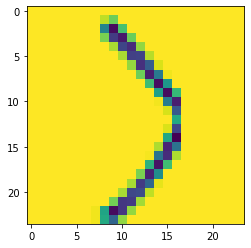

冫
冫 (0, 14, 10, 24)


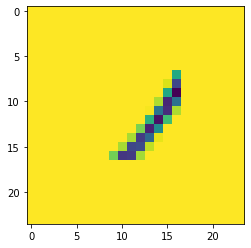

夕
夕 (2, 0, 12, 25)


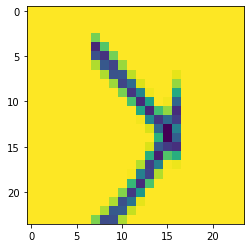

刈
刈
刈
刈 {'冫': (0, 2, 10, 27), '夕': (2, 0, 12, 25)}
刊 {}
刍 {}
勿
刎 {}
刑 {}
划 {}
亓
亓
刓 {}
刖 {}
夕
夕 (6, 2, 16, 27)


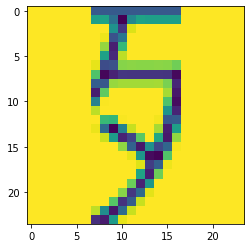

列 {'夕': (6, 2, 16, 27)}
夕
夕 (2, 2, 12, 27)


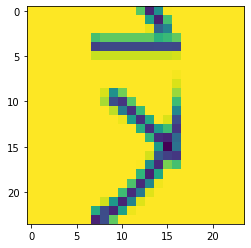

刈
刘 {'夕': (2, 2, 12, 27)}
则 {}
个
刚 {}
冫
冫 (0, 0, 10, 10)


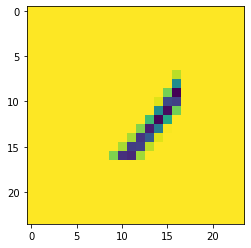

仓
仓
创 {'冫': (0, 0, 10, 10)}
卞
哀
初 {}
十
十 (6, 2, 16, 27)


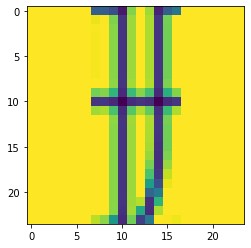

删 {'十': (6, 2, 16, 27)}
丬
丬 (0, 0, 10, 25)


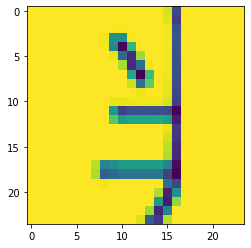

判 {'丬': (0, 0, 10, 25)}
別 {}
刨 {}
卜
卜 (8, 2, 18, 27)


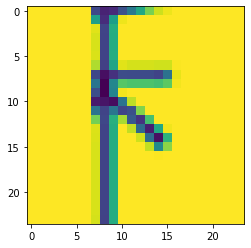

利 {'卜': (8, 2, 18, 27)}
刪 {}
别 {}
刭 {}
刮 {}
勾
到
全
全
到 {}
井
刱 {}
丬
丬 (0, 0, 10, 25)


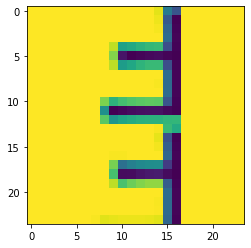

刲 {'丬': (0, 0, 10, 25)}
刳 {}
上
且
且
于
刵 {}
制 {}
刷 {}
乎
亨
分
券 {}
刹 {}
味
刺 {}
亥
亥
亥
亥
刻 {}
会
会
刽 {}
夕
夕 (0, 14, 25, 24)


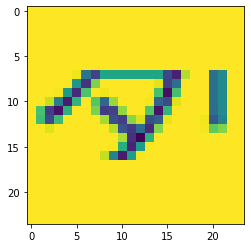

专
刿 {'夕': (0, 14, 25, 24)}
兰
剀 {}
丬
丬 (0, 0, 10, 25)


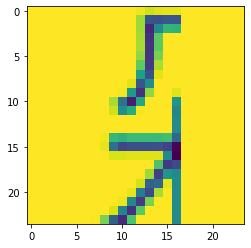

乡
哚
剁 {'丬': (0, 0, 10, 25)}
剂 {}
剃 {}
圣
剄 {}
上
則 {}
剉 {}
削 {}
剋 {}
剌 {}
前
前
前
前
前 {}
剎 {}
剐 {}
冫
冫 (0, 0, 10, 10)


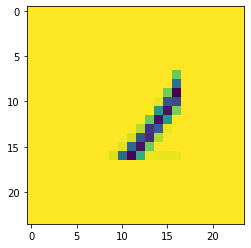

佥
剑 {'冫': (0, 0, 10, 10)}
剔 {}
剕 {}
剖 {}
倳
事
事
剚 {}
剛 {}
剜 {}
剥
剝 {}
剞 {}
哥
剟 {}
剡 {}
勗
剥 {}
剧 {}
乘
剩 {}
前
剪
剪 {}
党
剬 {}
咼
哥
哥
哥
剮 {}
司
副 {}
割 {}
司
司
剴 {}
囚
今
創
創
創 {}
剷 {}
具
专
凰
剸 {}
剺 {}
嘌
剥
剽 {}
奪
割
剩
仓
剿 {}
劀 {}
劁 {}
劂 {}
冒
冒
剪
墨
冒
劃 {}
劄 {}
噱
劇 {}
劈 {}
劉 {}
今
今
回
劊 {}
劌 {}
今
劍 {}
售
劐 {}
坌
劑 {}
匐
冒
劓 {}
剪
勇
剪
劖 {}
喾
嘗
劗 {}
卵
劘 {}
力 {}
劝 {}
办 {}
上
丬
丬 (10, 0, 20, 25)


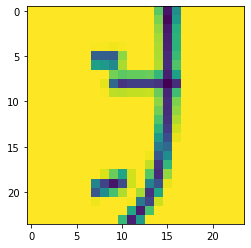

丬
丬 (10, 2, 20, 27)


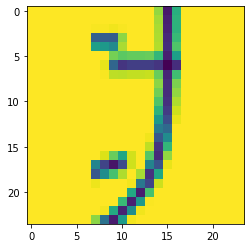

功 {'丬': (10, 0, 20, 25)}
加 {}
务 {}
劢 {}
劣 {}
劦 {}
云
动 {}
上
且
且
助 {}
双
努 {}
去
去
去
劫 {}
劬 {}
召
劭 {}
励 {}
功
圣
劲 {}
劳 {}
交
交
効 {}
劻 {}
吉
吉
卓
劼 {}
亥
亥
亥
劾 {}
专
势 {}
勀 {}
圣
办
勁 {}
勃 {}
丬
丬 (0, 2, 10, 27)


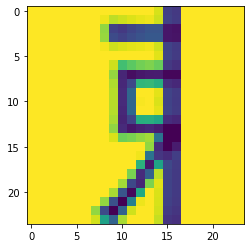

喇
勅 {'丬': (0, 2, 10, 27)}
勇 {}
勉 {}
员
勋 {}
京
哀
党
勍 {}
勐 {}
堇
勒 {}
垂
垂
動 {}
冒
冒
冒
哥
勖 {}
喜
助
助
且
呈
勗 {}
其
其
勘 {}
予
务
務 {}
哥
冒
勖
勛 {}
呼
唪
叻
勝 {}
兰
勞 {}
募 {}
勘
办
勠 {}
勢 {}
圊
勣 {}
堇
堇
堇
勤 {}
割
卧
勦 {}
勩 {}
勰 {}
堇
办
勱 {}
判
勳 {}
哥
哥
勴 {}
且
勵 {}
儴
办
勷 {}
奢
堇
堇
勸 {}
勹 {}
勺 {}
勻 {}
夕
夕 (4, 2, 14, 27)


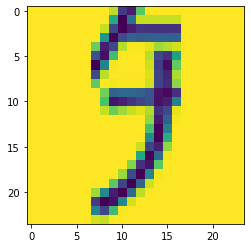

勼 {'夕': (4, 2, 14, 27)}
今
么
勾 {}
勿 {}
匀 {}
夕
夕 (4, 0, 14, 25)


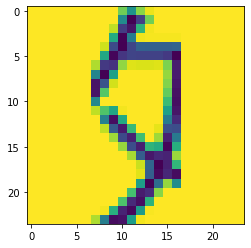

夕
夕 (4, 2, 14, 27)


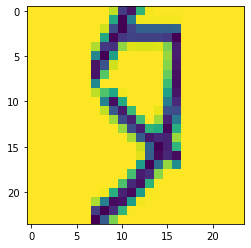

丁
匁 {'夕': (4, 0, 14, 25)}
乍
包 {}
夕
夕 (2, 0, 12, 25)


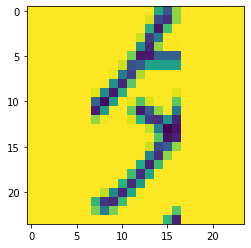

夕
夕 (4, 0, 14, 25)


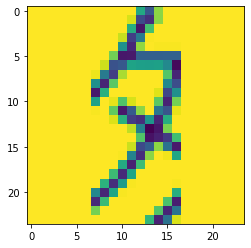

匆 {'夕': (2, 0, 12, 25)}
亻
亻 (0, 0, 10, 25)


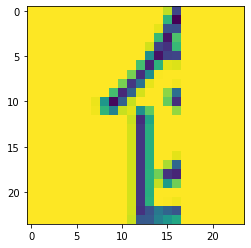

仓
匈 {'亻': (0, 0, 10, 25)}
今
哥
匊 {}
哥
匋 {}
冒
匍 {}
匏 {}
中
奢
冒
哥
匐 {}
哥
匑 {}
匕 {}
亻
亻 (0, 0, 10, 25)


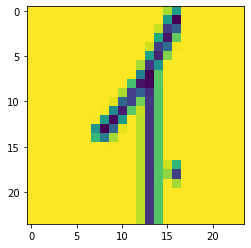

亻
亻 (0, 2, 10, 27)


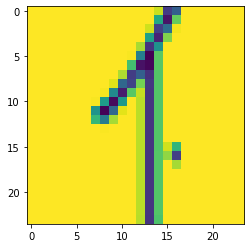

亻
亻 (2, 0, 12, 25)


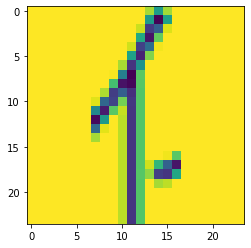

匕
匕 (16, 2, 26, 27)


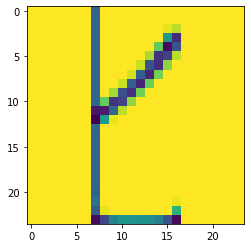

化 {'亻': (0, 0, 10, 25), '匕': (16, 2, 26, 27)}
北 {}
匙 {}
匚 {}
匜 {}
匝 {}
匹
匟 {}
厅
匠 {}
匡 {}
中
匣 {}
啣
匦 {}
啡
啡
匪 {}
匭 {}
号
勇
匮 {}
匯 {}
咠
冒
亘
匰 {}
冒
冒
冒
匱 {}
冒
匴 {}
匸 {}
卩
卩 (0, 0, 10, 25)


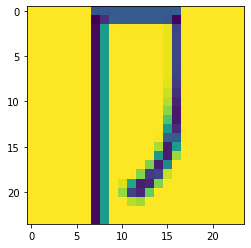

匹 {'卩': (0, 0, 10, 25)}
冫
冫 (2, 12, 12, 22)


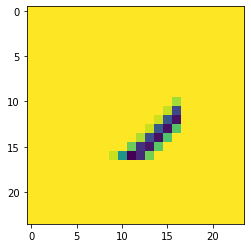

夕
夕 (6, 0, 16, 25)


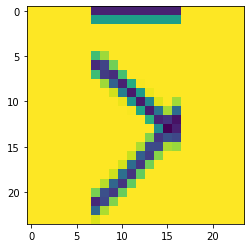

又
又 (10, 0, 20, 25)


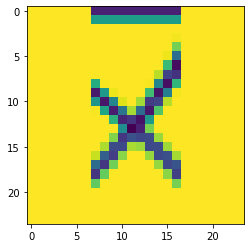

凶
区 {'冫': (2, 12, 12, 22), '夕': (6, 0, 16, 25), '又': (10, 0, 20, 25)}
午
医 {}
匼 {}
夏
匽 {}
匾 {}
匿 {}
卣
呈
區 {}
十 {}
千 {}
十
十 (4, 0, 14, 25)


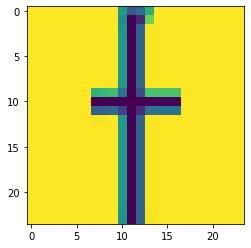

十
十 (4, 2, 14, 27)


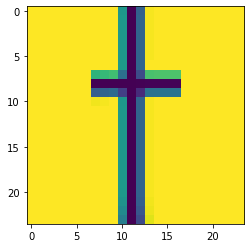

卜
卜 (8, 0, 18, 25)


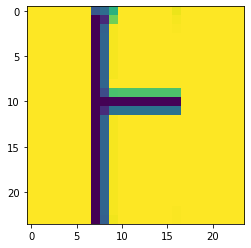

卜
卜 (8, 2, 18, 27)


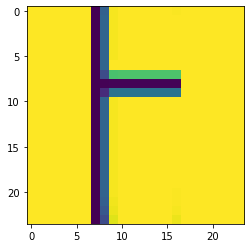

卄 {'十': (4, 0, 14, 25), '卜': (8, 0, 18, 25)}
卄
十
十 (10, 2, 20, 27)


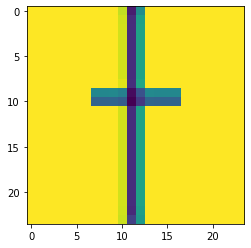

卄
卅 {'十': (10, 2, 20, 27)}
卅
冫
冫 (0, 16, 10, 26)


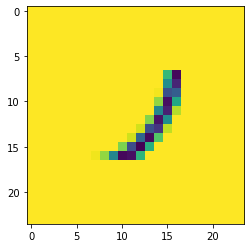

于
升 {'冫': (0, 16, 10, 26)}
午
午 {}
升
午
卉 {}
乎
乎
乎
乎
半
半 {}
十
十 (12, 2, 22, 27)


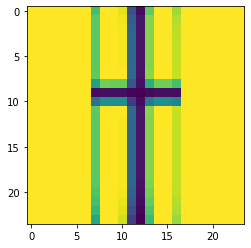

卌 {'十': (12, 2, 22, 27)}
卍 {}
华 {}
十
十 (0, 0, 10, 25)


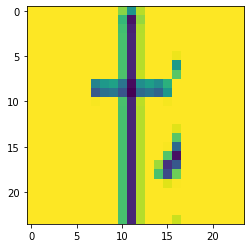

协 {'十': (0, 0, 10, 25)}
卑 {}
卒 {}
写
卓 {}
協 {}
中
单 {}
哥
卖 {}
南 {}
博 {}
卜 {}
卞
亠
亠 (2, 0, 27, 10)


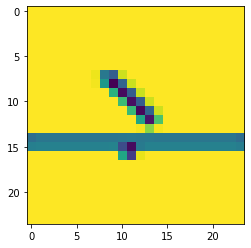

卞
卞
卞
卞
卜
卜 (12, 12, 22, 22)


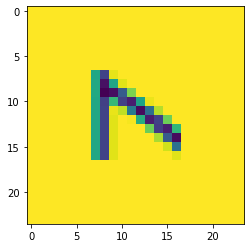

卞 {'亠': (2, 0, 27, 10), '卜': (12, 12, 22, 22)}
卜
卜 (14, 0, 24, 25)


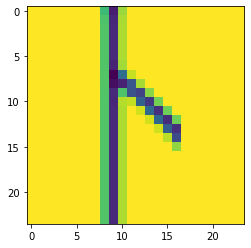

卜
卜 (16, 0, 26, 25)


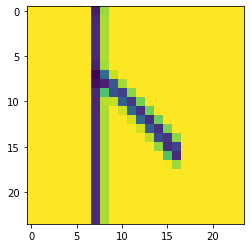

卜
卜 (16, 2, 26, 27)


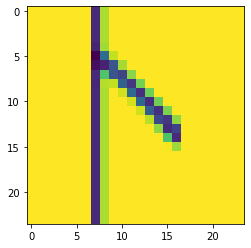

卟 {'卜': (14, 0, 24, 25)}
占 {}
卞
上
卞
卡
卡
卡
卡 {}
卢 {}
卣 {}
卤 {}
卦
卜
卜 (16, 0, 26, 25)


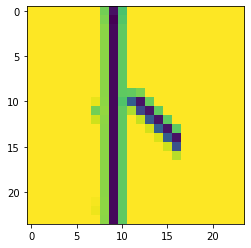

卦 {'卜': (16, 0, 26, 25)}
卦
卟
卜
卜 (16, 0, 26, 25)


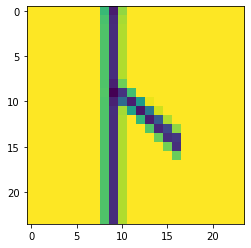

卜
卜 (16, 2, 26, 27)


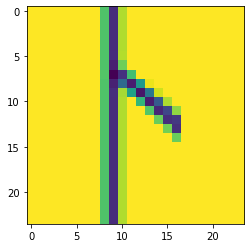

卧 {'卜': (16, 0, 26, 25)}
卩 {}
上
卫 {}
卩
卩 (16, 0, 26, 25)


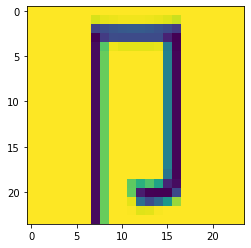

卩
卩 (16, 2, 26, 27)


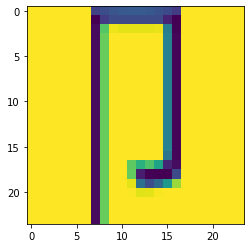

卬 {'卩': (16, 0, 26, 25)}
卮 {}
卩
卩 (16, 0, 26, 25)


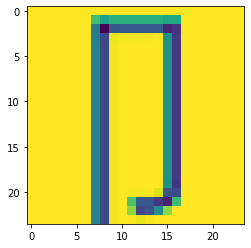

卩
卩 (16, 2, 26, 27)


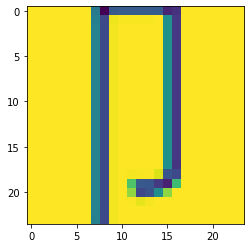

卯 {'卩': (16, 0, 26, 25)}
三
丬
丬 (8, 2, 18, 27)


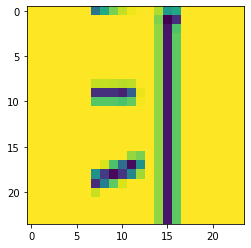

卩
卩 (16, 2, 26, 27)


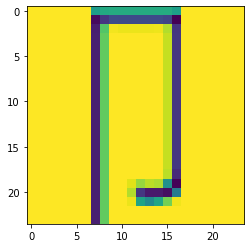

印 {'丬': (8, 2, 18, 27), '卩': (16, 2, 26, 27)}
危 {}
召
卲 {}
即 {}
勾
去
去
却 {}
卩
卩 (16, 2, 26, 27)


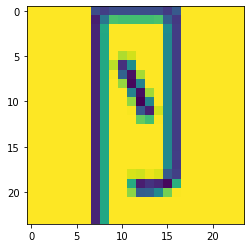

卵 {'卩': (16, 2, 26, 27)}
卷 {}
且
卸 {}
卹
卩
卩 (16, 2, 26, 27)


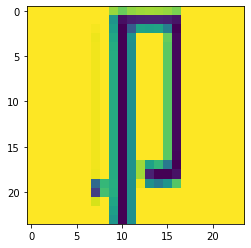

卹 {'卩': (16, 2, 26, 27)}
丞
卺 {}
卻 {}
圳
即
卿 {}
厂 {}
厄 {}
亓
厅 {}
于
历 {}
厉 {}
上
压 {}
上
冫
冫 (6, 14, 16, 24)


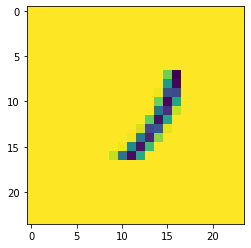

于
厌 {'冫': (6, 14, 16, 24)}
厍 {}
丘
丘
厎 {}
嗌
厔 {}
厕 {}
厖 {}
垂
垂
且
厘 {}
厙 {}
厚 {}
些
厝 {}
原 {}
回
具
具
哥
厠 {}
厢 {}
冒
冒
冒
厣 {}
厤 {}
厥 {}
冒
厦 {}
厨 {}
厩 {}
冒
冒
哥
厭 {}
其
厮 {}
喜
堇
厲 {}
匣
冒
壓
厴 {}
厶 {}
厹 {}
去
去 {}
且
县 {}
叁 {}
参 {}
參
參 {}
又 {}
叉 {}
及
久
及 {}
囚
友 {}
双 {}
反 {}
冫
冫 (0, 12, 10, 22)


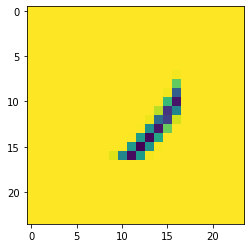

太
发 {'冫': (0, 12, 10, 22)}
卸
卡
卡
卡
叔 {}
且
取 {}
受
受
受
受 {}
亦
变
变
变
变 {}
到
余
余
余
叙 {}
听
叛 {}
叟 {}
叠 {}
嗜
叡 {}
乎
取
叢 {}
口 {}
古 {}
句 {}
中
另 {}
叨 {}
叩 {}
凵
凵 (2, 6, 27, 16)


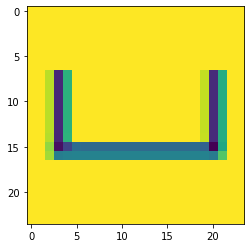

只 {'凵': (2, 6, 27, 16)}
丬
丬 (16, 0, 26, 25)


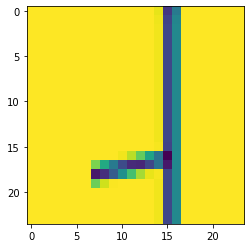

丬
丬 (16, 2, 26, 27)


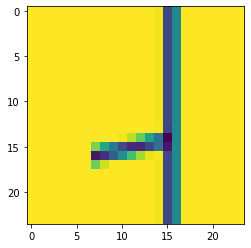

叫 {'丬': (16, 0, 26, 25)}
召
召 {}
叭
叭 {}
叮 {}
可 {}
冫
冫 (0, 0, 10, 10)


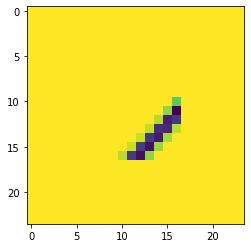

中
台 {'冫': (0, 0, 10, 10)}
叱 {}
中
史 {}
右 {}
叵 {}
十
十 (14, 2, 24, 27)


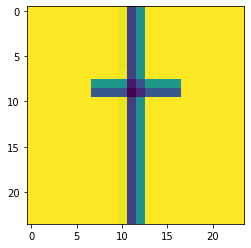

叶 {'十': (14, 2, 24, 27)}
亏
中
亏
号 {}
中
中
司 {}
义
又
又 (14, 0, 24, 25)


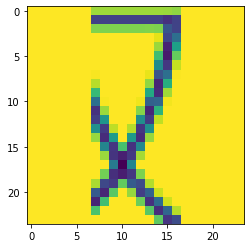

叹 {'又': (14, 0, 24, 25)}
叻 {}
冫
冫 (10, 0, 20, 25)


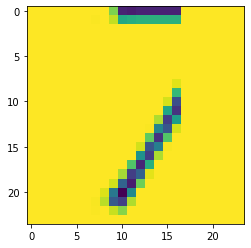

冫
冫 (10, 2, 20, 27)


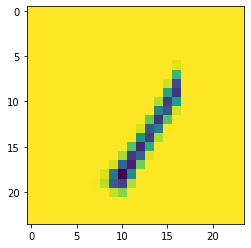

冫
冫 (10, 8, 20, 18)


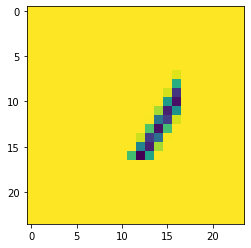

冫
冫 (10, 10, 20, 20)


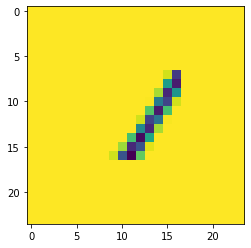

冫
冫 (12, 6, 22, 16)


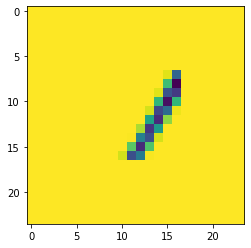

叼 {'冫': (10, 0, 20, 25)}
叽 {}
吁 {}
吃
吃 {}
各 {}
乡
乡
么
吆 {}
冫
冫 (2, 0, 12, 10)


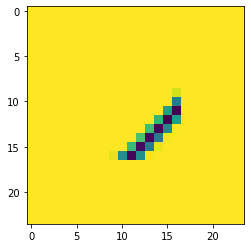

合 {'冫': (2, 0, 12, 10)}
中
吉 {}
中
吊 {}
吋
吋 {}
同 {}
夕
夕 (2, 4, 27, 14)


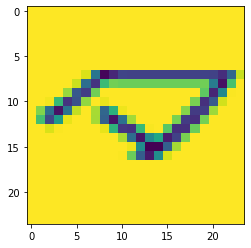

名 {'夕': (2, 4, 27, 14)}
后 {}
中
吏 {}
十
十 (14, 2, 24, 27)


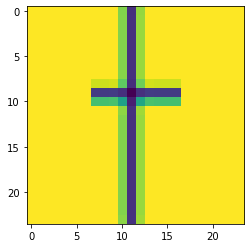

吐 {'十': (14, 2, 24, 27)}
向 {}
吒 {}
下
卜
卜 (16, 0, 26, 25)


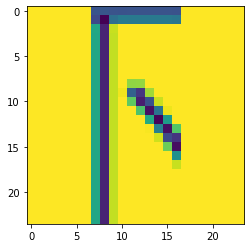

卜
卜 (16, 2, 26, 27)


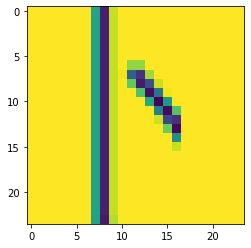

卜
卜 (16, 6, 26, 16)


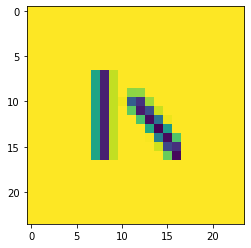

吓 {'卜': (16, 0, 26, 25)}
中
吕 {}
丁
丫
丫
丫
吖 {}
吗 {}
午
午
吘 {}
丬
丬 (0, 2, 10, 27)


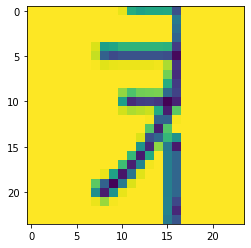

升
君 {'丬': (0, 2, 10, 27)}
吝 {}
吞
吞 {}
今
今
今
今
吟 {}
丬
丬 (8, 0, 18, 25)


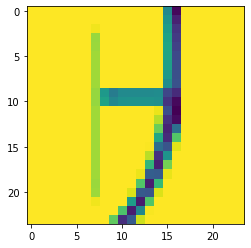

吠 {'丬': (8, 0, 18, 25)}
卄
吡 {}
吣 {}
亻
亻 (8, 0, 18, 25)


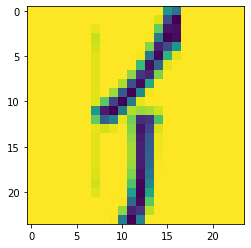

冫
冫 (8, 0, 18, 10)


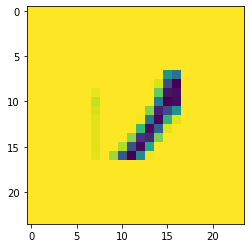

介
介
个
吤 {'亻': (8, 0, 18, 25), '冫': (8, 0, 18, 10)}
呸
亻
亻 (10, 2, 20, 27)


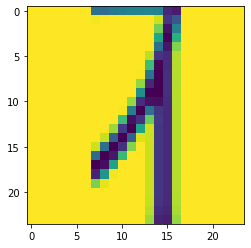

个
下
卜
卜 (16, 2, 26, 27)


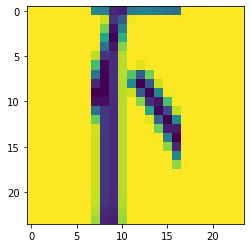

吥 {'亻': (10, 2, 20, 27), '卜': (16, 2, 26, 27)}
中
否 {}
卩
卩 (10, 0, 20, 25)


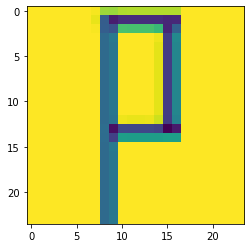

吧 {'卩': (10, 0, 20, 25)}
中
吨 {}
吩 {}
亻
亻 (8, 0, 18, 25)


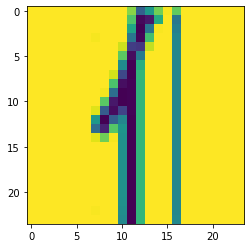

亻
亻 (8, 2, 18, 27)


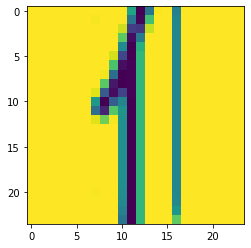

吪 {'亻': (8, 0, 18, 25)}
今
含
含
含
含 {}
听 {}
卞
吭 {}
吮 {}
启 {}
吱 {}
吲 {}
与
与
吳 {}
吴 {}
吵 {}
吶 {}
吸 {}
吹 {}
勿
吻 {}
吼 {}
吐
件
吽 {}
吾 {}
呀 {}
中
卑
呂 {}
呃 {}
呅 {}
中
呆 {}
丞
丞
呇 {}
中
呈 {}
台
台
告 {}
呋 {}
听
听
卜
卜 (10, 2, 20, 27)


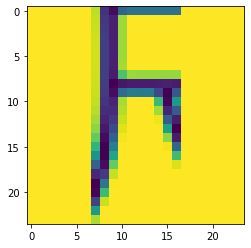

呎 {'卜': (10, 2, 20, 27)}
呐 {}
呒 {}
卅
呓 {}
太
呔 {}
呕 {}
于
呖 {}
呗 {}
中
员 {}
中
呙 {}
亻
亻 (8, 0, 18, 25)


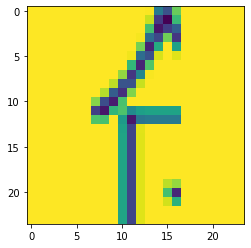

呛 {'亻': (8, 0, 18, 25)}
呜 {}
仲
乍
呢 {}
令
令
今
呤 {}
呦 {}
上
呧 {}
周 {}
卩
卩 (14, 0, 24, 25)


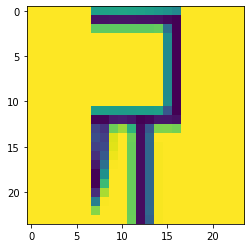

呪 {'卩': (14, 0, 24, 25)}
吐
占
占
呫 {}
业
业 (8, 2, 18, 27)


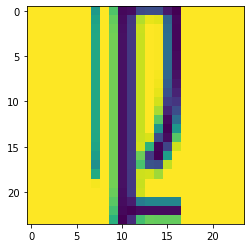

亚
呬 {'业': (8, 2, 18, 27)}
哑
哑
丹
呯 {}
乒
些
卓
呰 {}
丁
呱 {}
业
业 (8, 2, 18, 27)


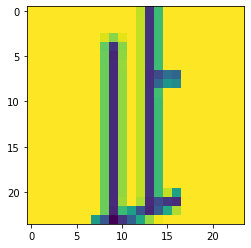

呲 {'业': (8, 2, 18, 27)}
呸
丬
丬 (8, 0, 18, 25)


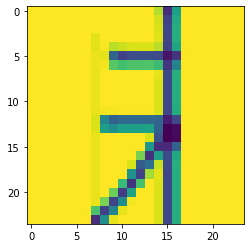

丬
丬 (8, 2, 18, 27)


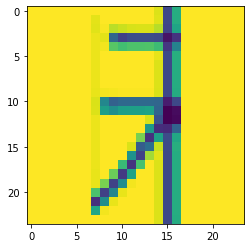

卡
味 {'丬': (8, 0, 18, 25)}
呴 {}
呵 {}
呶 {}
井
呷 {}
亻
亻 (10, 2, 20, 27)


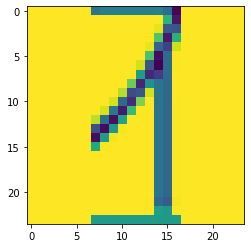

亻
亻 (12, 2, 22, 27)


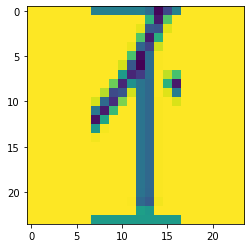

个
呸 {'亻': (10, 2, 20, 27)}
呻 {}
丹
呼 {}
今
卞
命 {}
吐
去
去
呿 {}
上
丬
丬 (14, 2, 24, 27)


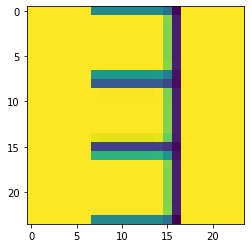

丬
丬 (16, 2, 26, 27)


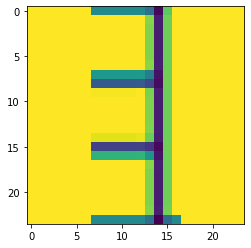

咀 {'丬': (14, 2, 24, 27)}
丬
丬 (14, 0, 24, 25)


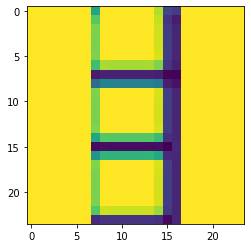

咁 {'丬': (14, 0, 24, 25)}
咂 {}
咄 {}
咆 {}
咇 {}
咈 {}
乍
咋 {}
丬
丬 (0, 0, 10, 25)


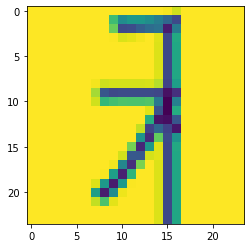

丬
丬 (0, 2, 10, 27)


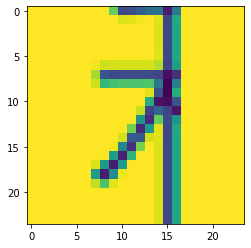

卜
卜 (8, 2, 18, 27)


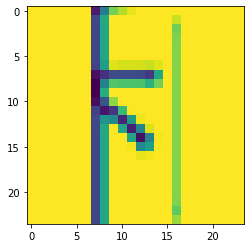

和 {'丬': (0, 0, 10, 25), '卜': (8, 2, 18, 27)}
台
台
咍 {}
卜
卜 (16, 2, 26, 12)


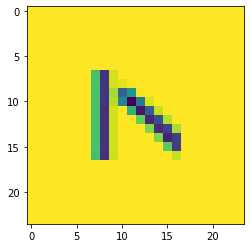

咎 {'卜': (16, 2, 26, 12)}
咏 {}
个
咐 {}
咑 {}
咒 {}
吓
卡
卡
卡
卡
咔 {}
咕 {}
咖 {}
咙 {}
冬
冬
冬
咚 {}
卞
卞
咛 {}
么
咝 {}
卑
冒
咠 {}
上
且
咡 {}
亏
亏
嘗
咢 {}
丬
丬 (10, 0, 20, 25)


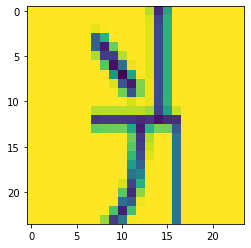

咣 {'丬': (10, 0, 20, 25)}
咤 {}
全
咥 {}
勇
夷
夷
咦 {}
夕
夕 (8, 2, 18, 27)


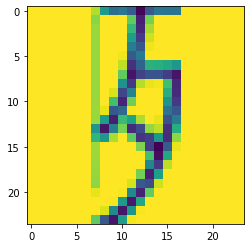

夕
夕 (10, 2, 20, 27)


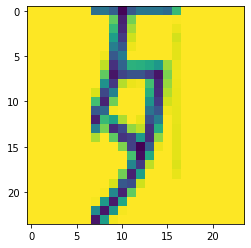

咧 {'夕': (8, 2, 18, 27)}
咨 {}
咩 {}
丬
丬 (8, 0, 18, 25)


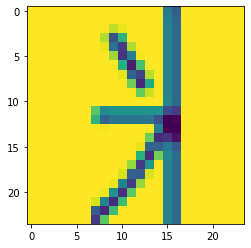

丬
丬 (8, 2, 18, 27)


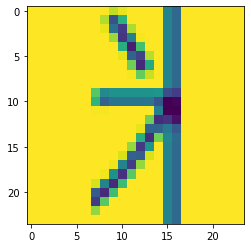

咪 {'丬': (8, 0, 18, 25)}
咫 {}
交
交
交
咬 {}
咭 {}
吃
丬
丬 (8, 0, 18, 25)


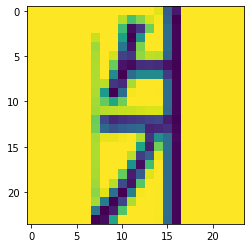

咮 {'丬': (8, 0, 18, 25)}
咯 {}
咱 {}
亥
亥
亥
亥
亥
咳 {}
咴 {}
咶 {}
哑
哑
哑
哑
哑
丬
丬 (8, 0, 18, 25)


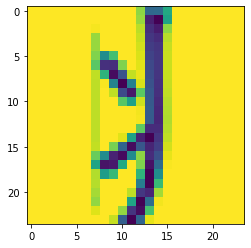

丬
丬 (8, 2, 18, 27)


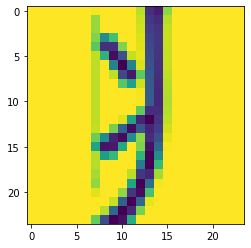

咷 {'丬': (8, 0, 18, 25)}
咸 {}
听
咺 {}
咿
咻 {}
咼 {}
咽 {}
唔
咾 {}
伊
伊
咿 {}
哀 {}
亡
品 {}
哂 {}
哃 {}
哄 {}
多
多
哆 {}
丬
丬 (8, 0, 18, 25)


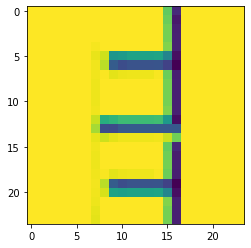

哇 {'丬': (8, 0, 18, 25)}
哈 {}
哉 {}
哌 {}
响 {}
哎 {}
卡
卡
哏 {}
听
哐 {}
哑
哑
哑 {}
吵
哒 {}
哓 {}
哔 {}
专
哕 {}
哖 {}
华
哗 {}
会
会
哙 {}
哚
哚 {}
产
哜 {}
农
哝 {}
哞 {}
哟 {}
哠 {}
卑
卑
套
亭
員 {}
哢 {}
哥
哥
哥 {}
哦 {}
卡
卡
哧 {}
呼
哨 {}
哩 {}
哪
哪
哪
哪 {}
卩
卩 (14, 0, 24, 25)


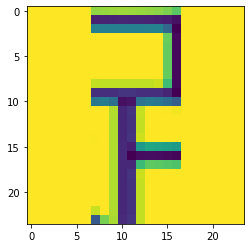

卩
卩 (16, 0, 26, 25)


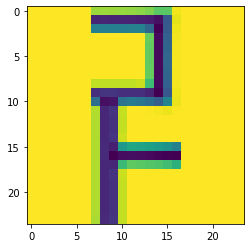

哫 {'卩': (14, 0, 24, 25)}
哭 {}
哮 {}
哱 {}
哲 {}
哳 {}
哺 {}
哼
亨
亨
哼 {}
哽 {}
哿 {}
唁 {}
唄 {}
呐
囚
仓
囚
含
含
含
含
唅 {}
唆 {}
唇
唇
唇 {}
呈
唈 {}
唉 {}
唊 {}
叵
亚
唌 {}
唎 {}
唏 {}
唐 {}
唑 {}
唔 {}
上
受
唚 {}
专
唛 {}
唠 {}
唢 {}
唣 {}
唤 {}
即
唧 {}
唪
唪
唪 {}
卓
唬 {}
事
其
其
其
唭 {}
售 {}
唯 {}
唰 {}
唱 {}
唲 {}
唳 {}
呻
唪
唵 {}
咋
唔
唶 {}
唷 {}
呐
吟
囚
令
含
唸 {}
卞
唹 {}
唻 {}
妾
妾
唼 {}
啣
垂
唾 {}
吻
吻
唿 {}
听
啀 {}
啁 {}
啃 {}
啄 {}
吁
啅 {}
商 {}
啉 {}
啊 {}
呸
啋 {}
哼
啍 {}
卡
卣
問 {}
啐 {}
啑 {}
啓 {}
啕 {}
啖 {}
啗 {}
啜 {}
啞 {}
啟 {}
啡 {}
啢 {}
啣 {}
啤 {}
全
全
啥 {}
啦 {}
壳
啧 {}
啪 {}
乎
啬 {}
专
专
啭 {}
啮 {}
俨
俨
啵 {}
卞
啶 {}
即
啷 {}
啸
啸 {}
中
啻 {}
啼 {}
含
啽 {}
啾 {}
其
啿 {}
喀 {}
喁 {}
卡
喂 {}
喃 {}
垂
垂
善
善 {}
吉
吉
喆 {}
圃
喇 {}
喈 {}
喉 {}
咸
咸
喊 {}
喋 {}
卡
卡
喌 {}
哥
哥
喎 {}
喏 {}
喑 {}
偺
喒 {}
哂
喓 {}
听
候
喔 {}
喘
喘 {}
修
修
喙 {}
乡
奐
奐
喚 {}
冒
喜 {}
喝 {}
喟 {}
喣 {}
喤 {}
喥 {}
中
卣
喦 {}
喧 {}
亭
喨 {}
前
奭
凰
喪 {}
专
专
契
契
喫 {}
冒
喬 {}
喭 {}
咠
單 {}
喰 {}
听
丁
喱 {}
唿
喲 {}
呸
喳 {}
喵 {}
喷 {}
喹 {}
俞
俞
俞
俞
喻 {}
喽 {}
喾 {}
喿 {}
女
女 (14, 2, 24, 27)


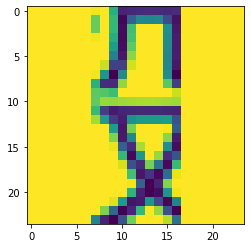

嗀 {'女': (14, 2, 24, 27)}
嗃 {}
嗄 {}
嗅 {}
囚
今
嗆 {}
乎
向
傘
写
哥
嗇 {}
嗉 {}
冒
嗊 {}
嗋 {}
侐
嗌 {}
剪
嗍 {}
具
嗎 {}
嗐 {}
嗑 {}
嗒 {}
修
修
嗓 {}
嗔 {}
嗖 {}
卡
写
哥
嗚 {}
嗛 {}
嗜 {}
嗝 {}
嗟 {}
嗡 {}
嗢 {}
嗣 {}
嗤 {}
哼
哀
嗥 {}
嗦 {}
今
冒
嗧 {}
嗨 {}
党
嗩 {}
冒
冒
嗪 {}
叟
凝
嗫 {}
嗬
嗬 {}
嗯 {}
嗲 {}
嗳 {}
嗵 {}
嗶 {}
嗷 {}
嗹 {}
嗽 {}
嗾 {}
吟
含
含
今
嗿 {}
嘀 {}
一
一 (0, 0, 25, 10)


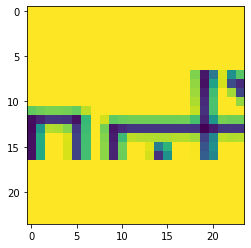

嘁 {'一': (0, 0, 25, 10)}
哑
嗢
嘂 {}
冒
嘄 {}
堇
嘆 {}
售
嘈 {}
冒
嘉 {}
哂
唁
嘌
嘌 {}
唐
嘍 {}
嘎 {}
嘏 {}
嘐 {}
嘒 {}
嘓
嘓 {}
吧
侐
嘔 {}
冒
嘖 {}
亭
亭
亭
嘗
嘗
嘗
嘗
嘗
亭
嘗 {}
嘘 {}
嘛 {}
唊
嘜 {}
哂
嘞 {}
嘟
嘟
嘟
嘟 {}
嘣 {}
嘤
嘤
嘤 {}
嘧 {}
唾
嘩 {}
冒
嘬 {}
嘭
嘭 {}
啤
勞
勞
嘮 {}
啷
冒
埭
嘯 {}
咴
倏
倏
嘰 {}
嘱 {}
嘲 {}
冑
嘳 {}
呲
嘴 {}
嘵 {}
其
嘶 {}
嘸 {}
嘹 {}
喜
嘻 {}
堂
嘽 {}
呼
半
半
嘿 {}
噀 {}
吣
噁 {}
哂
哼
喾
噂 {}
噅 {}
噆 {}
噉 {}
咋
噌 {}
噍 {}
冒
冒
噎 {}
噓 {}
咋
噔 {}
噗 {}
噘 {}
噙 {}
乒
噚 {}
噜 {}
噞 {}
噠 {}
噢 {}
冒
党
噣 {}
噤 {}
噥 {}
噦 {}
冒
器 {}
冒
响
响
哥
哥
哥
噩
噩
冒
噩 {}
噪 {}
噫 {}
噬 {}
包
噭 {}
噯 {}
噰 {}
噱 {}
噌
亘
噲 {}
冒
冒
噳 {}
噴 {}
噶 {}
冲
噸 {}
嘗
嘗
堂
嘗
嘗
噹 {}
呵
啋
亲
噺 {}
噻 {}
噼 {}
嚀 {}
售
售
厘
喾
嚄 {}
嚅 {}
嚆 {}
嚇 {}
嚌 {}
嚎 {}
嚏 {}
嘗
嘗
嘗
嘗
嘗
嚐 {}
嚓 {}
嚕 {}
嚙 {}
冒
亭
冒
嚚 {}
呼
呼
墨
墨
堂
嚜 {}
嚝 {}
嚣 {}
嚥
嚥 {}
嚦 {}
冒
冒
嚧 {}
嚨 {}
具
嚫 {}
嚬 {}
喜
喜
否
嚭 {}
嚮 {}
唯
冒
嚯 {}
嚲 {}
嚳 {}
冒
嚴 {}
嚵 {}
嚶 {}
嚷 {}
嚼 {}
唯
唯
冒
堇
嚾 {}
哂
囀 {}
呈
囁 {}
冒
冒
嘗
嘗
冒
亘
囂 {}
囃 {}
單
匣
囅 {}
囈 {}
囉 {}
冒
冒
冒
囊 {}
丐
嘗
囋 {}
囌 {}
喜
喜
喜
囍 {}
囑 {}
囓 {}
囔 {}
囗 {}
囚
囚 {}
上
四 {}
上
囝 {}
回 {}
囟 {}
去
因 {}
囡 {}
上
团 {}
囤 {}
四
四
囥 {}

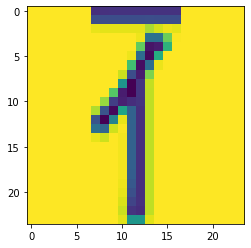

亻
亻 (4, 2, 14, 27)


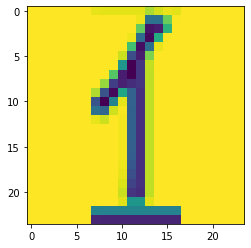

囮 {'亻': (4, 0, 14, 25)}
上
困 {}
囱 {}
上
哥
围 {}
仓
囵 {}
上
囷 {}
上
吟
今
囹 {}
固 {}
上
国 {}
冬
冬
冬
冬
图 {}
囿 {}
哥
哥
圁 {}
圂 {}
哥
圃 {}
唔
圄 {}
匙
圆 {}
吟
圇 {}
唪
圈 {}
上
圉 {}
哥
圊 {}
國 {}
上
哥
哥
圌 {}
唔
冒
喜
匣
凰
圍 {}
冒
園 {}
唪
亘
哥
圓 {}
上
哥
圔 {}
上
冒
冒
哥
哥
圖 {}
哥
哥
團 {}
哥
圚 {}
上
哥
哥
圛 {}
上
受
哥
圜 {}
土 {}
丬
丬 (8, 0, 18, 25)


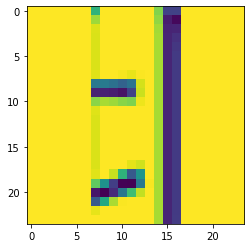

丬
丬 (8, 2, 18, 27)


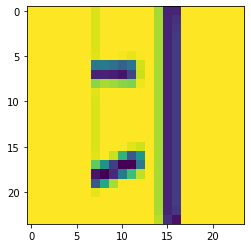

圠 {'丬': (8, 0, 18, 25)}
上
圢 {}
圣 {}
午
午
在 {}
圩 {}
圪 {}
圬 {}
圭 {}
圮 {}
圯 {}
地 {}
圳 {}
勺
圴 {}
圹 {}
场 {}
圻 {}
及
圾 {}
址 {}
坂 {}
吟
今
囚
今
今
今
今
坅 {}
均 {}
坊 {}
分
分
仓
坌 {}
坍 {}
坎 {}
协
不
不
坏 {}
咇
坐 {}
坑 {}
占
坒 {}
丬
丬 (8, 0, 18, 25)


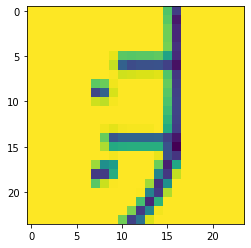

块 {'丬': (8, 0, 18, 25)}
圣
坚 {}
云
坛 {}
坜 {}
坝 {}
坞 {}
交
坟 {}
含
坠 {}
专
坡 {}
上
丬
丬 (10, 0, 20, 25)


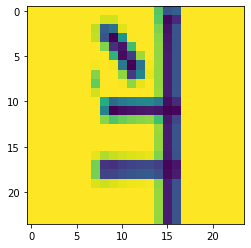

丬
丬 (10, 2, 20, 27)


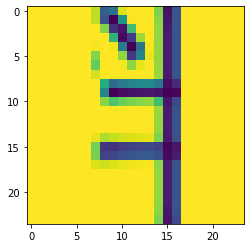

半
半
半
半
坢 {'丬': (10, 0, 20, 25)}
坤 {}
上
坦 {}
坨 {}
坩 {}
坪 {}
占
坫 {}
卩
卩 (16, 2, 26, 27)


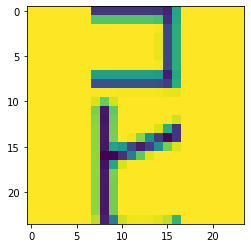

坭 {'卩': (16, 2, 26, 27)}
协
不
丕
坯 {}
坰 {}
坱 {}
坳 {}
坴 {}
坵 {}
坶 {}
坷 {}
坻 {}
坼 {}
垂 {}
垃 {}
垄 {}
垅 {}
垆 {}
型
型 {}
垌 {}
卒
垒 {}
亥
亥
亥
亥
亥
垓 {}
县
垔 {}
垕
垕
垕 {}
垗
丬
丬 (8, 0, 18, 25)


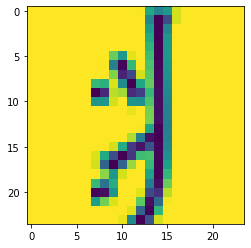

丬
丬 (8, 2, 18, 27)


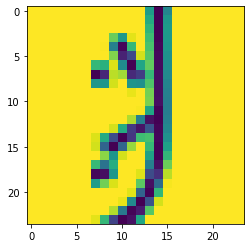

垗 {'丬': (8, 0, 18, 25)}
垭
垭
丬
丬 (8, 2, 18, 27)


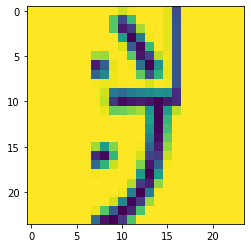

丬
丬 (10, 0, 20, 25)


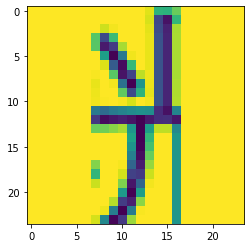

光
垙 {'丬': (8, 2, 18, 27)}
垚 {}
哚
垛 {}
丫
危
危
垝 {}
垞 {}
垟 {}
垠 {}
垡 {}
垢 {}
垣 {}
垤 {}
垦 {}
垧 {}
乎
垩 {}
垫 {}
亚
亚
垭 {}
垮 {}
垲 {}
垴 {}
垵 {}
垸 {}
之
之
上
垽 {}
埂 {}
埃 {}
埆 {}
埇 {}
埋 {}
埌 {}
城 {}
埏 {}
埒 {}
埔 {}
埕 {}
埘 {}
埙 {}
埚 {}
埜 {}
令
埝 {}
域 {}
埠 {}
埡 {}
埣 {}
埤 {}
埧 {}
埩 {}
埭 {}
埯 {}
哥
埰 {}
埳 {}
埴 {}
圃
垂
埵 {}
埶 {}
執 {}
埸 {}
培 {}
基 {}
埻 {}
奇
奇
埼 {}
埽 {}
堀 {}
堂 {}
堃 {}
堄 {}
些
凶
堅 {}
堆 {}
中
堇
堇 {}
堈 {}
堉 {}
堊 {}
啡
啡
堋 {}
固
回
堌 {}
堍 {}
堐 {}
堑 {}
咋
咋
堕 {}
堙 {}
冒
呈
冒
堛 {}
堝 {}
堞 {}
堠 {}
倬
卣
堡 {}
堣 {}
堤 {}
堧 {}
其
其
其
堪 {}
喻
备
俞
俞
俞
堬 {}
写
堭 {}
元
堯 {}
堰 {}
報 {}
堲
堲
业
业 (12, 2, 22, 27)


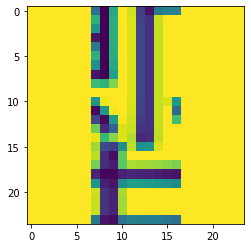

世
堲 {'业': (12, 2, 22, 27)}
冒
冒
堳 {}
号
場 {}
堵 {}
冒
堹 {}
堺 {}
堧
堽 {}
哥
哥
咸
堿 {}
塀 {}
塄 {}
士
士 (2, 16, 27, 26)


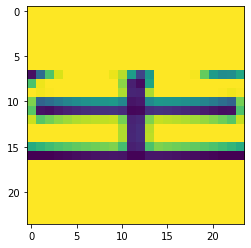

塈 {'士': (2, 16, 27, 26)}
墋
塉 {}
塊 {}
塋 {}
塌 {}
呼
堂
塍 {}
塏 {}
且
塑 {}
塒 {}
塔 {}
塕 {}
全
塗 {}
塘 {}
塙 {}
冢
冢
塚 {}
塞 {}
写
写
塢 {}
冒
冒
塤 {}
塥 {}
塩 {}
墨
填 {}
塬
塬 {}
塭 {}
卵
且
塱 {}
場
塲 {}
塵 {}
妻
塹 {}
塼 {}
坶
塽 {}
享
塾 {}
凄
塿 {}
墀 {}
冒
墁 {}
境 {}
墅 {}
墇 {}
勘
墈 {}
墉 {}
墊 {}
參
墋 {}
墏 {}
喜
堇
堇
墐 {}
墑 {}
墒 {}
卑
卑
墓 {}
墔 {}
墘 {}
墙 {}
墚 {}
墜 {}
墝 {}
增 {}
墟 {}
坶
回
墠 {}
墡 {}
党
墣 {}
乒
墦 {}
亨
墨 {}
墩 {}
喾
卓
墫 {}
卫
咋
冒
墮 {}
墱 {}
冒
亘
墳 {}
墺 {}
墻 {}
墼 {}
墾 {}
壁 {}
壅 {}
壇 {}
亘
壈 {}
厘
壎 {}
壑 {}
壒 {}
厨
壓
壓 {}
壽
壔 {}
壕 {}
墉
具
儒
壖 {}
中
冒
壘 {}
哂
壙 {}
册
冒
冒
壚 {}
冒
壜 {}
冑
壝 {}
壞 {}
哗
响
匪
冒
壟 {}
壢 {}
壤 {}
哥
哥
壩 {}
士 {}
壬 {}
丬
丬 (0, 0, 10, 25)


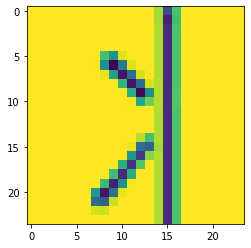

丬
丬 (0, 2, 10, 27)


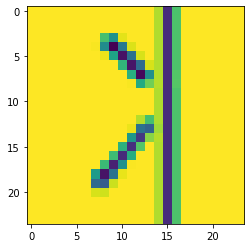

卜
卜 (8, 0, 18, 25)


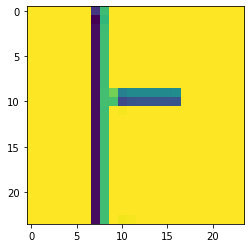

壮 {'丬': (0, 0, 10, 25), '卜': (8, 0, 18, 25)}
丬
丬 (2, 0, 12, 25)


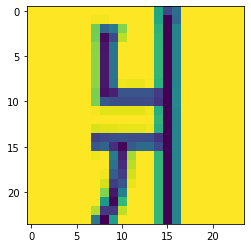

丬
丬 (2, 2, 12, 27)


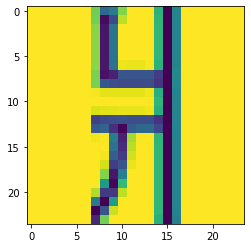

卄
壯 {'丬': (2, 0, 12, 25)}
声 {}
卓
売 {}
壳 {}
壴 {}
壶 {}
冒
冒
壹 {}
冒
冒
壺 {}
埏
壻 {}
垕
冒
冒
冒
冒
冒
冒
冒
壼 {}
冒
冒
冒
壽 {}
夂 {}
上
卜
卜 (16, 0, 26, 25)


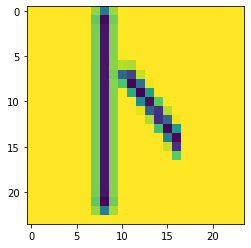

处 {'卜': (16, 0, 26, 25)}
夂
夂 (2, 2, 27, 12)


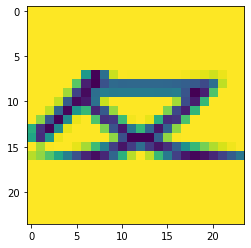

囚
夆 {'夂': (2, 2, 27, 12)}
备 {}
凶
凶
夕
夕 (0, 10, 25, 20)


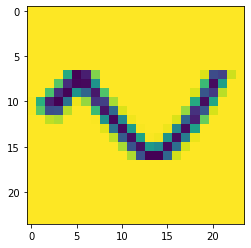

夕
夕 (6, 2, 16, 27)


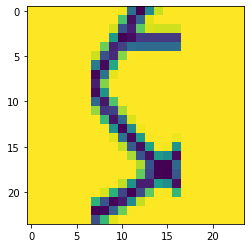

女
女 (8, 0, 18, 25)


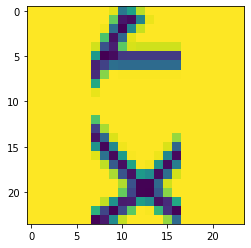

之
夊 {'夕': (0, 10, 25, 20), '女': (8, 0, 18, 25)}
夕
夕 (0, 16, 25, 26)


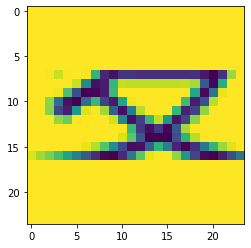

夌 {'夕': (0, 16, 25, 26)}
乍
复 {}
夂
夂 (2, 16, 27, 26)


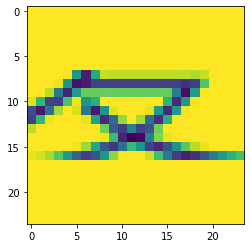

夏 {'夂': (2, 16, 27, 26)}
喻
夒 {}
哪
夔 {}
夕 {}
夕
夕 (2, 0, 12, 25)


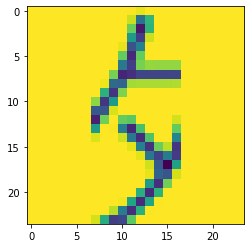

夕
夕 (2, 2, 12, 27)


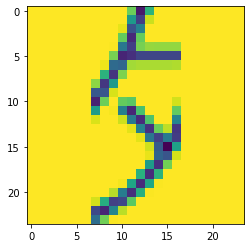

夕
夕 (4, 0, 14, 25)


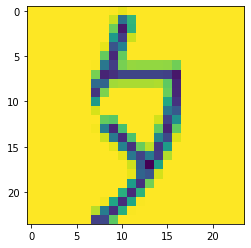

夕
夕 (4, 2, 14, 27)


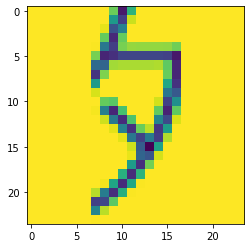

卜
卜 (16, 0, 26, 25)


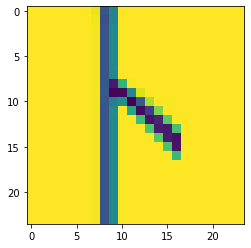

卜
卜 (16, 2, 26, 27)


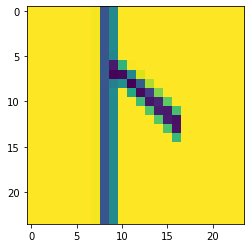

卜
卜 (16, 6, 26, 16)


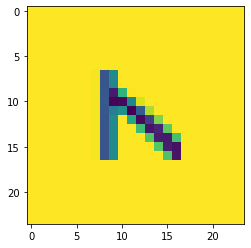

外 {'夕': (2, 0, 12, 25), '卜': (16, 0, 26, 25)}
夙
夙 {}
冫
冫 (0, 0, 10, 10)


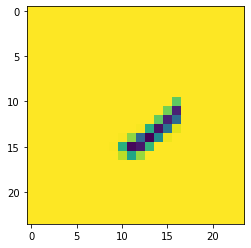

夕
夕 (2, 4, 27, 14)


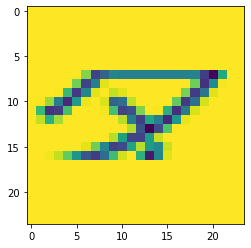

夕
夕 (2, 16, 27, 26)


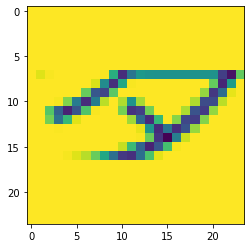

多 {'冫': (0, 0, 10, 10), '夕': (2, 4, 27, 14)}
夜 {}
多
多
够 {}
多
多
夠 {}
丐
夕
夕 (2, 16, 27, 26)


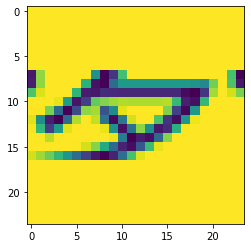

夢 {'夕': (2, 16, 27, 26)}
冒
冒
冒
夤 {}
多
多
夕
夕 (16, 14, 26, 24)


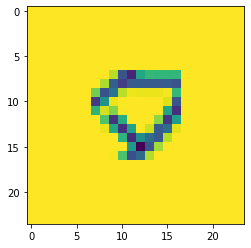

夥 {'夕': (16, 14, 26, 24)}
大 {}
冫
冫 (0, 16, 10, 26)


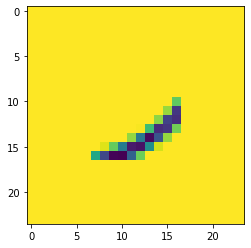

夭
天 {'冫': (0, 16, 10, 26)}
冫
冫 (0, 16, 10, 26)


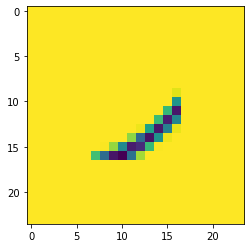

太
太
太 {'冫': (0, 16, 10, 26)}
夫 {}
再
丬
丬 (4, 0, 14, 25)


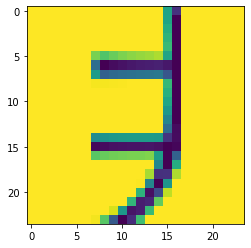

丬
丬 (4, 2, 14, 27)


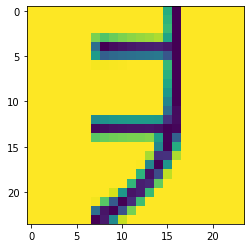

丬
丬 (6, 0, 16, 25)


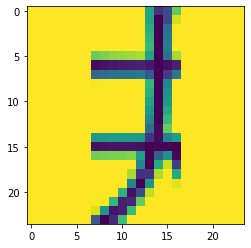

夫
夬 {'丬': (4, 0, 14, 25)}
夭
夭 {}
央 {}
夯 {}
冫
冫 (2, 16, 12, 26)


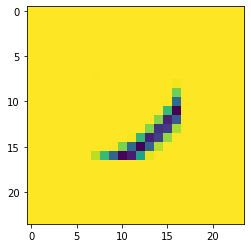

乡
乡
丬
丬 (6, 0, 16, 25)


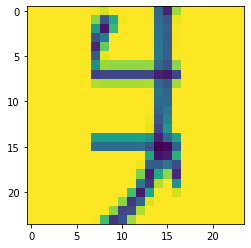

失 {'冫': (2, 16, 12, 26), '丬': (6, 0, 16, 25)}
丬
丬 (8, 0, 18, 25)


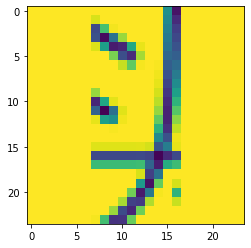

头
头
头 {'丬': (8, 0, 18, 25)}
夷 {}
亏
亏
夸 {}
乎
夹 {}
咨
午
夺 {}
个
个
夼 {}
夾 {}
乡
奀
奀 {}
奁 {}
奂 {}
奄 {}
冒
冒
吞
奅 {}
奇 {}
奈 {}
奉 {}
吞
全
奋 {}
奎 {}
奏 {}
奐
奐
奐 {}
契 {}
冒
奓 {}
丹
争
奔 {}
亦
奕 {}
奖
奖
奖 {}
套 {}
奘 {}
奚 {}
奠 {}
奡 {}
奢 {}
奥 {}
上
奧 {}
奩 {}
奪 {}
夼
奫 {}
冒
乖
哥
哥
奭
奭
冒
且
奭 {}
喜
堇
冒
奮 {}
奢
奢
奢
奢
奲 {}
女 {}
奴 {}
女
女 (2, 0, 12, 25)


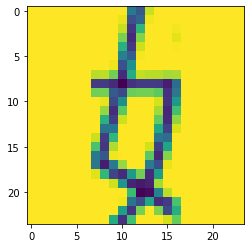

奶 {'女': (2, 0, 12, 25)}
女
女 (0, 0, 10, 25)


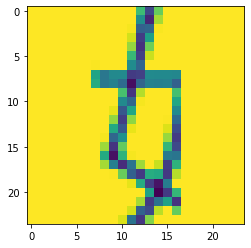

女
女 (2, 0, 12, 25)


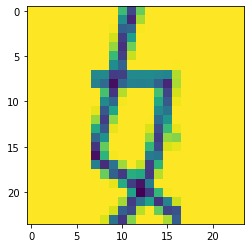

奸 {'女': (0, 0, 10, 25)}
女
女 (2, 0, 12, 25)


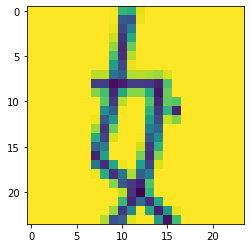

她 {'女': (2, 0, 12, 25)}
女
女 (2, 0, 12, 25)


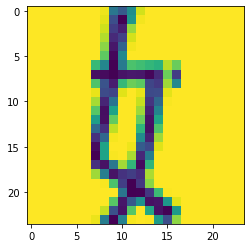

女
女 (14, 0, 24, 25)


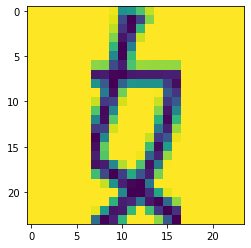

女
女 (14, 2, 24, 27)


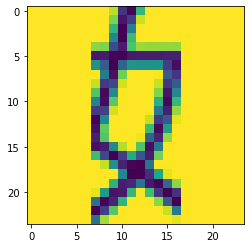

久
奻 {'女': (2, 0, 12, 25)}
奼 {}
女
女 (2, 0, 12, 25)


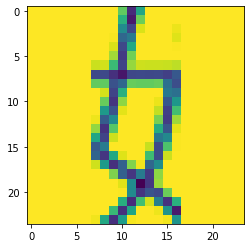

好 {'女': (2, 0, 12, 25)}
女
女 (2, 0, 12, 25)


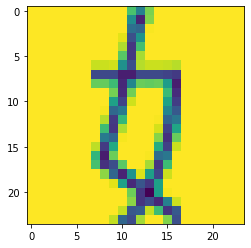

刈
妁 {'女': (2, 0, 12, 25)}
女
女 (4, 0, 14, 25)


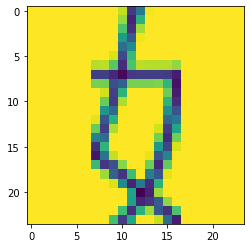

卩
卩 (16, 2, 26, 27)


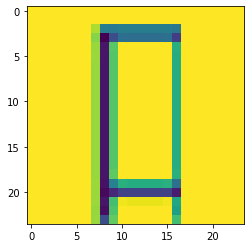

如 {'女': (4, 0, 14, 25), '卩': (16, 2, 26, 27)}
女
女 (0, 0, 10, 25)


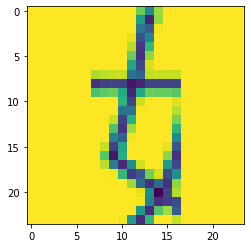

女
女 (2, 0, 12, 25)


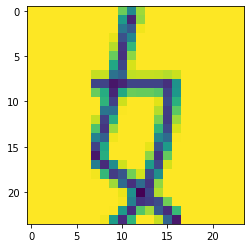

女
女 (2, 2, 12, 27)


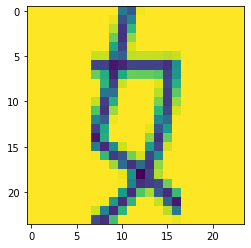

妃 {'女': (0, 0, 10, 25)}
女
女 (0, 12, 25, 22)


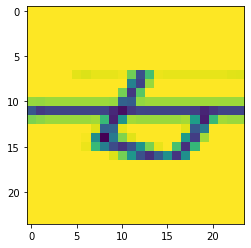

丹
女
女 (2, 12, 27, 22)


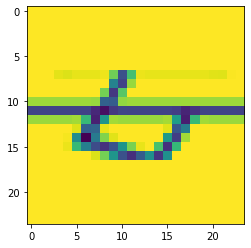

妄 {'女': (0, 12, 25, 22)}
丬
丬 (0, 0, 10, 25)


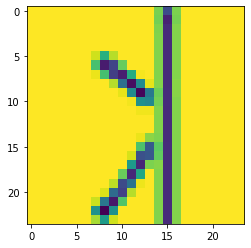

丬
丬 (0, 2, 10, 27)


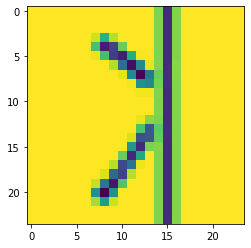

女
女 (12, 0, 22, 25)


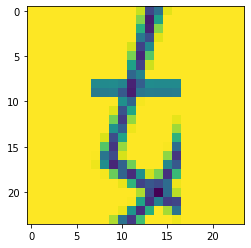

女
女 (12, 2, 22, 27)


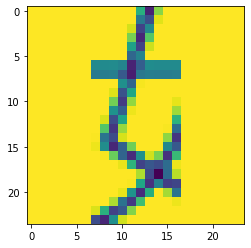

女
女 (14, 0, 24, 25)


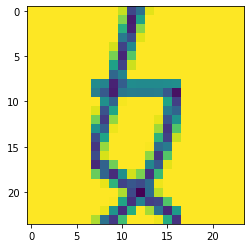

女
女 (14, 2, 24, 27)


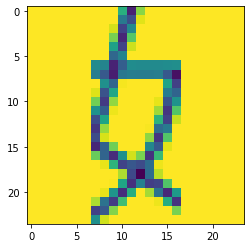

妆 {'丬': (0, 0, 10, 25), '女': (12, 0, 22, 25)}
女
女 (4, 0, 14, 25)


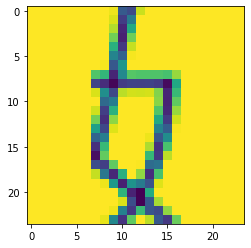

妇 {'女': (4, 0, 14, 25)}
女
女 (2, 0, 12, 25)


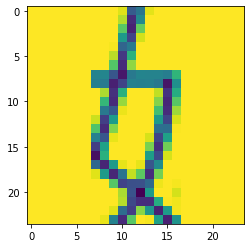

女
女 (2, 2, 12, 27)


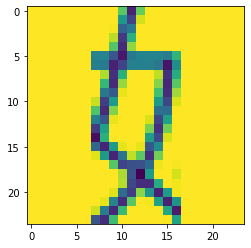

妈 {'女': (2, 0, 12, 25)}
女
女 (2, 0, 12, 25)


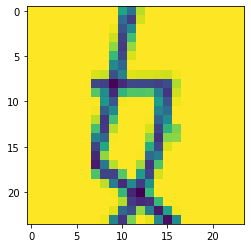

妊 {'女': (2, 0, 12, 25)}
刈
女
女 (2, 0, 12, 25)


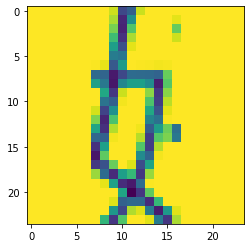

妍 {'女': (2, 0, 12, 25)}
刈
亻
亻 (10, 0, 20, 25)


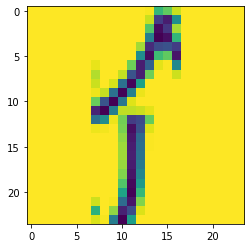

介
介
介
个
妎 {'亻': (10, 0, 20, 25)}
女
女 (2, 0, 12, 25)


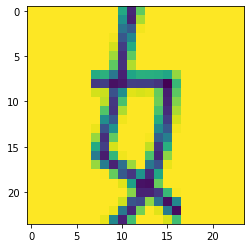

女
女 (4, 0, 14, 25)


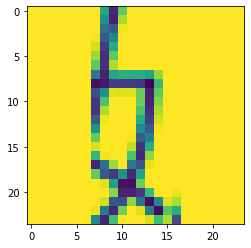

妒
妒 {'女': (2, 0, 12, 25)}
女
女 (0, 0, 10, 25)


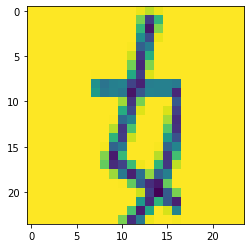

女
女 (0, 2, 10, 27)


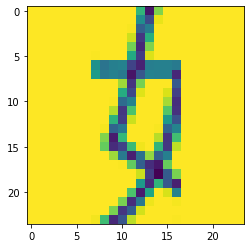

妓 {'女': (0, 0, 10, 25)}
女
女 (0, 0, 10, 25)


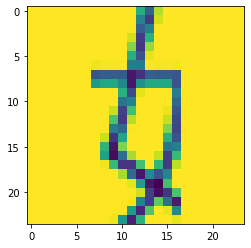

女
女 (2, 0, 12, 25)


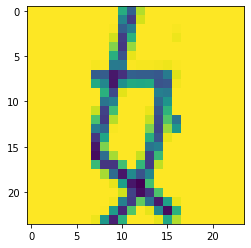

夭
夭
妖 {'女': (0, 0, 10, 25)}
女
女 (0, 0, 10, 25)


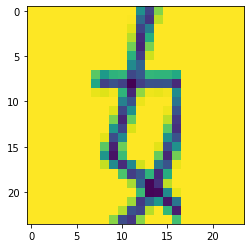

冲
女
女 (2, 0, 12, 25)


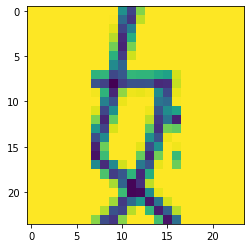

今
今
今
今
今
妗 {'女': (0, 0, 10, 25)}
云
云
妘 {}
冲
女
女 (2, 0, 12, 25)


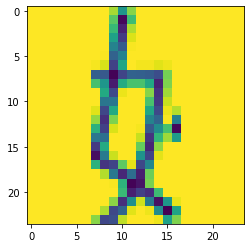

上
妙 {'女': (2, 0, 12, 25)}
丬
丬 (0, 0, 10, 25)


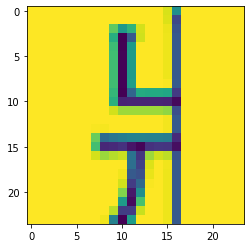

丬
丬 (0, 2, 10, 27)


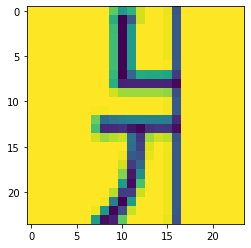

丬
丬 (2, 0, 12, 25)


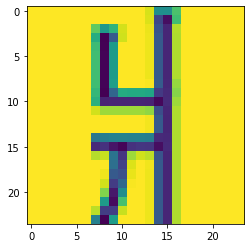

丬
丬 (2, 2, 12, 27)


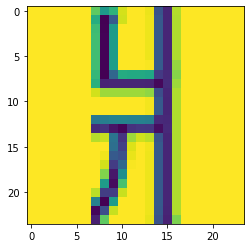

中
妆
女
女 (14, 0, 24, 25)


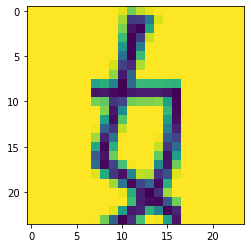

女
女 (14, 2, 24, 27)


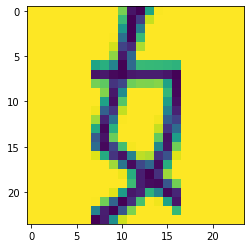

女
女 (16, 0, 26, 25)


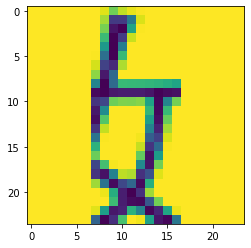

女
女 (16, 2, 26, 27)


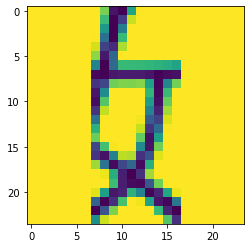

妝 {'丬': (0, 0, 10, 25), '女': (14, 0, 24, 25)}
妞 {}
女
女 (2, 0, 12, 25)


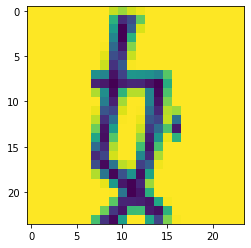

分
妢 {'女': (2, 0, 12, 25)}
女
女 (2, 0, 12, 25)


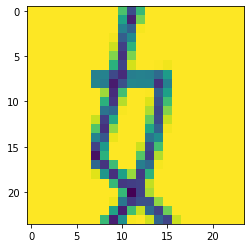

冰
卄
妣 {'女': (2, 0, 12, 25)}
女
女 (2, 0, 12, 25)


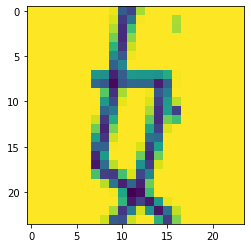

予
予
妤 {'女': (2, 0, 12, 25)}
女
女 (2, 12, 27, 22)


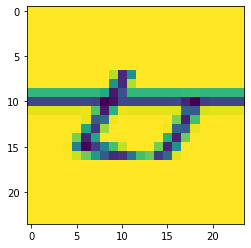

妥 {'女': (2, 12, 27, 22)}
亓
妧 {}
女
女 (0, 0, 10, 25)


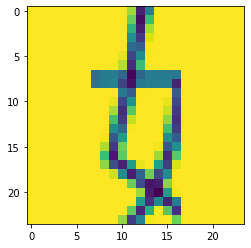

女
女 (2, 0, 12, 25)


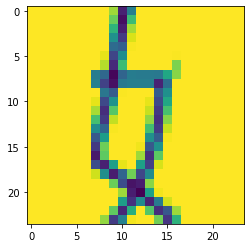

妨 {'女': (0, 0, 10, 25)}
女
女 (0, 0, 10, 25)


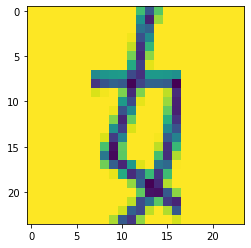

女
女 (2, 0, 12, 25)


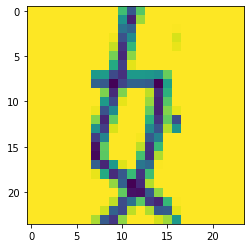

妩 {'女': (0, 0, 10, 25)}
女
女 (2, 0, 12, 25)


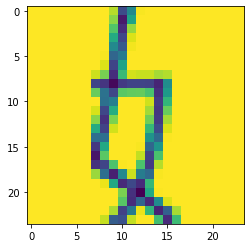

女
女 (2, 2, 12, 27)


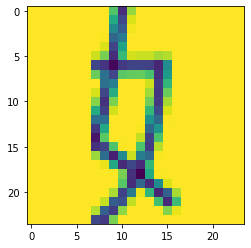

妪 {'女': (2, 0, 12, 25)}
女
女 (2, 0, 12, 25)


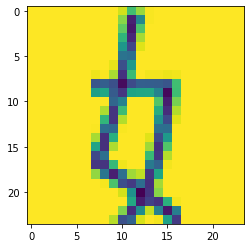

妫 {'女': (2, 0, 12, 25)}
丘
妬 {}
女
女 (0, 0, 10, 25)


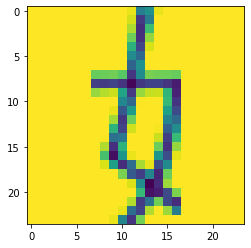

女
女 (2, 0, 12, 25)


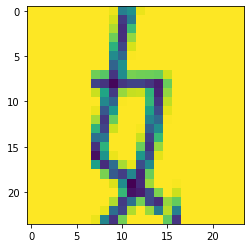

妮 {'女': (0, 0, 10, 25)}
中
妯 {}
女
女 (0, 0, 10, 25)


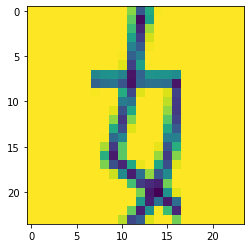

咋
女
女 (2, 0, 12, 25)


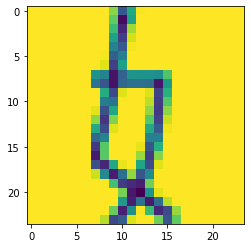

妲 {'女': (0, 0, 10, 25)}
吊
妳 {}
女
女 (2, 0, 12, 25)


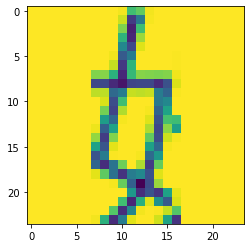

卡
妹 {'女': (2, 0, 12, 25)}
卡
卡
妺 {}
妻 {}
妼 {}
妾 {}
姁 {}
亚
下
上
姃 {}
冲
丬
丬 (10, 0, 20, 25)


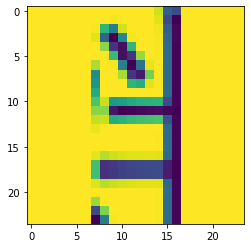

丬
丬 (10, 2, 20, 27)


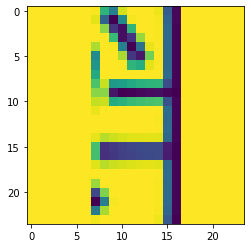

半
半
半
半
姅 {'丬': (10, 0, 20, 25)}
姆 {}
吟
囚
囚
令
今
令
今
姈 {}
女
女 (2, 0, 12, 25)


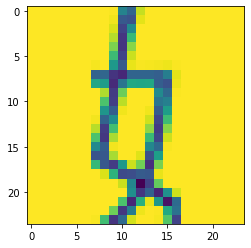

姊
姊 {'女': (2, 0, 12, 25)}
女
女 (0, 0, 10, 25)


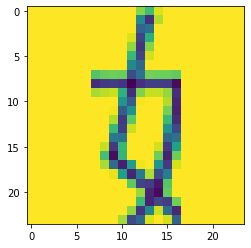

冲
女
女 (2, 0, 12, 25)


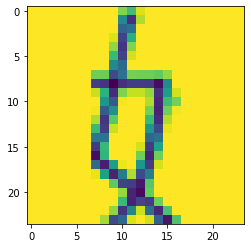

冲
台
始 {'女': (0, 0, 10, 25)}
刈
姍 {}
女
女 (2, 0, 12, 25)


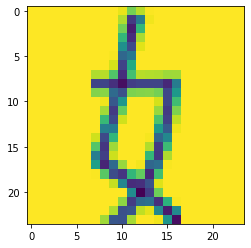

女
女 (4, 2, 14, 27)


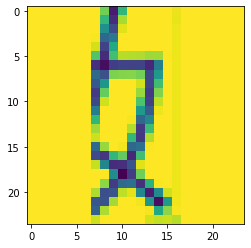

姐 {'女': (2, 0, 12, 25)}
女
女 (2, 0, 12, 25)


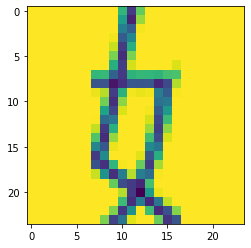

冲
姑 {'女': (2, 0, 12, 25)}
姒 {}
冲
女
女 (2, 0, 12, 25)


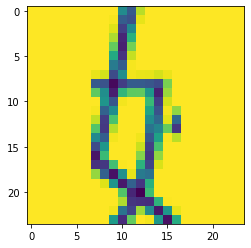

女
女 (2, 2, 12, 27)


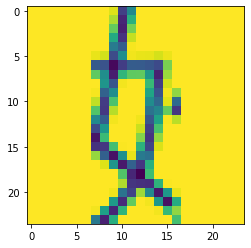

姓 {'女': (2, 0, 12, 25)}
委 {}
姗 {}
女
女 (2, 0, 12, 25)


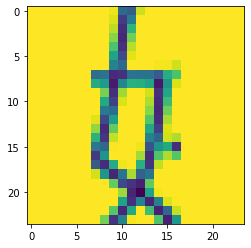

姘 {'女': (2, 0, 12, 25)}
听
午
姙 {}
女
女 (0, 0, 10, 25)


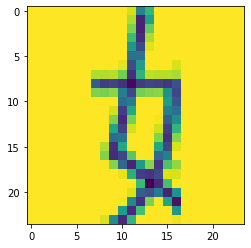

女
女 (2, 0, 12, 25)


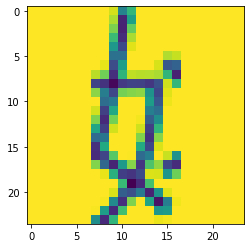

姚 {'女': (0, 0, 10, 25)}
姜
姜 {}
丬
丬 (10, 0, 20, 25)


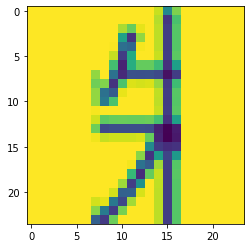

丬
丬 (10, 2, 20, 27)


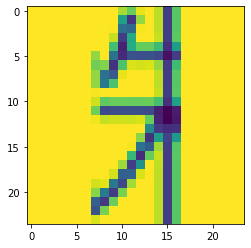

卡
姝 {'丬': (10, 0, 20, 25)}
姞 {}
女
女 (2, 0, 12, 25)


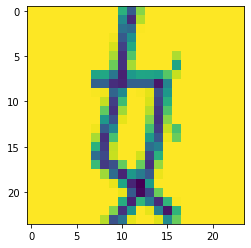

交
姣 {'女': (2, 0, 12, 25)}
冰
回
姤 {}
姥 {}
姦 {}
夕
夕 (6, 16, 16, 26)


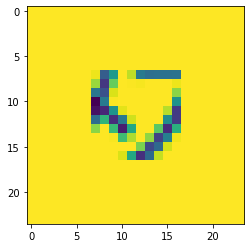

姨 {'夕': (6, 16, 16, 26)}
厣
全
姪 {}
姬 {}
姮 {}
姱 {}
姲 {}
姴 {}
冲
合
姶 {}
咋
乍
姷 {}
姹 {}
姺 {}


In [69]:
# load image and get detections
dicts = dict()
data_path = '/home/wonton/jiayi/projects/Chinese-charactor-classification-before202001/commoncharacter>500/'
for i,label in enumerate(labels):
    
    img_path = data_path + label +'/'
    img_path += os.listdir(img_path)[0]

    prev_time = time.time()
    img = Image.open(img_path)
    
    dicts[label]=dect_single(img, label)
    print(label, dicts[label])

